# Multimodal Depression Detection: Comprehensive Evaluation & Interpretability Analysis

**Author:** Jonathan Chan Jia Hao  
**Affiliation:** Monash University Malaysia, School of Information Technology  
**Date:** October 2024

---

## Overview

This notebook presents a **comprehensive empirical evaluation** of multimodal machine learning approaches for automated depression detection using the Extended DAIC-WOZ (E-DAIC) dataset. The analysis systematically compares:

- **Modality Combinations:** Bimodal (Text+Audio, Text+Video, Audio+Video) and Trimodal (Text+Audio+Video)
- **Fusion Strategies:** Early Fusion (feature-level) vs. Late Fusion (decision-level)
- **Classification Algorithms:** Logistic Regression (interpretable baseline) and XGBoost (non-linear ensemble)
- **Interpretability Methods:** Coefficient-based analysis and SHAP (SHapley Additive exPlanations)

## Key Research Questions

1. **RQ1:** How do different modality combinations impact depression detection performance?
2. **RQ2:** How do early fusion and late fusion strategies compare in efficiency and robustness?
3. **RQ3:** What interpretability insights can be gained from best-performing models, and how do different modalities contribute to classification?

## Experimental Design

- **Dataset:** E-DAIC (189 train, 86 test participants)
- **Evaluation Metrics:** Balanced Accuracy (primary), F1-Score, Precision, Recall, AUC-ROC
- **Statistical Testing:** McNemar's test, Bootstrap confidence intervals, Cohen's d effect sizes
- **Interpretability:** Coefficient magnitude analysis, SHAP values, modality contribution analysis

## Key Findings

- **Best Performance:** Text+Video Late Fusion (LR): 0.747 balanced accuracy
- **Statistical Equivalence:** Text+Audio Early Fusion achieves comparable performance (0.743)
- **Modality Importance:** Text dominates (60-69%), with audio/video providing complementary signals
- **Method Validation:** High agreement between coefficient-based and SHAP interpretability (ρ > 0.97)

## Notebook Structure

1. **Data Loading & Preprocessing** (Cells 1-5)
2. **Early Fusion Experiments** (Cells 6-20)
3. **Late Fusion Experiments** (Cells 23-33)
4. **Interpretability Analysis** (Cells 34-51)
   - Text+Video Late Fusion (Best Model)
   - Text+Audio Early Fusion (Comparable Performance)
5. **Statistical Significance Testing** (Cells 51-54)

---

**License:** MIT | **Contact:** jcha0091@student.monash.edu  
**Repository:** [GitHub](https://github.com/JonathanChan9001/Multimodal-Machine-Learning-and-Data-Analysis-Framework-for-Depression-Detection)

---

In [1]:
# Cell 1: Import libraries and set seed

# Core libraries
import pickle
import numpy as np
import pandas as pd
import random

# XGBoost
from xgboost import XGBClassifier

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

print(f"All seeds set to: {SEED}")
print("="*70)
print("LOGISTIC REGRESSION vs XGBOOST COMPARISON")
print("Bimodal (Text + Audio) and Trimodal (Text + Audio + Video)")
print("Early Fusion Only")
print("="*70)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")


All seeds set to: 123
LOGISTIC REGRESSION vs XGBOOST COMPARISON
Bimodal (Text + Audio) and Trimodal (Text + Audio + Video)
Early Fusion Only
Start Time: 2025-10-14 20:56:25



In [2]:
# Cell 2: Load data

BASE_PATH = '/home/jonathanchan/ml_data'

# Load text utterance embeddings
with open(f'{BASE_PATH}/text_data_utterance_with_labels.pkl', 'rb') as f:
    text_utterance_data = pickle.load(f)

# Load audio segment embeddings
with open(f'{BASE_PATH}/audio_data_segment_with_labels.pkl', 'rb') as f:
    audio_segment_data = pickle.load(f)

# Load video data
with open(f'{BASE_PATH}/video_data_with_labels.pkl', 'rb') as f:
    video_data = pickle.load(f)

print("Data loaded successfully")
print(f"  Text utterance data: {text_utterance_data.shape}")
print(f"  Audio segment data:  {audio_segment_data.shape}")
print(f"  Video data:          {video_data.shape}")

Data loaded successfully
  Text utterance data: (275, 8)
  Audio segment data:  (275, 7)
  Video data:          (275, 35)


In [3]:
# Cell 3: Align participants across all modalities

# Extract participant IDs
text_ids = set(text_utterance_data['Participant_ID'].values)
audio_ids = set(audio_segment_data['Participant_ID'].values)
video_ids = set(video_data['Participant_ID'].values)

print(f"\nParticipant counts:")
print(f"  Text:  {len(text_ids)}")
print(f"  Audio: {len(audio_ids)}")
print(f"  Video: {len(video_ids)}")

# Find common participants across all three modalities
common_ids_all = sorted(list(text_ids & audio_ids & video_ids))

print(f"\nCommon participants (Text + Audio + Video): {len(common_ids_all)}")

# Filter and align
text_mask = text_utterance_data['Participant_ID'].isin(common_ids_all)
audio_mask = audio_segment_data['Participant_ID'].isin(common_ids_all)
video_mask = video_data['Participant_ID'].isin(common_ids_all)

text_aligned = text_utterance_data[text_mask].sort_values('Participant_ID').reset_index(drop=True)
audio_aligned = audio_segment_data[audio_mask].sort_values('Participant_ID').reset_index(drop=True)
video_aligned = video_data[video_mask].sort_values('Participant_ID').reset_index(drop=True)

# Verify alignment
assert all(text_aligned['Participant_ID'] == audio_aligned['Participant_ID']), "Text-Audio mismatch!"
assert all(text_aligned['Participant_ID'] == video_aligned['Participant_ID']), "Text-Video mismatch!"

print("✓ All modalities aligned successfully")


Participant counts:
  Text:  275
  Audio: 275
  Video: 275

Common participants (Text + Audio + Video): 275
✓ All modalities aligned successfully


In [4]:
# Cell 4: Extract features

print("\n" + "="*70)
print("EXTRACTING FEATURES")
print("="*70)

# Text embeddings
text_features = np.array([
    np.array(embedding) for embedding in text_aligned['mean_pooled_embedding']
])

# Audio embeddings
audio_features = np.array([
    np.array(embedding) for embedding in audio_aligned['mean_pooled_embedding']
])

# Video features
video_features = np.array([
    np.array(features) for features in video_aligned['video_features']
])

# Labels
labels = text_aligned['Depression_label'].values

print("Feature shapes:")
print(f"  Text:  {text_features.shape}")
print(f"  Audio: {audio_features.shape}")
print(f"  Video: {video_features.shape}")
print(f"  Labels: {labels.shape}")



EXTRACTING FEATURES
Feature shapes:
  Text:  (275, 768)
  Audio: (275, 768)
  Video: (275, 104)
  Labels: (275,)


In [5]:
# Cell 5: Split data using E-DAIC official splits

train_mask = text_aligned['split'] == 'train'
dev_mask = text_aligned['split'] == 'dev'
test_mask = text_aligned['split'] == 'test'

train_indices = np.where(train_mask)[0]
dev_indices = np.where(dev_mask)[0]
test_indices = np.where(test_mask)[0]

print("\n" + "="*70)
print("E-DAIC OFFICIAL SPLITS")
print("="*70)
print(f"  Train: {len(train_indices)} participants")
print(f"  Dev:   {len(dev_indices)} participants")
print(f"  Test:  {len(test_indices)} participants")

# Verify no data leakage
assert len(set(train_indices) & set(dev_indices)) == 0, "Train-Dev overlap!"
assert len(set(train_indices) & set(test_indices)) == 0, "Train-Test overlap!"
assert len(set(dev_indices) & set(test_indices)) == 0, "Dev-Test overlap!"
print("\n✓ No data leakage detected")

# Show class distribution
y_train = labels[train_indices]
y_dev = labels[dev_indices]
y_test = labels[test_indices]

print("\nClass distribution:")
print(f"  Train: Not Depressed={np.sum(y_train == 0)}, Depressed={np.sum(y_train == 1)}")
print(f"  Dev:   Not Depressed={np.sum(y_dev == 0)}, Depressed={np.sum(y_dev == 1)}")
print(f"  Test:  Not Depressed={np.sum(y_test == 0)}, Depressed={np.sum(y_test == 1)}")



E-DAIC OFFICIAL SPLITS
  Train: 163 participants
  Dev:   56 participants
  Test:  56 participants

✓ No data leakage detected

Class distribution:
  Train: Not Depressed=126, Depressed=37
  Dev:   Not Depressed=44, Depressed=12
  Test:  Not Depressed=39, Depressed=17


# 1. EARLY FUSION 

In [6]:
# Cell 6: Experiment 1 - Bimodal (Text + Audio) - Logistic Regression

print("\n" + "="*70)
print("EXPERIMENT 1: BIMODAL (TEXT + AUDIO) - LOGISTIC REGRESSION")
print("="*70)

# Early fusion: concatenate text + audio
bimodal_features = np.concatenate([text_features, audio_features], axis=1)

print(f"Bimodal features shape: {bimodal_features.shape}")

# Split
X_train_bi = bimodal_features[train_indices]
X_dev_bi = bimodal_features[dev_indices]
X_test_bi = bimodal_features[test_indices]

# Standardize (CRITICAL for Logistic Regression)
scaler_bi_lr = StandardScaler()
X_train_bi_scaled = scaler_bi_lr.fit_transform(X_train_bi)
X_dev_bi_scaled = scaler_bi_lr.transform(X_dev_bi)
X_test_bi_scaled = scaler_bi_lr.transform(X_test_bi)

# Calculate class weight
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
class_weight_dict = {0: 1.0, 1: scale_pos_weight}

print(f"Class weight: {scale_pos_weight:.2f}")

# Train Logistic Regression with class balancing
print("\nTraining Logistic Regression...")
lr_bi = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=SEED,
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    C=1
)
lr_bi.fit(X_train_bi_scaled, y_train)

# Evaluate on dev
dev_pred_lr_bi = lr_bi.predict(X_dev_bi_scaled)
dev_proba_lr_bi = lr_bi.predict_proba(X_dev_bi_scaled)[:, 1]

dev_metrics_lr_bi = {
    'accuracy': accuracy_score(y_dev, dev_pred_lr_bi),
    'balanced_accuracy': balanced_accuracy_score(y_dev, dev_pred_lr_bi),
    'f1': f1_score(y_dev, dev_pred_lr_bi),
    'precision': precision_score(y_dev, dev_pred_lr_bi),
    'recall': recall_score(y_dev, dev_pred_lr_bi),
    'auc': roc_auc_score(y_dev, dev_proba_lr_bi)
}

# Evaluate on test
test_pred_lr_bi = lr_bi.predict(X_test_bi_scaled)
test_proba_lr_bi = lr_bi.predict_proba(X_test_bi_scaled)[:, 1]

test_metrics_lr_bi = {
    'accuracy': accuracy_score(y_test, test_pred_lr_bi),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred_lr_bi),
    'f1': f1_score(y_test, test_pred_lr_bi),
    'precision': precision_score(y_test, test_pred_lr_bi),
    'recall': recall_score(y_test, test_pred_lr_bi),
    'auc': roc_auc_score(y_test, test_proba_lr_bi)
}

print("\nLOGISTIC REGRESSION RESULTS:")
print("Dev Set:")
for metric, value in dev_metrics_lr_bi.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nTest Set:")
for metric, value in test_metrics_lr_bi.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred_lr_bi))


EXPERIMENT 1: BIMODAL (TEXT + AUDIO) - LOGISTIC REGRESSION
Bimodal features shape: (275, 1536)
Class weight: 3.41

Training Logistic Regression...

LOGISTIC REGRESSION RESULTS:
Dev Set:
  Accuracy            : 0.7500
  Balanced_accuracy   : 0.5682
  F1                  : 0.3000
  Precision           : 0.3750
  Recall              : 0.2500
  Auc                 : 0.6174

Test Set:
  Accuracy            : 0.8036
  Balanced_accuracy   : 0.7428
  F1                  : 0.6452
  Precision           : 0.7143
  Recall              : 0.5882
  Auc                 : 0.7903

Confusion Matrix (Test):
[[35  4]
 [ 7 10]]


In [7]:
# Cell 7: Experiment 2 - Bimodal (Text + Audio) - XGBoost

print("\n" + "="*70)
print("EXPERIMENT 2: BIMODAL (TEXT + AUDIO) - XGBOOST")
print("="*70)

# Use same features and scaler
scaler_bi_xgb = StandardScaler()
X_train_bi_xgb_scaled = scaler_bi_xgb.fit_transform(X_train_bi)
X_dev_bi_xgb_scaled = scaler_bi_xgb.transform(X_dev_bi)
X_test_bi_xgb_scaled = scaler_bi_xgb.transform(X_test_bi)

# Train XGBoost
print("Training XGBoost...")
xgb_bi = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    eval_metric='logloss',
    verbosity=1
)
xgb_bi.fit(X_train_bi_xgb_scaled, y_train)

# Evaluate on dev
dev_pred_xgb_bi = xgb_bi.predict(X_dev_bi_xgb_scaled)
dev_proba_xgb_bi = xgb_bi.predict_proba(X_dev_bi_xgb_scaled)[:, 1]

dev_metrics_xgb_bi = {
    'accuracy': accuracy_score(y_dev, dev_pred_xgb_bi),
    'balanced_accuracy': balanced_accuracy_score(y_dev, dev_pred_xgb_bi),
    'f1': f1_score(y_dev, dev_pred_xgb_bi),
    'precision': precision_score(y_dev, dev_pred_xgb_bi),
    'recall': recall_score(y_dev, dev_pred_xgb_bi),
    'auc': roc_auc_score(y_dev, dev_proba_xgb_bi)
}

# Evaluate on test
test_pred_xgb_bi = xgb_bi.predict(X_test_bi_xgb_scaled)
test_proba_xgb_bi = xgb_bi.predict_proba(X_test_bi_xgb_scaled)[:, 1]

test_metrics_xgb_bi = {
    'accuracy': accuracy_score(y_test, test_pred_xgb_bi),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred_xgb_bi),
    'f1': f1_score(y_test, test_pred_xgb_bi),
    'precision': precision_score(y_test, test_pred_xgb_bi),
    'recall': recall_score(y_test, test_pred_xgb_bi),
    'auc': roc_auc_score(y_test, test_proba_xgb_bi)
}

print("\nXGBOOST RESULTS:")
print("Dev Set:")
for metric, value in dev_metrics_xgb_bi.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nTest Set:")
for metric, value in test_metrics_xgb_bi.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred_xgb_bi))


EXPERIMENT 2: BIMODAL (TEXT + AUDIO) - XGBOOST
Training XGBoost...

XGBOOST RESULTS:
Dev Set:
  Accuracy            : 0.7321
  Balanced_accuracy   : 0.5871
  F1                  : 0.3478
  Precision           : 0.3636
  Recall              : 0.3333
  Auc                 : 0.6761

Test Set:
  Accuracy            : 0.8036
  Balanced_accuracy   : 0.7097
  F1                  : 0.5926
  Precision           : 0.8000
  Recall              : 0.4706
  Auc                 : 0.7632

Confusion Matrix (Test):
[[37  2]
 [ 9  8]]


In [8]:
# Cell 8: Experiment 3 - Bimodal (Text + Video) - Logistic Regression

print("\n" + "="*70)
print("EXPERIMENT 3: BIMODAL (TEXT + VIDEO) - LOGISTIC REGRESSION")
print("="*70)

# Early fusion: concatenate text + video
text_video_features = np.concatenate([text_features, video_features], axis=1)

print(f"Text + Video features shape: {text_video_features.shape}")

# Split
X_train_tv = text_video_features[train_indices]
X_dev_tv = text_video_features[dev_indices]
X_test_tv = text_video_features[test_indices]

# Standardize
scaler_tv_lr = StandardScaler()
X_train_tv_scaled = scaler_tv_lr.fit_transform(X_train_tv)
X_dev_tv_scaled = scaler_tv_lr.transform(X_dev_tv)
X_test_tv_scaled = scaler_tv_lr.transform(X_test_tv)

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_tv = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=SEED,
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    C=1.0
)
lr_tv.fit(X_train_tv_scaled, y_train)

# Evaluate on dev
dev_pred_lr_tv = lr_tv.predict(X_dev_tv_scaled)
dev_proba_lr_tv = lr_tv.predict_proba(X_dev_tv_scaled)[:, 1]

dev_metrics_lr_tv = {
    'accuracy': accuracy_score(y_dev, dev_pred_lr_tv),
    'balanced_accuracy': balanced_accuracy_score(y_dev, dev_pred_lr_tv),
    'f1': f1_score(y_dev, dev_pred_lr_tv),
    'precision': precision_score(y_dev, dev_pred_lr_tv),
    'recall': recall_score(y_dev, dev_pred_lr_tv),
    'auc': roc_auc_score(y_dev, dev_proba_lr_tv)
}

# Evaluate on test
test_pred_lr_tv = lr_tv.predict(X_test_tv_scaled)
test_proba_lr_tv = lr_tv.predict_proba(X_test_tv_scaled)[:, 1]

test_metrics_lr_tv = {
    'accuracy': accuracy_score(y_test, test_pred_lr_tv),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred_lr_tv),
    'f1': f1_score(y_test, test_pred_lr_tv),
    'precision': precision_score(y_test, test_pred_lr_tv),
    'recall': recall_score(y_test, test_pred_lr_tv),
    'auc': roc_auc_score(y_test, test_proba_lr_tv)
}

print("\nLOGISTIC REGRESSION RESULTS:")
print("Dev Set:")
for metric, value in dev_metrics_lr_tv.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nTest Set:")
for metric, value in test_metrics_lr_tv.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred_lr_tv))


EXPERIMENT 3: BIMODAL (TEXT + VIDEO) - LOGISTIC REGRESSION
Text + Video features shape: (275, 872)

Training Logistic Regression...

LOGISTIC REGRESSION RESULTS:
Dev Set:
  Accuracy            : 0.6786
  Balanced_accuracy   : 0.5530
  F1                  : 0.3077
  Precision           : 0.2857
  Recall              : 0.3333
  Auc                 : 0.5871

Test Set:
  Accuracy            : 0.7500
  Balanced_accuracy   : 0.7044
  F1                  : 0.5882
  Precision           : 0.5882
  Recall              : 0.5882
  Auc                 : 0.7557

Confusion Matrix (Test):
[[32  7]
 [ 7 10]]


In [9]:
# Cell 9: Experiment 4 - Bimodal (Text + Video) - XGBoost

print("\n" + "="*70)
print("EXPERIMENT 4: BIMODAL (TEXT + VIDEO) - XGBOOST")
print("="*70)

# Standardize
scaler_tv_xgb = StandardScaler()
X_train_tv_xgb_scaled = scaler_tv_xgb.fit_transform(X_train_tv)
X_dev_tv_xgb_scaled = scaler_tv_xgb.transform(X_dev_tv)
X_test_tv_xgb_scaled = scaler_tv_xgb.transform(X_test_tv)

# Train XGBoost
print("Training XGBoost...")
xgb_tv = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    eval_metric='logloss',
    verbosity=1
)
xgb_tv.fit(X_train_tv_xgb_scaled, y_train)

# Evaluate on dev
dev_pred_xgb_tv = xgb_tv.predict(X_dev_tv_xgb_scaled)
dev_proba_xgb_tv = xgb_tv.predict_proba(X_dev_tv_xgb_scaled)[:, 1]

dev_metrics_xgb_tv = {
    'accuracy': accuracy_score(y_dev, dev_pred_xgb_tv),
    'balanced_accuracy': balanced_accuracy_score(y_dev, dev_pred_xgb_tv),
    'f1': f1_score(y_dev, dev_pred_xgb_tv),
    'precision': precision_score(y_dev, dev_pred_xgb_tv),
    'recall': recall_score(y_dev, dev_pred_xgb_tv),
    'auc': roc_auc_score(y_dev, dev_proba_xgb_tv)
}

# Evaluate on test
test_pred_xgb_tv = xgb_tv.predict(X_test_tv_xgb_scaled)
test_proba_xgb_tv = xgb_tv.predict_proba(X_test_tv_xgb_scaled)[:, 1]

test_metrics_xgb_tv = {
    'accuracy': accuracy_score(y_test, test_pred_xgb_tv),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred_xgb_tv),
    'f1': f1_score(y_test, test_pred_xgb_tv),
    'precision': precision_score(y_test, test_pred_xgb_tv),
    'recall': recall_score(y_test, test_pred_xgb_tv),
    'auc': roc_auc_score(y_test, test_proba_xgb_tv)
}

print("\nXGBOOST RESULTS:")
print("Dev Set:")
for metric, value in dev_metrics_xgb_tv.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nTest Set:")
for metric, value in test_metrics_xgb_tv.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred_xgb_tv))


EXPERIMENT 4: BIMODAL (TEXT + VIDEO) - XGBOOST
Training XGBoost...

XGBOOST RESULTS:
Dev Set:
  Accuracy            : 0.7500
  Balanced_accuracy   : 0.5682
  F1                  : 0.3000
  Precision           : 0.3750
  Recall              : 0.2500
  Auc                 : 0.6155

Test Set:
  Accuracy            : 0.6786
  Balanced_accuracy   : 0.5867
  F1                  : 0.4000
  Precision           : 0.4615
  Recall              : 0.3529
  Auc                 : 0.7602

Confusion Matrix (Test):
[[32  7]
 [11  6]]


In [10]:
# Cell 10: Experiment 5 - Bimodal (Audio + Video) - Logistic Regression

print("\n" + "="*70)
print("EXPERIMENT 5: BIMODAL (AUDIO + VIDEO) - LOGISTIC REGRESSION")
print("="*70)

# Early fusion: concatenate audio + video
audio_video_features = np.concatenate([audio_features, video_features], axis=1)

print(f"Audio + Video features shape: {audio_video_features.shape}")

# Split
X_train_av = audio_video_features[train_indices]
X_dev_av = audio_video_features[dev_indices]
X_test_av = audio_video_features[test_indices]

# Standardize
scaler_av_lr = StandardScaler()
X_train_av_scaled = scaler_av_lr.fit_transform(X_train_av)
X_dev_av_scaled = scaler_av_lr.transform(X_dev_av)
X_test_av_scaled = scaler_av_lr.transform(X_test_av)

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_av = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=SEED,
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    C=1.0
)
lr_av.fit(X_train_av_scaled, y_train)

# Evaluate on dev
dev_pred_lr_av = lr_av.predict(X_dev_av_scaled)
dev_proba_lr_av = lr_av.predict_proba(X_dev_av_scaled)[:, 1]

dev_metrics_lr_av = {
    'accuracy': accuracy_score(y_dev, dev_pred_lr_av),
    'balanced_accuracy': balanced_accuracy_score(y_dev, dev_pred_lr_av),
    'f1': f1_score(y_dev, dev_pred_lr_av),
    'precision': precision_score(y_dev, dev_pred_lr_av),
    'recall': recall_score(y_dev, dev_pred_lr_av),
    'auc': roc_auc_score(y_dev, dev_proba_lr_av)
}

# Evaluate on test
test_pred_lr_av = lr_av.predict(X_test_av_scaled)
test_proba_lr_av = lr_av.predict_proba(X_test_av_scaled)[:, 1]

test_metrics_lr_av = {
    'accuracy': accuracy_score(y_test, test_pred_lr_av),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred_lr_av),
    'f1': f1_score(y_test, test_pred_lr_av),
    'precision': precision_score(y_test, test_pred_lr_av),
    'recall': recall_score(y_test, test_pred_lr_av),
    'auc': roc_auc_score(y_test, test_proba_lr_av)
}

print("\nLOGISTIC REGRESSION RESULTS:")
print("Dev Set:")
for metric, value in dev_metrics_lr_av.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nTest Set:")
for metric, value in test_metrics_lr_av.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred_lr_av))


EXPERIMENT 5: BIMODAL (AUDIO + VIDEO) - LOGISTIC REGRESSION
Audio + Video features shape: (275, 872)

Training Logistic Regression...

LOGISTIC REGRESSION RESULTS:
Dev Set:
  Accuracy            : 0.6429
  Balanced_accuracy   : 0.5303
  F1                  : 0.2857
  Precision           : 0.2500
  Recall              : 0.3333
  Auc                 : 0.5189

Test Set:
  Accuracy            : 0.6964
  Balanced_accuracy   : 0.6327
  F1                  : 0.4848
  Precision           : 0.5000
  Recall              : 0.4706
  Auc                 : 0.6320

Confusion Matrix (Test):
[[31  8]
 [ 9  8]]


In [11]:

# Cell 11: Experiment 6 - Bimodal (Audio + Video) - XGBoost

print("\n" + "="*70)
print("EXPERIMENT 6: BIMODAL (AUDIO + VIDEO) - XGBOOST")
print("="*70)

# Standardize
scaler_av_xgb = StandardScaler()
X_train_av_xgb_scaled = scaler_av_xgb.fit_transform(X_train_av)
X_dev_av_xgb_scaled = scaler_av_xgb.transform(X_dev_av)
X_test_av_xgb_scaled = scaler_av_xgb.transform(X_test_av)

# Train XGBoost
print("Training XGBoost...")
xgb_av = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    eval_metric='logloss',
    verbosity=1
)
xgb_av.fit(X_train_av_xgb_scaled, y_train)

# Evaluate on dev
dev_pred_xgb_av = xgb_av.predict(X_dev_av_xgb_scaled)
dev_proba_xgb_av = xgb_av.predict_proba(X_dev_av_xgb_scaled)[:, 1]

dev_metrics_xgb_av = {
    'accuracy': accuracy_score(y_dev, dev_pred_xgb_av),
    'balanced_accuracy': balanced_accuracy_score(y_dev, dev_pred_xgb_av),
    'f1': f1_score(y_dev, dev_pred_xgb_av),
    'precision': precision_score(y_dev, dev_pred_xgb_av),
    'recall': recall_score(y_dev, dev_pred_xgb_av),
    'auc': roc_auc_score(y_dev, dev_proba_xgb_av)
}

# Evaluate on test
test_pred_xgb_av = xgb_av.predict(X_test_av_xgb_scaled)
test_proba_xgb_av = xgb_av.predict_proba(X_test_av_xgb_scaled)[:, 1]

test_metrics_xgb_av = {
    'accuracy': accuracy_score(y_test, test_pred_xgb_av),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred_xgb_av),
    'f1': f1_score(y_test, test_pred_xgb_av),
    'precision': precision_score(y_test, test_pred_xgb_av),
    'recall': recall_score(y_test, test_pred_xgb_av),
    'auc': roc_auc_score(y_test, test_proba_xgb_av)
}

print("\nXGBOOST RESULTS:")
print("Dev Set:")
for metric, value in dev_metrics_xgb_av.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nTest Set:")
for metric, value in test_metrics_xgb_av.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred_xgb_av))


EXPERIMENT 6: BIMODAL (AUDIO + VIDEO) - XGBOOST
Training XGBoost...

XGBOOST RESULTS:
Dev Set:
  Accuracy            : 0.8393
  Balanced_accuracy   : 0.7159
  F1                  : 0.5714
  Precision           : 0.6667
  Recall              : 0.5000
  Auc                 : 0.7197

Test Set:
  Accuracy            : 0.6429
  Balanced_accuracy   : 0.4947
  F1                  : 0.1667
  Precision           : 0.2857
  Recall              : 0.1176
  Auc                 : 0.5339

Confusion Matrix (Test):
[[34  5]
 [15  2]]


In [12]:
# Cell 12: ALL BIMODAL COMPARISONS (Early Fusion Only)

print("\n" + "="*70)
print("COMPREHENSIVE BIMODAL COMPARISON: ALL 3 COMBINATIONS")
print("LOGISTIC REGRESSION vs XGBOOST (EARLY FUSION ONLY)")
print("="*70)

# Create comprehensive comparison table
all_bimodal_results = pd.DataFrame({
    'Configuration': [
        'Text + Audio',
        'Text + Audio',
        'Text + Video',
        'Text + Video',
        'Audio + Video',
        'Audio + Video'
    ],
    'Classifier': ['LR', 'XGB', 'LR', 'XGB', 'LR', 'XGB'],
    'Accuracy': [
        test_metrics_lr_bi['accuracy'],
        test_metrics_xgb_bi['accuracy'],
        test_metrics_lr_tv['accuracy'],
        test_metrics_xgb_tv['accuracy'],
        test_metrics_lr_av['accuracy'],
        test_metrics_xgb_av['accuracy']
    ],
    'Balanced_Acc': [
        test_metrics_lr_bi['balanced_accuracy'],
        test_metrics_xgb_bi['balanced_accuracy'],
        test_metrics_lr_tv['balanced_accuracy'],
        test_metrics_xgb_tv['balanced_accuracy'],
        test_metrics_lr_av['balanced_accuracy'],
        test_metrics_xgb_av['balanced_accuracy']
    ],
    'F1': [
        test_metrics_lr_bi['f1'],
        test_metrics_xgb_bi['f1'],
        test_metrics_lr_tv['f1'],
        test_metrics_xgb_tv['f1'],
        test_metrics_lr_av['f1'],
        test_metrics_xgb_av['f1']
    ],
    'Precision': [
        test_metrics_lr_bi['precision'],
        test_metrics_xgb_bi['precision'],
        test_metrics_lr_tv['precision'],
        test_metrics_xgb_tv['precision'],
        test_metrics_lr_av['precision'],
        test_metrics_xgb_av['precision']
    ],
    'Recall': [
        test_metrics_lr_bi['recall'],
        test_metrics_xgb_bi['recall'],
        test_metrics_lr_tv['recall'],
        test_metrics_xgb_tv['recall'],
        test_metrics_lr_av['recall'],
        test_metrics_xgb_av['recall']
    ],
    'AUC': [
        test_metrics_lr_bi['auc'],
        test_metrics_xgb_bi['auc'],
        test_metrics_lr_tv['auc'],
        test_metrics_xgb_tv['auc'],
        test_metrics_lr_av['auc'],
        test_metrics_xgb_av['auc']
    ]
})

print("\nALL BIMODAL RESULTS (TEST SET - EARLY FUSION):")
print(all_bimodal_results.to_string(index=False))

# Comparison by configuration
print("\n" + "="*70)
print("PAIRWISE COMPARISONS (LR vs XGB)")
print("="*70)

configs = ['Text + Audio', 'Text + Video', 'Audio + Video']
lr_metrics_list = [test_metrics_lr_bi, test_metrics_lr_tv, test_metrics_lr_av]
xgb_metrics_list = [test_metrics_xgb_bi, test_metrics_xgb_tv, test_metrics_xgb_av]

for i, config in enumerate(configs):
    print(f"\n{config}:")
    lr_bal_acc = lr_metrics_list[i]['balanced_accuracy']
    xgb_bal_acc = xgb_metrics_list[i]['balanced_accuracy']
    lr_f1 = lr_metrics_list[i]['f1']
    xgb_f1 = xgb_metrics_list[i]['f1']
    
    print(f"  LR:  Balanced Acc = {lr_bal_acc:.4f}, F1 = {lr_f1:.4f}")
    print(f"  XGB: Balanced Acc = {xgb_bal_acc:.4f}, F1 = {xgb_f1:.4f}")
    
    if lr_bal_acc > xgb_bal_acc:
        print(f"  → LR wins by {(lr_bal_acc - xgb_bal_acc):.4f} ({(lr_bal_acc - xgb_bal_acc)/xgb_bal_acc*100:+.2f}%)")
    else:
        print(f"  → XGB wins by {(xgb_bal_acc - lr_bal_acc):.4f} ({(xgb_bal_acc - lr_bal_acc)/lr_bal_acc*100:+.2f}%)")

# Overall winner count
print("\n" + "="*70)
print("OVERALL WINNER ANALYSIS")
print("="*70)

lr_wins = 0
xgb_wins = 0
ties = 0

for config in configs:
    if config == 'Text + Audio':
        lr_bal = test_metrics_lr_bi['balanced_accuracy']
        xgb_bal = test_metrics_xgb_bi['balanced_accuracy']
    elif config == 'Text + Video':
        lr_bal = test_metrics_lr_tv['balanced_accuracy']
        xgb_bal = test_metrics_xgb_tv['balanced_accuracy']
    else:  # Audio + Video
        lr_bal = test_metrics_lr_av['balanced_accuracy']
        xgb_bal = test_metrics_xgb_av['balanced_accuracy']
    
    if lr_bal > xgb_bal:
        lr_wins += 1
    elif xgb_bal > lr_bal:
        xgb_wins += 1
    else:
        ties += 1

print(f"\nClassifier Performance Across All Bimodal Combinations:")
print(f"  Logistic Regression wins: {lr_wins}/3")
print(f"  XGBoost wins:             {xgb_wins}/3")
print(f"  Ties:                     {ties}/3")

if lr_wins > xgb_wins:
    print("\n  ✓ Logistic Regression is the BETTER classifier overall!")
elif xgb_wins > lr_wins:
    print("\n  ✓ XGBoost is the BETTER classifier overall!")
else:
    print("\n  → No clear winner - performance is comparable")

# Best overall configuration
best_idx = all_bimodal_results['Balanced_Acc'].idxmax()
best_config = all_bimodal_results.iloc[best_idx]

print("\n" + "="*70)
print("BEST OVERALL BIMODAL CONFIGURATION:")
print("="*70)
print(f"Configuration: {best_config['Configuration']}")
print(f"Classifier:    {best_config['Classifier']}")
print(f"Balanced Acc:  {best_config['Balanced_Acc']:.4f}")
print(f"F1 Score:      {best_config['F1']:.4f}")
print(f"Precision:     {best_config['Precision']:.4f}")
print(f"Recall:        {best_config['Recall']:.4f}")


COMPREHENSIVE BIMODAL COMPARISON: ALL 3 COMBINATIONS
LOGISTIC REGRESSION vs XGBOOST (EARLY FUSION ONLY)

ALL BIMODAL RESULTS (TEST SET - EARLY FUSION):
Configuration Classifier  Accuracy  Balanced_Acc       F1  Precision   Recall      AUC
 Text + Audio         LR  0.803571      0.742836 0.645161   0.714286 0.588235 0.790347
 Text + Audio        XGB  0.803571      0.709653 0.592593   0.800000 0.470588 0.763198
 Text + Video         LR  0.750000      0.704374 0.588235   0.588235 0.588235 0.755656
 Text + Video        XGB  0.678571      0.586727 0.400000   0.461538 0.352941 0.760181
Audio + Video         LR  0.696429      0.632730 0.484848   0.500000 0.470588 0.631976
Audio + Video        XGB  0.642857      0.494721 0.166667   0.285714 0.117647 0.533937

PAIRWISE COMPARISONS (LR vs XGB)

Text + Audio:
  LR:  Balanced Acc = 0.7428, F1 = 0.6452
  XGB: Balanced Acc = 0.7097, F1 = 0.5926
  → LR wins by 0.0332 (+4.68%)

Text + Video:
  LR:  Balanced Acc = 0.7044, F1 = 0.5882
  XGB: Balanced A

In [13]:
# Cell 13: Experiment 3 - Trimodal (Text + Audio + Video) - Logistic Regression

print("\n" + "="*70)
print("EXPERIMENT 3: TRIMODAL (TEXT + AUDIO + VIDEO) - LOGISTIC REGRESSION")
print("="*70)

# Early fusion: concatenate all three modalities
trimodal_features = np.concatenate([text_features, audio_features, video_features], axis=1)

print(f"Trimodal features shape: {trimodal_features.shape}")
print(f"  Text:  {text_features.shape[1]} dims")
print(f"  Audio: {audio_features.shape[1]} dims")
print(f"  Video: {video_features.shape[1]} dims")
print(f"  Total: {trimodal_features.shape[1]} dims")

# Split
X_train_tri = trimodal_features[train_indices]
X_dev_tri = trimodal_features[dev_indices]
X_test_tri = trimodal_features[test_indices]

# Standardize
scaler_tri_lr = StandardScaler()
X_train_tri_scaled = scaler_tri_lr.fit_transform(X_train_tri)
X_dev_tri_scaled = scaler_tri_lr.transform(X_dev_tri)
X_test_tri_scaled = scaler_tri_lr.transform(X_test_tri)

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_tri = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=SEED,
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    C=1.0
)
lr_tri.fit(X_train_tri_scaled, y_train)

# Evaluate on dev
dev_pred_lr_tri = lr_tri.predict(X_dev_tri_scaled)
dev_proba_lr_tri = lr_tri.predict_proba(X_dev_tri_scaled)[:, 1]

dev_metrics_lr_tri = {
    'accuracy': accuracy_score(y_dev, dev_pred_lr_tri),
    'balanced_accuracy': balanced_accuracy_score(y_dev, dev_pred_lr_tri),
    'f1': f1_score(y_dev, dev_pred_lr_tri),
    'precision': precision_score(y_dev, dev_pred_lr_tri),
    'recall': recall_score(y_dev, dev_pred_lr_tri),
    'auc': roc_auc_score(y_dev, dev_proba_lr_tri)
}

# Evaluate on test
test_pred_lr_tri = lr_tri.predict(X_test_tri_scaled)
test_proba_lr_tri = lr_tri.predict_proba(X_test_tri_scaled)[:, 1]

test_metrics_lr_tri = {
    'accuracy': accuracy_score(y_test, test_pred_lr_tri),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred_lr_tri),
    'f1': f1_score(y_test, test_pred_lr_tri),
    'precision': precision_score(y_test, test_pred_lr_tri),
    'recall': recall_score(y_test, test_pred_lr_tri),
    'auc': roc_auc_score(y_test, test_proba_lr_tri)
}

print("\nLOGISTIC REGRESSION RESULTS:")
print("Dev Set:")
for metric, value in dev_metrics_lr_tri.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nTest Set:")
for metric, value in test_metrics_lr_tri.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred_lr_tri))


EXPERIMENT 3: TRIMODAL (TEXT + AUDIO + VIDEO) - LOGISTIC REGRESSION
Trimodal features shape: (275, 1640)
  Text:  768 dims
  Audio: 768 dims
  Video: 104 dims
  Total: 1640 dims

Training Logistic Regression...

LOGISTIC REGRESSION RESULTS:
Dev Set:
  Accuracy            : 0.7143
  Balanced_accuracy   : 0.5455
  F1                  : 0.2727
  Precision           : 0.3000
  Recall              : 0.2500
  Auc                 : 0.5758

Test Set:
  Accuracy            : 0.7857
  Balanced_accuracy   : 0.7134
  F1                  : 0.6000
  Precision           : 0.6923
  Recall              : 0.5294
  Auc                 : 0.7617

Confusion Matrix (Test):
[[35  4]
 [ 8  9]]


In [14]:
# Cell 14: Experiment 4 - Trimodal (Text + Audio + Video) - XGBoost

print("\n" + "="*70)
print("EXPERIMENT 4: TRIMODAL (TEXT + AUDIO + VIDEO) - XGBOOST")
print("="*70)

# Standardize
scaler_tri_xgb = StandardScaler()
X_train_tri_xgb_scaled = scaler_tri_xgb.fit_transform(X_train_tri)
X_dev_tri_xgb_scaled = scaler_tri_xgb.transform(X_dev_tri)
X_test_tri_xgb_scaled = scaler_tri_xgb.transform(X_test_tri)

# Train XGBoost
print("Training XGBoost...")
xgb_tri = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    eval_metric='logloss',
    verbosity=1
)
xgb_tri.fit(X_train_tri_xgb_scaled, y_train)

# Evaluate on dev
dev_pred_xgb_tri = xgb_tri.predict(X_dev_tri_xgb_scaled)
dev_proba_xgb_tri = xgb_tri.predict_proba(X_dev_tri_xgb_scaled)[:, 1]

dev_metrics_xgb_tri = {
    'accuracy': accuracy_score(y_dev, dev_pred_xgb_tri),
    'balanced_accuracy': balanced_accuracy_score(y_dev, dev_pred_xgb_tri),
    'f1': f1_score(y_dev, dev_pred_xgb_tri),
    'precision': precision_score(y_dev, dev_pred_xgb_tri),
    'recall': recall_score(y_dev, dev_pred_xgb_tri),
    'auc': roc_auc_score(y_dev, dev_proba_xgb_tri)
}

# Evaluate on test
test_pred_xgb_tri = xgb_tri.predict(X_test_tri_xgb_scaled)
test_proba_xgb_tri = xgb_tri.predict_proba(X_test_tri_xgb_scaled)[:, 1]

test_metrics_xgb_tri = {
    'accuracy': accuracy_score(y_test, test_pred_xgb_tri),
    'balanced_accuracy': balanced_accuracy_score(y_test, test_pred_xgb_tri),
    'f1': f1_score(y_test, test_pred_xgb_tri),
    'precision': precision_score(y_test, test_pred_xgb_tri),
    'recall': recall_score(y_test, test_pred_xgb_tri),
    'auc': roc_auc_score(y_test, test_proba_xgb_tri)
}

print("\nXGBOOST RESULTS:")
print("Dev Set:")
for metric, value in dev_metrics_xgb_tri.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nTest Set:")
for metric, value in test_metrics_xgb_tri.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred_xgb_tri))


EXPERIMENT 4: TRIMODAL (TEXT + AUDIO + VIDEO) - XGBOOST
Training XGBoost...

XGBOOST RESULTS:
Dev Set:
  Accuracy            : 0.7857
  Balanced_accuracy   : 0.5909
  F1                  : 0.3333
  Precision           : 0.5000
  Recall              : 0.2500
  Auc                 : 0.6799

Test Set:
  Accuracy            : 0.7500
  Balanced_accuracy   : 0.6380
  F1                  : 0.4615
  Precision           : 0.6667
  Recall              : 0.3529
  Auc                 : 0.7119

Confusion Matrix (Test):
[[36  3]
 [11  6]]


In [15]:
# Cell 15: Trimodal Comparison

print("\n" + "="*70)
print("TRIMODAL COMPARISON: LOGISTIC REGRESSION vs XGBOOST")
print("="*70)

trimodal_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Balanced Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC-ROC'],
    'Logistic Regression': [
        test_metrics_lr_tri['accuracy'],
        test_metrics_lr_tri['balanced_accuracy'],
        test_metrics_lr_tri['f1'],
        test_metrics_lr_tri['precision'],
        test_metrics_lr_tri['recall'],
        test_metrics_lr_tri['auc']
    ],
    'XGBoost': [
        test_metrics_xgb_tri['accuracy'],
        test_metrics_xgb_tri['balanced_accuracy'],
        test_metrics_xgb_tri['f1'],
        test_metrics_xgb_tri['precision'],
        test_metrics_xgb_tri['recall'],
        test_metrics_xgb_tri['auc']
    ]
})

trimodal_comparison['Difference'] = trimodal_comparison['Logistic Regression'] - trimodal_comparison['XGBoost']
trimodal_comparison['Winner'] = trimodal_comparison['Difference'].apply(
    lambda x: 'LR' if x > 0 else ('XGB' if x < 0 else 'Tie')
)

print("\nTEST SET COMPARISON (Text + Audio + Video):")
print(trimodal_comparison.to_string(index=False))

# Determine winner
lr_wins_tri = (trimodal_comparison['Winner'] == 'LR').sum()
xgb_wins_tri = (trimodal_comparison['Winner'] == 'XGB').sum()

print(f"\nOverall Winner (Trimodal):")
print(f"  Logistic Regression wins: {lr_wins_tri}/6 metrics")
print(f"  XGBoost wins: {xgb_wins_tri}/6 metrics")

if lr_wins_tri > xgb_wins_tri:
    print("  → Logistic Regression performs BETTER ✓")
elif xgb_wins_tri > lr_wins_tri:
    print("  → XGBoost performs BETTER ✓")
else:
    print("  → TIE")



TRIMODAL COMPARISON: LOGISTIC REGRESSION vs XGBOOST

TEST SET COMPARISON (Text + Audio + Video):
           Metric  Logistic Regression  XGBoost  Difference Winner
         Accuracy             0.785714 0.750000    0.035714     LR
Balanced Accuracy             0.713424 0.638009    0.075415     LR
         F1 Score             0.600000 0.461538    0.138462     LR
        Precision             0.692308 0.666667    0.025641     LR
           Recall             0.529412 0.352941    0.176471     LR
          AUC-ROC             0.761689 0.711916    0.049774     LR

Overall Winner (Trimodal):
  Logistic Regression wins: 6/6 metrics
  XGBoost wins: 0/6 metrics
  → Logistic Regression performs BETTER ✓


In [16]:
# Cell 20: BIMODAL vs TRIMODAL COMPARISON (Early Fusion Only)

print("\n" + "="*70)
print("BIMODAL vs TRIMODAL COMPARISON (EARLY FUSION ONLY)")
print("="*70)

# Create comparison table
bimodal_trimodal_comparison = pd.DataFrame({
    'Configuration': [
        'Text + Audio', 'Text + Audio',
        'Text + Video', 'Text + Video',
        'Audio + Video', 'Audio + Video',
        'Text + Audio + Video', 'Text + Audio + Video'
    ],
    'Modality': [
        'Bimodal', 'Bimodal',
        'Bimodal', 'Bimodal',
        'Bimodal', 'Bimodal',
        'Trimodal', 'Trimodal'
    ],
    'Classifier': ['LR', 'XGB', 'LR', 'XGB', 'LR', 'XGB', 'LR', 'XGB'],
    'Accuracy': [
        test_metrics_lr_bi['accuracy'], test_metrics_xgb_bi['accuracy'],
        test_metrics_lr_tv['accuracy'], test_metrics_xgb_tv['accuracy'],
        test_metrics_lr_av['accuracy'], test_metrics_xgb_av['accuracy'],
        test_metrics_lr_tri['accuracy'], test_metrics_xgb_tri['accuracy']
    ],
    'Balanced_Acc': [
        test_metrics_lr_bi['balanced_accuracy'], test_metrics_xgb_bi['balanced_accuracy'],
        test_metrics_lr_tv['balanced_accuracy'], test_metrics_xgb_tv['balanced_accuracy'],
        test_metrics_lr_av['balanced_accuracy'], test_metrics_xgb_av['balanced_accuracy'],
        test_metrics_lr_tri['balanced_accuracy'], test_metrics_xgb_tri['balanced_accuracy']
    ],
    'F1': [
        test_metrics_lr_bi['f1'], test_metrics_xgb_bi['f1'],
        test_metrics_lr_tv['f1'], test_metrics_xgb_tv['f1'],
        test_metrics_lr_av['f1'], test_metrics_xgb_av['f1'],
        test_metrics_lr_tri['f1'], test_metrics_xgb_tri['f1']
    ],
    'Precision': [
        test_metrics_lr_bi['precision'], test_metrics_xgb_bi['precision'],
        test_metrics_lr_tv['precision'], test_metrics_xgb_tv['precision'],
        test_metrics_lr_av['precision'], test_metrics_xgb_av['precision'],
        test_metrics_lr_tri['precision'], test_metrics_xgb_tri['precision']
    ],
    'Recall': [
        test_metrics_lr_bi['recall'], test_metrics_xgb_bi['recall'],
        test_metrics_lr_tv['recall'], test_metrics_xgb_tv['recall'],
        test_metrics_lr_av['recall'], test_metrics_xgb_av['recall'],
        test_metrics_lr_tri['recall'], test_metrics_xgb_tri['recall']
    ],
    'AUC': [
        test_metrics_lr_bi['auc'], test_metrics_xgb_bi['auc'],
        test_metrics_lr_tv['auc'], test_metrics_xgb_tv['auc'],
        test_metrics_lr_av['auc'], test_metrics_xgb_av['auc'],
        test_metrics_lr_tri['auc'], test_metrics_xgb_tri['auc']
    ]
})

print("\nCOMPLETE COMPARISON TABLE:")
print(bimodal_trimodal_comparison.to_string(index=False))

# Aggregate analysis
print("\n" + "="*70)
print("BIMODAL vs TRIMODAL AGGREGATE ANALYSIS:")
print("="*70)

bimodal_results = bimodal_trimodal_comparison[bimodal_trimodal_comparison['Modality'] == 'Bimodal']
trimodal_results = bimodal_trimodal_comparison[bimodal_trimodal_comparison['Modality'] == 'Trimodal']

print(f"\nBimodal (Average across 3 combinations × 2 classifiers = 6 experiments):")
print(f"  Avg Balanced Acc: {bimodal_results['Balanced_Acc'].mean():.4f}")
print(f"  Avg F1:           {bimodal_results['F1'].mean():.4f}")
print(f"  Best Bal Acc:     {bimodal_results['Balanced_Acc'].max():.4f}")
print(f"  Best F1:          {bimodal_results['F1'].max():.4f}")

print(f"\nTrimodal (2 classifiers):")
print(f"  Avg Balanced Acc: {trimodal_results['Balanced_Acc'].mean():.4f}")
print(f"  Avg F1:           {trimodal_results['F1'].mean():.4f}")
print(f"  Best Bal Acc:     {trimodal_results['Balanced_Acc'].max():.4f}")
print(f"  Best F1:          {trimodal_results['F1'].max():.4f}")

# Determine if adding video helps
if trimodal_results['Balanced_Acc'].max() > bimodal_results['Balanced_Acc'].max():
    print("\n  → Adding video (trimodal) IMPROVES performance ✓")
elif trimodal_results['Balanced_Acc'].max() < bimodal_results['Balanced_Acc'].max():
    print("\n  → Adding video (trimodal) WORSENS performance (adds noise) ✗")
else:
    print("\n  → Adding video has NO significant impact")

# Best overall
best_idx_overall = bimodal_trimodal_comparison['Balanced_Acc'].idxmax()
best_config_overall = bimodal_trimodal_comparison.iloc[best_idx_overall]

print("\n" + "="*70)
print("BEST OVERALL CONFIGURATION (BIMODAL + TRIMODAL):")
print("="*70)
print(f"Configuration: {best_config_overall['Configuration']}")
print(f"Modality:      {best_config_overall['Modality']}")
print(f"Classifier:    {best_config_overall['Classifier']}")
print(f"Balanced Acc:  {best_config_overall['Balanced_Acc']:.4f}")
print(f"F1 Score:      {best_config_overall['F1']:.4f}")



BIMODAL vs TRIMODAL COMPARISON (EARLY FUSION ONLY)

COMPLETE COMPARISON TABLE:
       Configuration Modality Classifier  Accuracy  Balanced_Acc       F1  Precision   Recall      AUC
        Text + Audio  Bimodal         LR  0.803571      0.742836 0.645161   0.714286 0.588235 0.790347
        Text + Audio  Bimodal        XGB  0.803571      0.709653 0.592593   0.800000 0.470588 0.763198
        Text + Video  Bimodal         LR  0.750000      0.704374 0.588235   0.588235 0.588235 0.755656
        Text + Video  Bimodal        XGB  0.678571      0.586727 0.400000   0.461538 0.352941 0.760181
       Audio + Video  Bimodal         LR  0.696429      0.632730 0.484848   0.500000 0.470588 0.631976
       Audio + Video  Bimodal        XGB  0.642857      0.494721 0.166667   0.285714 0.117647 0.533937
Text + Audio + Video Trimodal         LR  0.785714      0.713424 0.600000   0.692308 0.529412 0.761689
Text + Audio + Video Trimodal        XGB  0.750000      0.638009 0.461538   0.666667 0.352941 0.


GENERATING VISUALIZATIONS


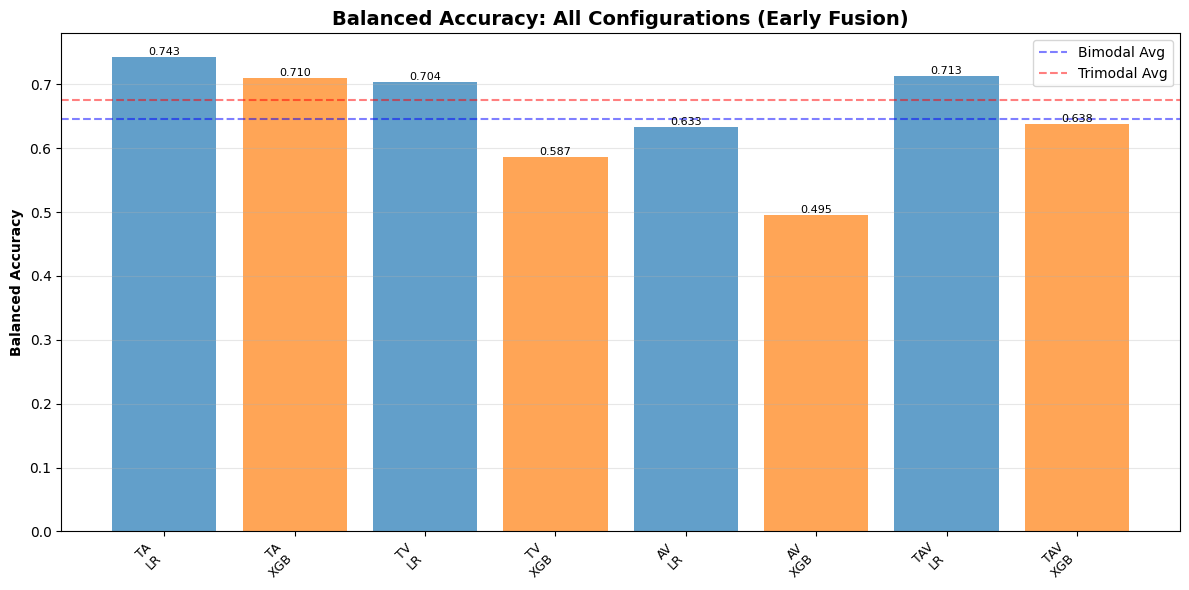

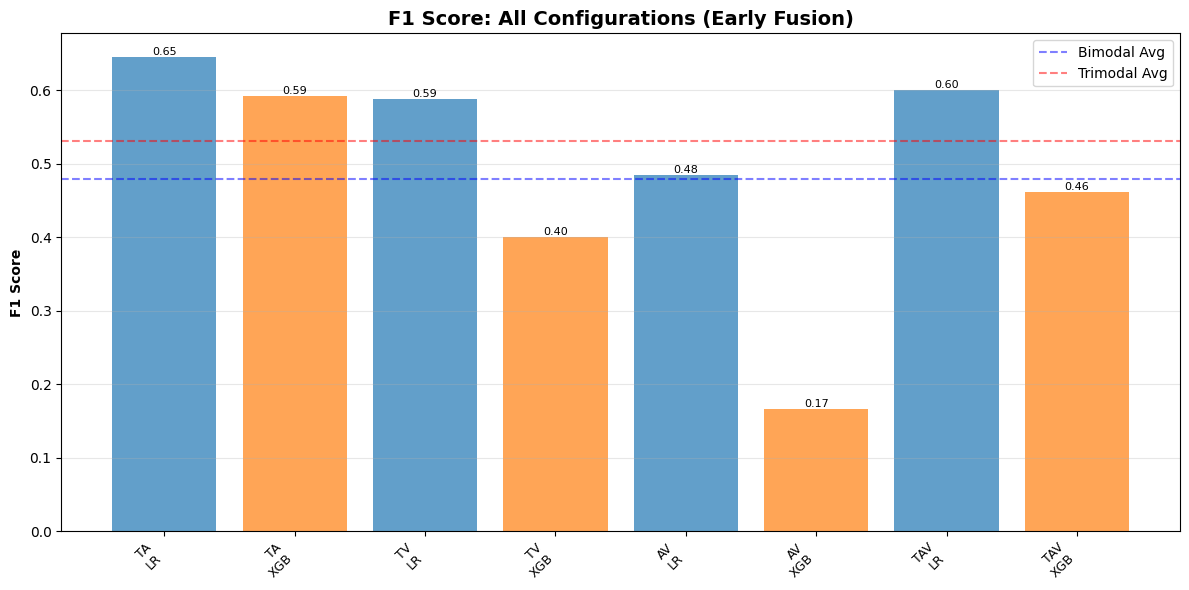

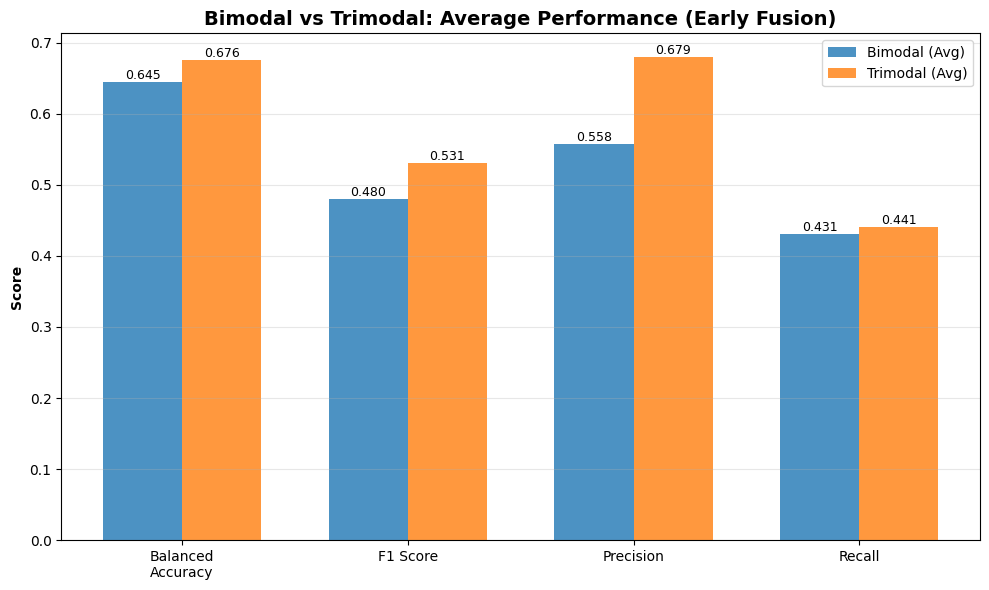

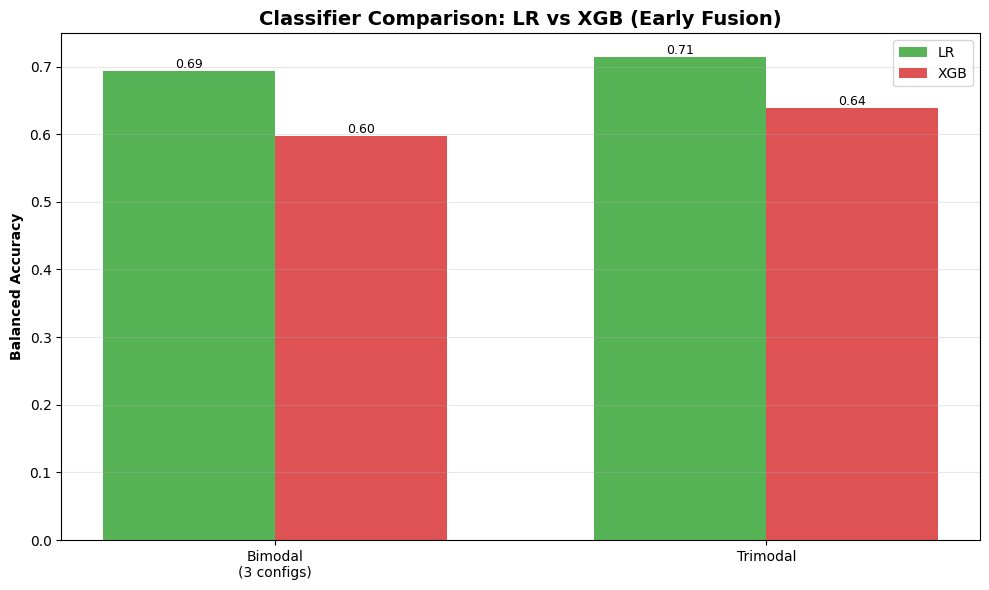

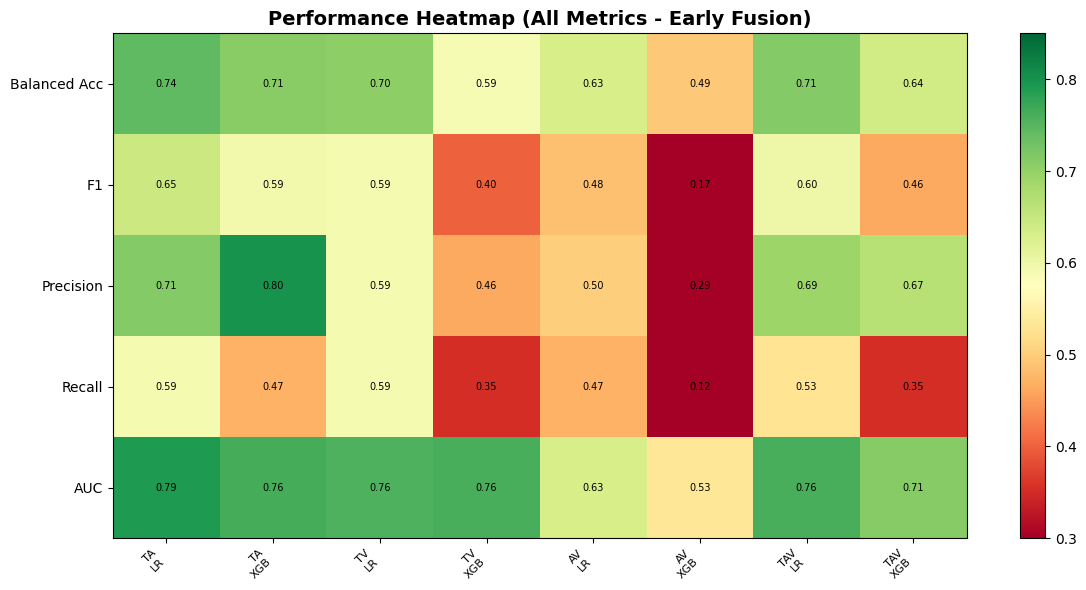

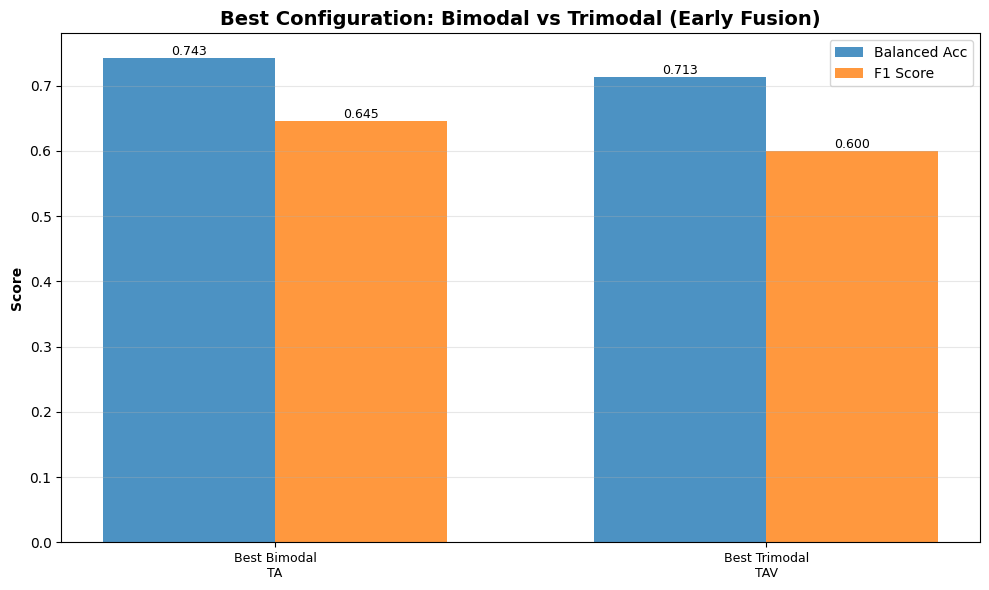

In [17]:
# Cell 21: VISUALIZATIONS - Bimodal vs Trimodal (MODIFIED - separate plots)

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: Balanced Accuracy by Configuration
fig1, ax1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(bimodal_trimodal_comparison))
colors = ['#1f77b4' if c == 'LR' else '#ff7f0e' for c in bimodal_trimodal_comparison['Classifier']]
bars1 = ax1.bar(x, bimodal_trimodal_comparison['Balanced_Acc'], color=colors, alpha=0.7)
ax1.set_ylabel('Balanced Accuracy', fontweight='bold')
ax1.set_title('Balanced Accuracy: All Configurations (Early Fusion)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{row['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')}\n{row['Classifier']}" 
                      for _, row in bimodal_trimodal_comparison.iterrows()], 
                     fontsize=9, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=bimodal_results['Balanced_Acc'].mean(), color='blue', 
            linestyle='--', alpha=0.5, label='Bimodal Avg')
ax1.axhline(y=trimodal_results['Balanced_Acc'].mean(), color='red', 
            linestyle='--', alpha=0.5, label='Trimodal Avg')
ax1.legend()
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Plot 2: F1 Score by Configuration
fig2, ax2 = plt.subplots(figsize=(12, 6))
bars2 = ax2.bar(x, bimodal_trimodal_comparison['F1'], color=colors, alpha=0.7)
ax2.set_ylabel('F1 Score', fontweight='bold')
ax2.set_title('F1 Score: All Configurations (Early Fusion)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{row['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')}\n{row['Classifier']}" 
                      for _, row in bimodal_trimodal_comparison.iterrows()], 
                     fontsize=9, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=bimodal_results['F1'].mean(), color='blue', 
            linestyle='--', alpha=0.5, label='Bimodal Avg')
ax2.axhline(y=trimodal_results['F1'].mean(), color='red', 
            linestyle='--', alpha=0.5, label='Trimodal Avg')
ax2.legend()
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Plot 3: Bimodal vs Trimodal Average Comparison
fig3, ax3 = plt.subplots(figsize=(10, 6))
categories = ['Balanced\nAccuracy', 'F1 Score', 'Precision', 'Recall']
bimodal_avgs = [
    bimodal_results['Balanced_Acc'].mean(),
    bimodal_results['F1'].mean(),
    bimodal_results['Precision'].mean(),
    bimodal_results['Recall'].mean()
]
trimodal_avgs = [
    trimodal_results['Balanced_Acc'].mean(),
    trimodal_results['F1'].mean(),
    trimodal_results['Precision'].mean(),
    trimodal_results['Recall'].mean()
]
x_cat = np.arange(len(categories))
width = 0.35
bars3a = ax3.bar(x_cat - width/2, bimodal_avgs, width, 
                 label='Bimodal (Avg)', alpha=0.8, color='#1f77b4')
bars3b = ax3.bar(x_cat + width/2, trimodal_avgs, width, 
                 label='Trimodal (Avg)', alpha=0.8, color='#ff7f0e')
ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Bimodal vs Trimodal: Average Performance (Early Fusion)', fontsize=14, fontweight='bold')
ax3.set_xticks(x_cat)
ax3.set_xticklabels(categories)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
for bars in [bars3a, bars3b]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Plot 4: LR vs XGB within Bimodal and Trimodal
fig4, ax4 = plt.subplots(figsize=(10, 6))
lr_bimodal = bimodal_results[bimodal_results['Classifier'] == 'LR']
xgb_bimodal = bimodal_results[bimodal_results['Classifier'] == 'XGB']
lr_trimodal = trimodal_results[trimodal_results['Classifier'] == 'LR']
xgb_trimodal = trimodal_results[trimodal_results['Classifier'] == 'XGB']
groups = ['Bimodal\n(3 configs)', 'Trimodal']
lr_scores = [lr_bimodal['Balanced_Acc'].mean(), lr_trimodal['Balanced_Acc'].mean()]
xgb_scores = [xgb_bimodal['Balanced_Acc'].mean(), xgb_trimodal['Balanced_Acc'].mean()]
x_grp = np.arange(len(groups))
bars4a = ax4.bar(x_grp - width/2, lr_scores, width, label='LR', alpha=0.8, color='#2ca02c')
bars4b = ax4.bar(x_grp + width/2, xgb_scores, width, label='XGB', alpha=0.8, color='#d62728')
ax4.set_ylabel('Balanced Accuracy', fontweight='bold')
ax4.set_title('Classifier Comparison: LR vs XGB (Early Fusion)', fontsize=14, fontweight='bold')
ax4.set_xticks(x_grp)
ax4.set_xticklabels(groups)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
for bars in [bars4a, bars4b]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Plot 5: Heatmap of all metrics
fig5, ax5 = plt.subplots(figsize=(12, 6))
metrics_data = bimodal_trimodal_comparison[['Balanced_Acc', 'F1', 'Precision', 'Recall', 'AUC']].values
im = ax5.imshow(metrics_data.T, cmap='RdYlGn', aspect='auto', vmin=0.3, vmax=0.85)
ax5.set_yticks(range(5))
ax5.set_yticklabels(['Balanced Acc', 'F1', 'Precision', 'Recall', 'AUC'])
ax5.set_xticks(range(len(bimodal_trimodal_comparison)))
ax5.set_xticklabels([f"{row['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')}\n{row['Classifier']}" 
                      for _, row in bimodal_trimodal_comparison.iterrows()], 
                     fontsize=8, rotation=45, ha='right')
ax5.set_title('Performance Heatmap (All Metrics - Early Fusion)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax5)
for i in range(metrics_data.shape[0]):
    for j in range(metrics_data.shape[1]):
        text = ax5.text(i, j, f'{metrics_data[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=7)
plt.tight_layout()
plt.show()

# Plot 6: Best configurations by modality
fig6, ax6 = plt.subplots(figsize=(10, 6))
best_bimodal = bimodal_results.loc[bimodal_results['Balanced_Acc'].idxmax()]
best_trimodal = trimodal_results.loc[trimodal_results['Balanced_Acc'].idxmax()]

# MODIFIED: Apply label shortening to configuration names
best_bimodal_label = best_bimodal['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')
best_trimodal_label = best_trimodal['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')

configs_best = [f'Best Bimodal\n{best_bimodal_label}', 
                f'Best Trimodal\n{best_trimodal_label}']

bal_acc_best = [best_bimodal['Balanced_Acc'], best_trimodal['Balanced_Acc']]
f1_best = [best_bimodal['F1'], best_trimodal['F1']]
x_best = np.arange(len(configs_best))
bars6a = ax6.bar(x_best - width/2, bal_acc_best, width, 
                 label='Balanced Acc', alpha=0.8, color='#1f77b4')
bars6b = ax6.bar(x_best + width/2, f1_best, width, 
                 label='F1 Score', alpha=0.8, color='#ff7f0e')
ax6.set_ylabel('Score', fontweight='bold')
ax6.set_title('Best Configuration: Bimodal vs Trimodal (Early Fusion)', fontsize=14, fontweight='bold')
ax6.set_xticks(x_best)
ax6.set_xticklabels(configs_best, fontsize=9)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)
for bars in [bars6a, bars6b]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig('/home/jonathanchan/ml_data/ThesisFinal/figures/img1.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

# 2. LATE FUSION

In [18]:
# Cell 23: Late Fusion 1 - Text + Audio - Logistic Regression

print("\n" + "="*70)
print("LATE FUSION 1: TEXT + AUDIO - LOGISTIC REGRESSION")
print("="*70)

# Split by modality
X_text_train = text_features[train_indices]
X_text_dev = text_features[dev_indices]
X_text_test = text_features[test_indices]

X_audio_train = audio_features[train_indices]
X_audio_dev = audio_features[dev_indices]
X_audio_test = audio_features[test_indices]

# Standardize text
scaler_text_late = StandardScaler()
X_text_train_scaled = scaler_text_late.fit_transform(X_text_train)
X_text_dev_scaled = scaler_text_late.transform(X_text_dev)
X_text_test_scaled = scaler_text_late.transform(X_text_test)

# Standardize audio
scaler_audio_late = StandardScaler()
X_audio_train_scaled = scaler_audio_late.fit_transform(X_audio_train)
X_audio_dev_scaled = scaler_audio_late.transform(X_audio_dev)
X_audio_test_scaled = scaler_audio_late.transform(X_audio_test)

# Train text model
print("Training Text model...")
lr_text = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=SEED,
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    C=1.0
)
lr_text.fit(X_text_train_scaled, y_train)

# Train audio model
print("Training Audio model...")
lr_audio = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=SEED,
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    C=1.0
)
lr_audio.fit(X_audio_train_scaled, y_train)

# Get predictions on test set
text_proba_test = lr_text.predict_proba(X_text_test_scaled)[:, 1]
audio_proba_test = lr_audio.predict_proba(X_audio_test_scaled)[:, 1]

# Average fusion
fused_proba_test = (text_proba_test + audio_proba_test) / 2
fused_pred_test = (fused_proba_test >= 0.5).astype(int)

test_metrics_lr_ta_late = {
    'accuracy': accuracy_score(y_test, fused_pred_test),
    'balanced_accuracy': balanced_accuracy_score(y_test, fused_pred_test),
    'f1': f1_score(y_test, fused_pred_test),
    'precision': precision_score(y_test, fused_pred_test),
    'recall': recall_score(y_test, fused_pred_test),
    'auc': roc_auc_score(y_test, fused_proba_test)
}

print("\nLATE FUSION RESULTS (Test Set):")
for metric, value in test_metrics_lr_ta_late.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, fused_pred_test))



LATE FUSION 1: TEXT + AUDIO - LOGISTIC REGRESSION
Training Text model...
Training Audio model...

LATE FUSION RESULTS (Test Set):
  Accuracy            : 0.7500
  Balanced_accuracy   : 0.6712
  F1                  : 0.5333
  Precision           : 0.6154
  Recall              : 0.4706
  Auc                 : 0.7511

Confusion Matrix (Test):
[[34  5]
 [ 9  8]]


In [19]:

# Cell 24: Late Fusion 2 - Text + Audio - XGBoost

print("\n" + "="*70)
print("LATE FUSION 2: TEXT + AUDIO - XGBOOST")
print("="*70)

# Use same scaled data from Cell 13
# Train text model
print("Training Text model...")
xgb_text = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    eval_metric='logloss',
    verbosity=1
)
xgb_text.fit(X_text_train_scaled, y_train)

# Train audio model
print("Training Audio model...")
xgb_audio = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    eval_metric='logloss',
    verbosity=1
)
xgb_audio.fit(X_audio_train_scaled, y_train)

# Get predictions on test set
text_proba_test_xgb = xgb_text.predict_proba(X_text_test_scaled)[:, 1]
audio_proba_test_xgb = xgb_audio.predict_proba(X_audio_test_scaled)[:, 1]

# Average fusion
fused_proba_test_xgb = (text_proba_test_xgb + audio_proba_test_xgb) / 2
fused_pred_test_xgb = (fused_proba_test_xgb >= 0.5).astype(int)

test_metrics_xgb_ta_late = {
    'accuracy': accuracy_score(y_test, fused_pred_test_xgb),
    'balanced_accuracy': balanced_accuracy_score(y_test, fused_pred_test_xgb),
    'f1': f1_score(y_test, fused_pred_test_xgb),
    'precision': precision_score(y_test, fused_pred_test_xgb),
    'recall': recall_score(y_test, fused_pred_test_xgb),
    'auc': roc_auc_score(y_test, fused_proba_test_xgb)
}

print("\nLATE FUSION RESULTS (Test Set):")
for metric, value in test_metrics_xgb_ta_late.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, fused_pred_test_xgb))



LATE FUSION 2: TEXT + AUDIO - XGBOOST
Training Text model...
Training Audio model...

LATE FUSION RESULTS (Test Set):
  Accuracy            : 0.6964
  Balanced_accuracy   : 0.5166
  F1                  : 0.1053
  Precision           : 0.5000
  Recall              : 0.0588
  Auc                 : 0.8115

Confusion Matrix (Test):
[[38  1]
 [16  1]]


In [20]:


# Cell 25: Late Fusion 3 - Text + Video - Logistic Regression

print("\n" + "="*70)
print("LATE FUSION 3: TEXT + VIDEO - LOGISTIC REGRESSION")
print("="*70)

# Split by modality
X_video_train = video_features[train_indices]
X_video_dev = video_features[dev_indices]
X_video_test = video_features[test_indices]

# Standardize video
scaler_video_late = StandardScaler()
X_video_train_scaled = scaler_video_late.fit_transform(X_video_train)
X_video_dev_scaled = scaler_video_late.transform(X_video_dev)
X_video_test_scaled = scaler_video_late.transform(X_video_test)

# Text model already trained in Cell 13, reuse lr_text

# Train video model
print("Training Video model...")
lr_video = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=SEED,
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    C=1.0
)
lr_video.fit(X_video_train_scaled, y_train)

# Get predictions on test set
text_proba_test_tv = lr_text.predict_proba(X_text_test_scaled)[:, 1]
video_proba_test = lr_video.predict_proba(X_video_test_scaled)[:, 1]

# Average fusion
fused_proba_test_tv = (text_proba_test_tv + video_proba_test) / 2
fused_pred_test_tv = (fused_proba_test_tv >= 0.5).astype(int)

test_metrics_lr_tv_late = {
    'accuracy': accuracy_score(y_test, fused_pred_test_tv),
    'balanced_accuracy': balanced_accuracy_score(y_test, fused_pred_test_tv),
    'f1': f1_score(y_test, fused_pred_test_tv),
    'precision': precision_score(y_test, fused_pred_test_tv),
    'recall': recall_score(y_test, fused_pred_test_tv),
    'auc': roc_auc_score(y_test, fused_proba_test_tv)
}

print("\nLATE FUSION RESULTS (Test Set):")
for metric, value in test_metrics_lr_tv_late.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, fused_pred_test_tv))



LATE FUSION 3: TEXT + VIDEO - LOGISTIC REGRESSION
Training Video model...

LATE FUSION RESULTS (Test Set):
  Accuracy            : 0.7857
  Balanced_accuracy   : 0.7466
  F1                  : 0.6471
  Precision           : 0.6471
  Recall              : 0.6471
  Auc                 : 0.7813

Confusion Matrix (Test):
[[33  6]
 [ 6 11]]


In [21]:

# Cell 26: Late Fusion 4 - Text + Video - XGBoost

print("\n" + "="*70)
print("LATE FUSION 4: TEXT + VIDEO - XGBOOST")
print("="*70)

# Text model already trained in Cell 14, reuse xgb_text

# Train video model
print("Training Video model...")
xgb_video = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    eval_metric='logloss',
    verbosity=1
)
xgb_video.fit(X_video_train_scaled, y_train)

# Get predictions on test set
text_proba_test_xgb_tv = xgb_text.predict_proba(X_text_test_scaled)[:, 1]
video_proba_test_xgb = xgb_video.predict_proba(X_video_test_scaled)[:, 1]

# Average fusion
fused_proba_test_xgb_tv = (text_proba_test_xgb_tv + video_proba_test_xgb) / 2
fused_pred_test_xgb_tv = (fused_proba_test_xgb_tv >= 0.5).astype(int)

test_metrics_xgb_tv_late = {
    'accuracy': accuracy_score(y_test, fused_pred_test_xgb_tv),
    'balanced_accuracy': balanced_accuracy_score(y_test, fused_pred_test_xgb_tv),
    'f1': f1_score(y_test, fused_pred_test_xgb_tv),
    'precision': precision_score(y_test, fused_pred_test_xgb_tv),
    'recall': recall_score(y_test, fused_pred_test_xgb_tv),
    'auc': roc_auc_score(y_test, fused_proba_test_xgb_tv)
}

print("\nLATE FUSION RESULTS (Test Set):")
for metric, value in test_metrics_xgb_tv_late.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, fused_pred_test_xgb_tv))



LATE FUSION 4: TEXT + VIDEO - XGBOOST
Training Video model...

LATE FUSION RESULTS (Test Set):
  Accuracy            : 0.6964
  Balanced_accuracy   : 0.5664
  F1                  : 0.3200
  Precision           : 0.5000
  Recall              : 0.2353
  Auc                 : 0.7632

Confusion Matrix (Test):
[[35  4]
 [13  4]]


In [22]:

# Cell 27: Late Fusion 5 - Audio + Video - Logistic Regression

print("\n" + "="*70)
print("LATE FUSION 5: AUDIO + VIDEO - LOGISTIC REGRESSION")
print("="*70)

# Audio and Video models already trained, reuse lr_audio and lr_video

# Get predictions on test set
audio_proba_test_av = lr_audio.predict_proba(X_audio_test_scaled)[:, 1]
video_proba_test_av = lr_video.predict_proba(X_video_test_scaled)[:, 1]

# Average fusion
fused_proba_test_av = (audio_proba_test_av + video_proba_test_av) / 2
fused_pred_test_av = (fused_proba_test_av >= 0.5).astype(int)

test_metrics_lr_av_late = {
    'accuracy': accuracy_score(y_test, fused_pred_test_av),
    'balanced_accuracy': balanced_accuracy_score(y_test, fused_pred_test_av),
    'f1': f1_score(y_test, fused_pred_test_av),
    'precision': precision_score(y_test, fused_pred_test_av),
    'recall': recall_score(y_test, fused_pred_test_av),
    'auc': roc_auc_score(y_test, fused_proba_test_av)
}

print("\nLATE FUSION RESULTS (Test Set):")
for metric, value in test_metrics_lr_av_late.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, fused_pred_test_av))



LATE FUSION 5: AUDIO + VIDEO - LOGISTIC REGRESSION

LATE FUSION RESULTS (Test Set):
  Accuracy            : 0.7857
  Balanced_accuracy   : 0.6968
  F1                  : 0.5714
  Precision           : 0.7273
  Recall              : 0.4706
  Auc                 : 0.5958

Confusion Matrix (Test):
[[36  3]
 [ 9  8]]


In [23]:

# Cell 28: Late Fusion 6 - Audio + Video - XGBoost

print("\n" + "="*70)
print("LATE FUSION 6: AUDIO + VIDEO - XGBOOST")
print("="*70)

# Audio and Video models already trained, reuse xgb_audio and xgb_video

# Get predictions on test set
audio_proba_test_xgb_av = xgb_audio.predict_proba(X_audio_test_scaled)[:, 1]
video_proba_test_xgb_av = xgb_video.predict_proba(X_video_test_scaled)[:, 1]

# Average fusion
fused_proba_test_xgb_av = (audio_proba_test_xgb_av + video_proba_test_xgb_av) / 2
fused_pred_test_xgb_av = (fused_proba_test_xgb_av >= 0.5).astype(int)

test_metrics_xgb_av_late = {
    'accuracy': accuracy_score(y_test, fused_pred_test_xgb_av),
    'balanced_accuracy': balanced_accuracy_score(y_test, fused_pred_test_xgb_av),
    'f1': f1_score(y_test, fused_pred_test_xgb_av),
    'precision': precision_score(y_test, fused_pred_test_xgb_av),
    'recall': recall_score(y_test, fused_pred_test_xgb_av),
    'auc': roc_auc_score(y_test, fused_proba_test_xgb_av)
}

print("\nLATE FUSION RESULTS (Test Set):")
for metric, value in test_metrics_xgb_av_late.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, fused_pred_test_xgb_av))



LATE FUSION 6: AUDIO + VIDEO - XGBOOST

LATE FUSION RESULTS (Test Set):
  Accuracy            : 0.6964
  Balanced_accuracy   : 0.5166
  F1                  : 0.1053
  Precision           : 0.5000
  Recall              : 0.0588
  Auc                 : 0.6199

Confusion Matrix (Test):
[[38  1]
 [16  1]]


In [24]:

# Cell 29: COMPREHENSIVE COMPARISON - BIMODAL RESULTS (Early + Late Fusion)

print("\n" + "="*70)
print("COMPREHENSIVE COMPARISON - ALL BIMODAL RESULTS")
print("Early Fusion + Late Fusion")
print("="*70)

# Create complete results table
all_results_complete = pd.DataFrame({
    'Configuration': [
        # Early Fusion
        'Text + Audio', 'Text + Audio',
        'Text + Video', 'Text + Video',
        'Audio + Video', 'Audio + Video',
        # Late Fusion
        'Text + Audio', 'Text + Audio',
        'Text + Video', 'Text + Video',
        'Audio + Video', 'Audio + Video'
    ],
    'Fusion': [
        # Early Fusion
        'Early', 'Early', 'Early', 'Early', 'Early', 'Early',
        # Late Fusion
        'Late', 'Late', 'Late', 'Late', 'Late', 'Late'
    ],
    'Classifier': [
        # Early Fusion
        'LR', 'XGB', 'LR', 'XGB', 'LR', 'XGB',
        # Late Fusion
        'LR', 'XGB', 'LR', 'XGB', 'LR', 'XGB'
    ],
    'Accuracy': [
        # Early Fusion
        test_metrics_lr_bi['accuracy'], test_metrics_xgb_bi['accuracy'],
        test_metrics_lr_tv['accuracy'], test_metrics_xgb_tv['accuracy'],
        test_metrics_lr_av['accuracy'], test_metrics_xgb_av['accuracy'],
        # Late Fusion
        test_metrics_lr_ta_late['accuracy'], test_metrics_xgb_ta_late['accuracy'],
        test_metrics_lr_tv_late['accuracy'], test_metrics_xgb_tv_late['accuracy'],
        test_metrics_lr_av_late['accuracy'], test_metrics_xgb_av_late['accuracy']
    ],
    'Balanced_Acc': [
        # Early Fusion
        test_metrics_lr_bi['balanced_accuracy'], test_metrics_xgb_bi['balanced_accuracy'],
        test_metrics_lr_tv['balanced_accuracy'], test_metrics_xgb_tv['balanced_accuracy'],
        test_metrics_lr_av['balanced_accuracy'], test_metrics_xgb_av['balanced_accuracy'],
        # Late Fusion
        test_metrics_lr_ta_late['balanced_accuracy'], test_metrics_xgb_ta_late['balanced_accuracy'],
        test_metrics_lr_tv_late['balanced_accuracy'], test_metrics_xgb_tv_late['balanced_accuracy'],
        test_metrics_lr_av_late['balanced_accuracy'], test_metrics_xgb_av_late['balanced_accuracy']
    ],
    'F1': [
        # Early Fusion
        test_metrics_lr_bi['f1'], test_metrics_xgb_bi['f1'],
        test_metrics_lr_tv['f1'], test_metrics_xgb_tv['f1'],
        test_metrics_lr_av['f1'], test_metrics_xgb_av['f1'],
        # Late Fusion
        test_metrics_lr_ta_late['f1'], test_metrics_xgb_ta_late['f1'],
        test_metrics_lr_tv_late['f1'], test_metrics_xgb_tv_late['f1'],
        test_metrics_lr_av_late['f1'], test_metrics_xgb_av_late['f1']
    ],
    'Precision': [
        # Early Fusion
        test_metrics_lr_bi['precision'], test_metrics_xgb_bi['precision'],
        test_metrics_lr_tv['precision'], test_metrics_xgb_tv['precision'],
        test_metrics_lr_av['precision'], test_metrics_xgb_av['precision'],
        # Late Fusion
        test_metrics_lr_ta_late['precision'], test_metrics_xgb_ta_late['precision'],
        test_metrics_lr_tv_late['precision'], test_metrics_xgb_tv_late['precision'],
        test_metrics_lr_av_late['precision'], test_metrics_xgb_av_late['precision']
    ],
    'Recall': [
        # Early Fusion
        test_metrics_lr_bi['recall'], test_metrics_xgb_bi['recall'],
        test_metrics_lr_tv['recall'], test_metrics_xgb_tv['recall'],
        test_metrics_lr_av['recall'], test_metrics_xgb_av['recall'],
        # Late Fusion
        test_metrics_lr_ta_late['recall'], test_metrics_xgb_ta_late['recall'],
        test_metrics_lr_tv_late['recall'], test_metrics_xgb_tv_late['recall'],
        test_metrics_lr_av_late['recall'], test_metrics_xgb_av_late['recall']
    ],
    'AUC': [
        # Early Fusion
        test_metrics_lr_bi['auc'], test_metrics_xgb_bi['auc'],
        test_metrics_lr_tv['auc'], test_metrics_xgb_tv['auc'],
        test_metrics_lr_av['auc'], test_metrics_xgb_av['auc'],
        # Late Fusion
        test_metrics_lr_ta_late['auc'], test_metrics_xgb_ta_late['auc'],
        test_metrics_lr_tv_late['auc'], test_metrics_xgb_tv_late['auc'],
        test_metrics_lr_av_late['auc'], test_metrics_xgb_av_late['auc']
    ]
})

print("\nCOMPLETE RESULTS TABLE (12 experiments):")
print(all_results_complete.to_string(index=False))

# Find best overall
best_idx_complete = all_results_complete['Balanced_Acc'].idxmax()
best_config_complete = all_results_complete.iloc[best_idx_complete]

print("\n" + "="*70)
print("BEST OVERALL CONFIGURATION (ALL BIMODAL EXPERIMENTS):")
print("="*70)
print(f"Configuration: {best_config_complete['Configuration']}")
print(f"Fusion:        {best_config_complete['Fusion']}")
print(f"Classifier:    {best_config_complete['Classifier']}")
print(f"Balanced Acc:  {best_config_complete['Balanced_Acc']:.4f}")
print(f"F1 Score:      {best_config_complete['F1']:.4f}")
print(f"Precision:     {best_config_complete['Precision']:.4f}")
print(f"Recall:        {best_config_complete['Recall']:.4f}")

# Early vs Late comparison
print("\n" + "="*70)
print("EARLY vs LATE FUSION COMPARISON:")
print("="*70)

early_results = all_results_complete[all_results_complete['Fusion'] == 'Early']
late_results = all_results_complete[all_results_complete['Fusion'] == 'Late']

print(f"\nEarly Fusion:")
print(f"  Avg Balanced Acc: {early_results['Balanced_Acc'].mean():.4f}")
print(f"  Avg F1:           {early_results['F1'].mean():.4f}")

print(f"\nLate Fusion:")
print(f"  Avg Balanced Acc: {late_results['Balanced_Acc'].mean():.4f}")
print(f"  Avg F1:           {late_results['F1'].mean():.4f}")

if early_results['Balanced_Acc'].mean() > late_results['Balanced_Acc'].mean():
    print("\n  → Early Fusion performs BETTER on average")
else:
    print("\n  → Late Fusion performs BETTER on average")

# LR vs XGB overall
print("\n" + "="*70)
print("LOGISTIC REGRESSION vs XGBOOST (OVERALL):")
print("="*70)

lr_results = all_results_complete[all_results_complete['Classifier'] == 'LR']
xgb_results = all_results_complete[all_results_complete['Classifier'] == 'XGB']

print(f"\nLogistic Regression:")
print(f"  Avg Balanced Acc: {lr_results['Balanced_Acc'].mean():.4f}")
print(f"  Avg F1:           {lr_results['F1'].mean():.4f}")

print(f"\nXGBoost:")
print(f"  Avg Balanced Acc: {xgb_results['Balanced_Acc'].mean():.4f}")
print(f"  Avg F1:           {xgb_results['F1'].mean():.4f}")

if lr_results['Balanced_Acc'].mean() > xgb_results['Balanced_Acc'].mean():
    print("\n  → Logistic Regression is BETTER overall! ✓")
else:
    print("\n  → XGBoost is BETTER overall! ✓")


COMPREHENSIVE COMPARISON - ALL BIMODAL RESULTS
Early Fusion + Late Fusion

COMPLETE RESULTS TABLE (12 experiments):
Configuration Fusion Classifier  Accuracy  Balanced_Acc       F1  Precision   Recall      AUC
 Text + Audio  Early         LR  0.803571      0.742836 0.645161   0.714286 0.588235 0.790347
 Text + Audio  Early        XGB  0.803571      0.709653 0.592593   0.800000 0.470588 0.763198
 Text + Video  Early         LR  0.750000      0.704374 0.588235   0.588235 0.588235 0.755656
 Text + Video  Early        XGB  0.678571      0.586727 0.400000   0.461538 0.352941 0.760181
Audio + Video  Early         LR  0.696429      0.632730 0.484848   0.500000 0.470588 0.631976
Audio + Video  Early        XGB  0.642857      0.494721 0.166667   0.285714 0.117647 0.533937
 Text + Audio   Late         LR  0.750000      0.671192 0.533333   0.615385 0.470588 0.751131
 Text + Audio   Late        XGB  0.696429      0.516591 0.105263   0.500000 0.058824 0.811463
 Text + Video   Late         LR  0.78

In [25]:
# Cell 30: Late Fusion - Trimodal (Text + Audio + Video) - Logistic Regression

print("\n" + "="*70)
print("LATE FUSION: TRIMODAL (TEXT + AUDIO + VIDEO) - LOGISTIC REGRESSION")
print("="*70)

# Get predictions from all three models on test set
text_proba_tri_lr = lr_text.predict_proba(X_text_test_scaled)[:, 1]
audio_proba_tri_lr = lr_audio.predict_proba(X_audio_test_scaled)[:, 1]
video_proba_tri_lr = lr_video.predict_proba(X_video_test_scaled)[:, 1]

# Average fusion (3 models)
fused_proba_tri_lr = (text_proba_tri_lr + audio_proba_tri_lr + video_proba_tri_lr) / 3
fused_pred_tri_lr = (fused_proba_tri_lr >= 0.5).astype(int)

test_metrics_lr_tri_late = {
    'accuracy': accuracy_score(y_test, fused_pred_tri_lr),
    'balanced_accuracy': balanced_accuracy_score(y_test, fused_pred_tri_lr),
    'f1': f1_score(y_test, fused_pred_tri_lr),
    'precision': precision_score(y_test, fused_pred_tri_lr),
    'recall': recall_score(y_test, fused_pred_tri_lr),
    'auc': roc_auc_score(y_test, fused_proba_tri_lr)
}

print("\nLATE FUSION RESULTS (Test Set):")
for metric, value in test_metrics_lr_tri_late.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, fused_pred_tri_lr))



LATE FUSION: TRIMODAL (TEXT + AUDIO + VIDEO) - LOGISTIC REGRESSION

LATE FUSION RESULTS (Test Set):
  Accuracy            : 0.7679
  Balanced_accuracy   : 0.6840
  F1                  : 0.5517
  Precision           : 0.6667
  Recall              : 0.4706
  Auc                 : 0.7511

Confusion Matrix (Test):
[[35  4]
 [ 9  8]]


In [26]:

# Cell 31: Late Fusion - Trimodal (Text + Audio + Video) - XGBoost

print("\n" + "="*70)
print("LATE FUSION: TRIMODAL (TEXT + AUDIO + VIDEO) - XGBOOST")
print("="*70)

# Reuse unimodal models trained earlier:
# xgb_text, xgb_audio, xgb_video (from Cells 14, 14, 16)

# Get predictions from all three models on test set
text_proba_tri_xgb = xgb_text.predict_proba(X_text_test_scaled)[:, 1]
audio_proba_tri_xgb = xgb_audio.predict_proba(X_audio_test_scaled)[:, 1]
video_proba_tri_xgb = xgb_video.predict_proba(X_video_test_scaled)[:, 1]

# Average fusion (3 models)
fused_proba_tri_xgb = (text_proba_tri_xgb + audio_proba_tri_xgb + video_proba_tri_xgb) / 3
fused_pred_tri_xgb = (fused_proba_tri_xgb >= 0.5).astype(int)

test_metrics_xgb_tri_late = {
    'accuracy': accuracy_score(y_test, fused_pred_tri_xgb),
    'balanced_accuracy': balanced_accuracy_score(y_test, fused_pred_tri_xgb),
    'f1': f1_score(y_test, fused_pred_tri_xgb),
    'precision': precision_score(y_test, fused_pred_tri_xgb),
    'recall': recall_score(y_test, fused_pred_tri_xgb),
    'auc': roc_auc_score(y_test, fused_proba_tri_xgb)
}

print("\nLATE FUSION RESULTS (Test Set):")
for metric, value in test_metrics_xgb_tri_late.items():
    print(f"  {metric.capitalize():20s}: {value:.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, fused_pred_tri_xgb))



LATE FUSION: TRIMODAL (TEXT + AUDIO + VIDEO) - XGBOOST

LATE FUSION RESULTS (Test Set):
  Accuracy            : 0.7500
  Balanced_accuracy   : 0.5882
  F1                  : 0.3000
  Precision           : 1.0000
  Recall              : 0.1765
  Auc                 : 0.7662

Confusion Matrix (Test):
[[39  0]
 [14  3]]


In [27]:

# Cell 32: BIMODAL vs TRIMODAL COMPARISON (Late Fusion Only)

print("\n" + "="*70)
print("BIMODAL vs TRIMODAL COMPARISON (LATE FUSION ONLY)")
print("="*70)

# Create comparison table for late fusion
bimodal_trimodal_late = pd.DataFrame({
    'Configuration': [
        'Text + Audio', 'Text + Audio',
        'Text + Video', 'Text + Video',
        'Audio + Video', 'Audio + Video',
        'Text + Audio + Video', 'Text + Audio + Video'
    ],
    'Modality': [
        'Bimodal', 'Bimodal',
        'Bimodal', 'Bimodal',
        'Bimodal', 'Bimodal',
        'Trimodal', 'Trimodal'
    ],
    'Classifier': ['LR', 'XGB', 'LR', 'XGB', 'LR', 'XGB', 'LR', 'XGB'],
    'Accuracy': [
        test_metrics_lr_ta_late['accuracy'], test_metrics_xgb_ta_late['accuracy'],
        test_metrics_lr_tv_late['accuracy'], test_metrics_xgb_tv_late['accuracy'],
        test_metrics_lr_av_late['accuracy'], test_metrics_xgb_av_late['accuracy'],
        test_metrics_lr_tri_late['accuracy'], test_metrics_xgb_tri_late['accuracy']
    ],
    'Balanced_Acc': [
        test_metrics_lr_ta_late['balanced_accuracy'], test_metrics_xgb_ta_late['balanced_accuracy'],
        test_metrics_lr_tv_late['balanced_accuracy'], test_metrics_xgb_tv_late['balanced_accuracy'],
        test_metrics_lr_av_late['balanced_accuracy'], test_metrics_xgb_av_late['balanced_accuracy'],
        test_metrics_lr_tri_late['balanced_accuracy'], test_metrics_xgb_tri_late['balanced_accuracy']
    ],
    'F1': [
        test_metrics_lr_ta_late['f1'], test_metrics_xgb_ta_late['f1'],
        test_metrics_lr_tv_late['f1'], test_metrics_xgb_tv_late['f1'],
        test_metrics_lr_av_late['f1'], test_metrics_xgb_av_late['f1'],
        test_metrics_lr_tri_late['f1'], test_metrics_xgb_tri_late['f1']
    ],
    'Precision': [
        test_metrics_lr_ta_late['precision'], test_metrics_xgb_ta_late['precision'],
        test_metrics_lr_tv_late['precision'], test_metrics_xgb_tv_late['precision'],
        test_metrics_lr_av_late['precision'], test_metrics_xgb_av_late['precision'],
        test_metrics_lr_tri_late['precision'], test_metrics_xgb_tri_late['precision']
    ],
    'Recall': [
        test_metrics_lr_ta_late['recall'], test_metrics_xgb_ta_late['recall'],
        test_metrics_lr_tv_late['recall'], test_metrics_xgb_tv_late['recall'],
        test_metrics_lr_av_late['recall'], test_metrics_xgb_av_late['recall'],
        test_metrics_lr_tri_late['recall'], test_metrics_xgb_tri_late['recall']
    ],
    'AUC': [
        test_metrics_lr_ta_late['auc'], test_metrics_xgb_ta_late['auc'],
        test_metrics_lr_tv_late['auc'], test_metrics_xgb_tv_late['auc'],
        test_metrics_lr_av_late['auc'], test_metrics_xgb_av_late['auc'],
        test_metrics_lr_tri_late['auc'], test_metrics_xgb_tri_late['auc']
    ]
})

print("\nCOMPLETE COMPARISON TABLE (LATE FUSION):")
print(bimodal_trimodal_late.to_string(index=False))

# Aggregate analysis
print("\n" + "="*70)
print("BIMODAL vs TRIMODAL AGGREGATE ANALYSIS (LATE FUSION):")
print("="*70)

bimodal_late_results = bimodal_trimodal_late[bimodal_trimodal_late['Modality'] == 'Bimodal']
trimodal_late_results = bimodal_trimodal_late[bimodal_trimodal_late['Modality'] == 'Trimodal']

print(f"\nBimodal Late Fusion (Average across 6 experiments):")
print(f"  Avg Balanced Acc: {bimodal_late_results['Balanced_Acc'].mean():.4f}")
print(f"  Avg F1:           {bimodal_late_results['F1'].mean():.4f}")
print(f"  Best Bal Acc:     {bimodal_late_results['Balanced_Acc'].max():.4f}")
print(f"  Best F1:          {bimodal_late_results['F1'].max():.4f}")

print(f"\nTrimodal Late Fusion (2 experiments):")
print(f"  Avg Balanced Acc: {trimodal_late_results['Balanced_Acc'].mean():.4f}")
print(f"  Avg F1:           {trimodal_late_results['F1'].mean():.4f}")
print(f"  Best Bal Acc:     {trimodal_late_results['Balanced_Acc'].max():.4f}")
print(f"  Best F1:          {trimodal_late_results['F1'].max():.4f}")

# Determine if adding video helps in late fusion
if trimodal_late_results['Balanced_Acc'].max() > bimodal_late_results['Balanced_Acc'].max():
    print("\n  → Adding video in late fusion IMPROVES performance ✓")
elif trimodal_late_results['Balanced_Acc'].max() < bimodal_late_results['Balanced_Acc'].max():
    print("\n  → Adding video in late fusion WORSENS performance ✗")
else:
    print("\n  → Adding video in late fusion has NO significant impact")

# Best overall (late fusion)
best_idx_late = bimodal_trimodal_late['Balanced_Acc'].idxmax()
best_config_late = bimodal_trimodal_late.iloc[best_idx_late]

print("\n" + "="*70)
print("BEST OVERALL CONFIGURATION (LATE FUSION):")
print("="*70)
print(f"Configuration: {best_config_late['Configuration']}")
print(f"Modality:      {best_config_late['Modality']}")
print(f"Classifier:    {best_config_late['Classifier']}")
print(f"Balanced Acc:  {best_config_late['Balanced_Acc']:.4f}")
print(f"F1 Score:      {best_config_late['F1']:.4f}")



BIMODAL vs TRIMODAL COMPARISON (LATE FUSION ONLY)

COMPLETE COMPARISON TABLE (LATE FUSION):
       Configuration Modality Classifier  Accuracy  Balanced_Acc       F1  Precision   Recall      AUC
        Text + Audio  Bimodal         LR  0.750000      0.671192 0.533333   0.615385 0.470588 0.751131
        Text + Audio  Bimodal        XGB  0.696429      0.516591 0.105263   0.500000 0.058824 0.811463
        Text + Video  Bimodal         LR  0.785714      0.746606 0.647059   0.647059 0.647059 0.781297
        Text + Video  Bimodal        XGB  0.696429      0.566365 0.320000   0.500000 0.235294 0.763198
       Audio + Video  Bimodal         LR  0.785714      0.696833 0.571429   0.727273 0.470588 0.595777
       Audio + Video  Bimodal        XGB  0.696429      0.516591 0.105263   0.500000 0.058824 0.619910
Text + Audio + Video Trimodal         LR  0.767857      0.684012 0.551724   0.666667 0.470588 0.751131
Text + Audio + Video Trimodal        XGB  0.750000      0.588235 0.300000   1.00000


GENERATING VISUALIZATIONS (LATE FUSION)


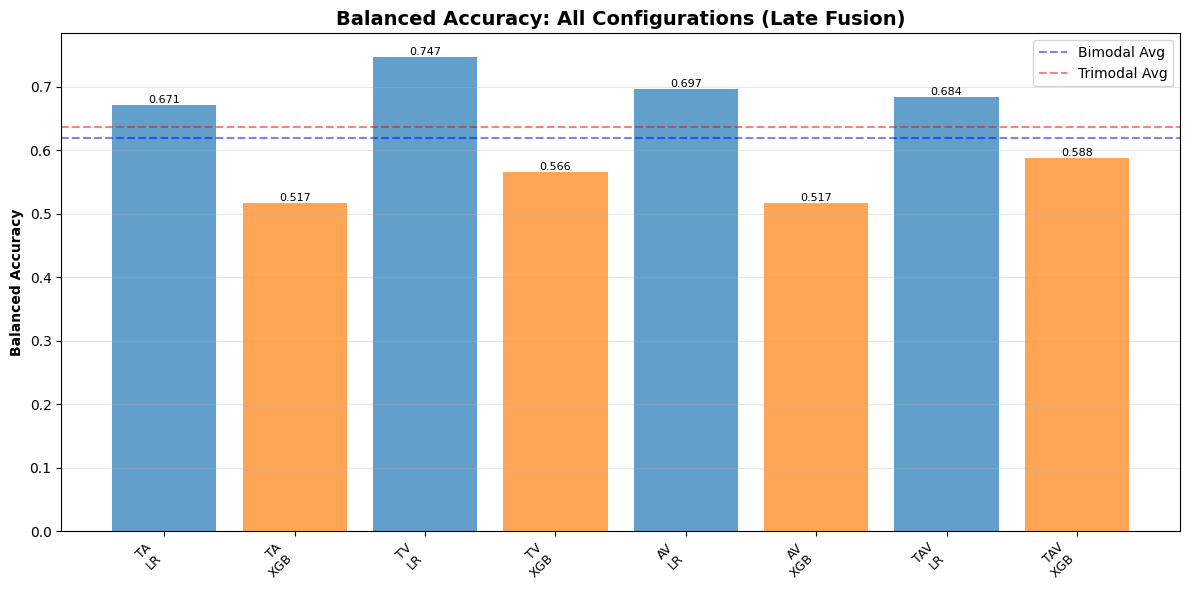

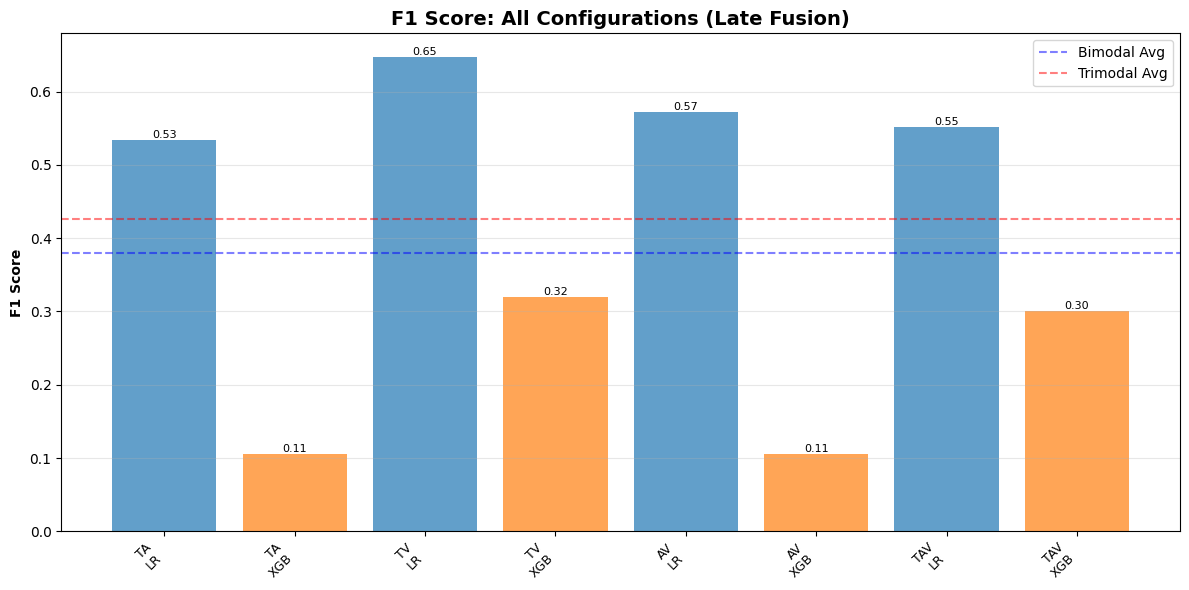

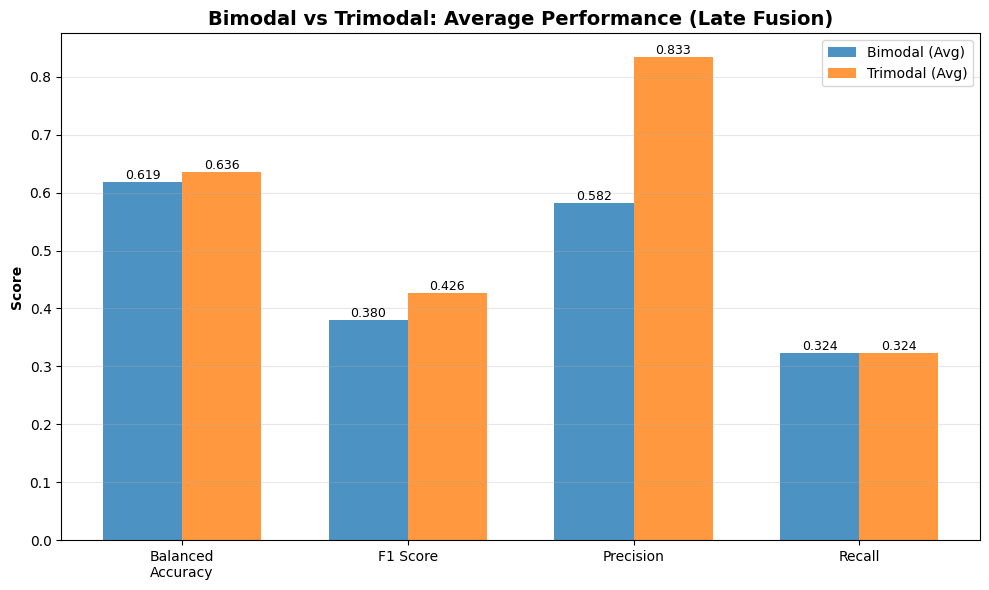

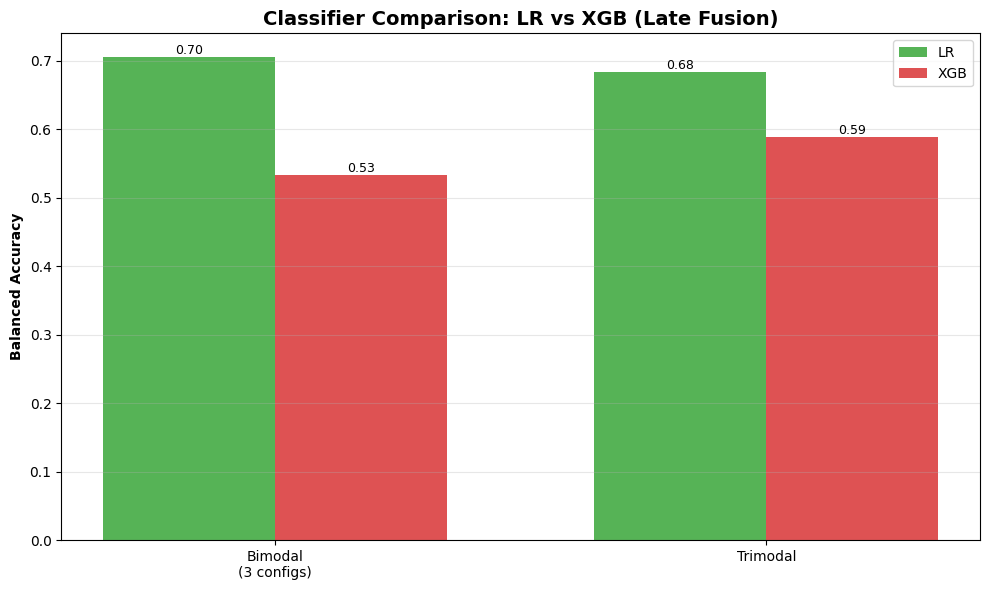

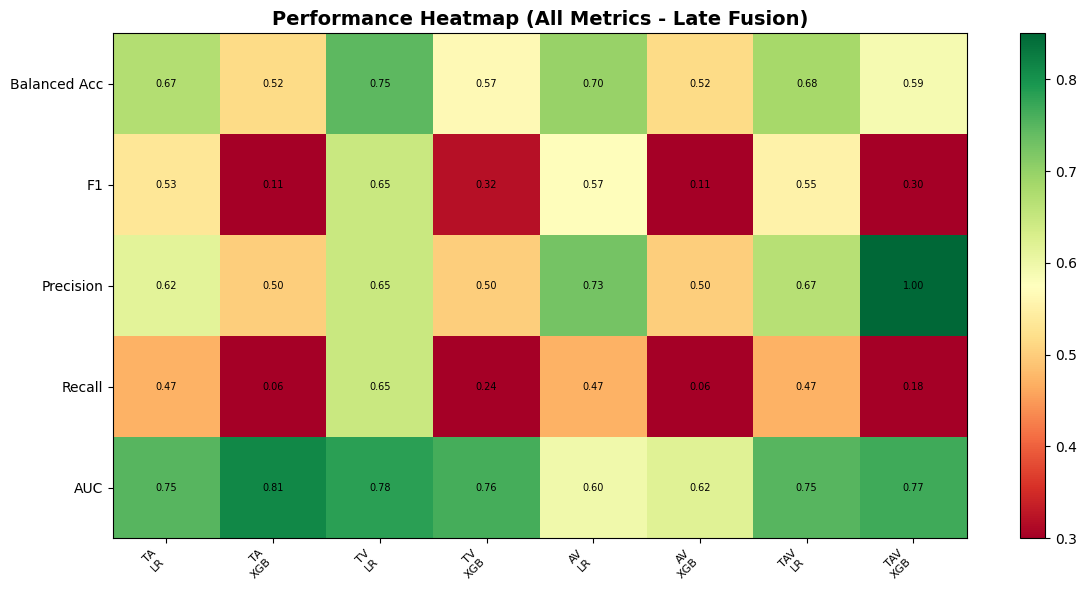

Plot 6 saved as img2.png and img2.pdf


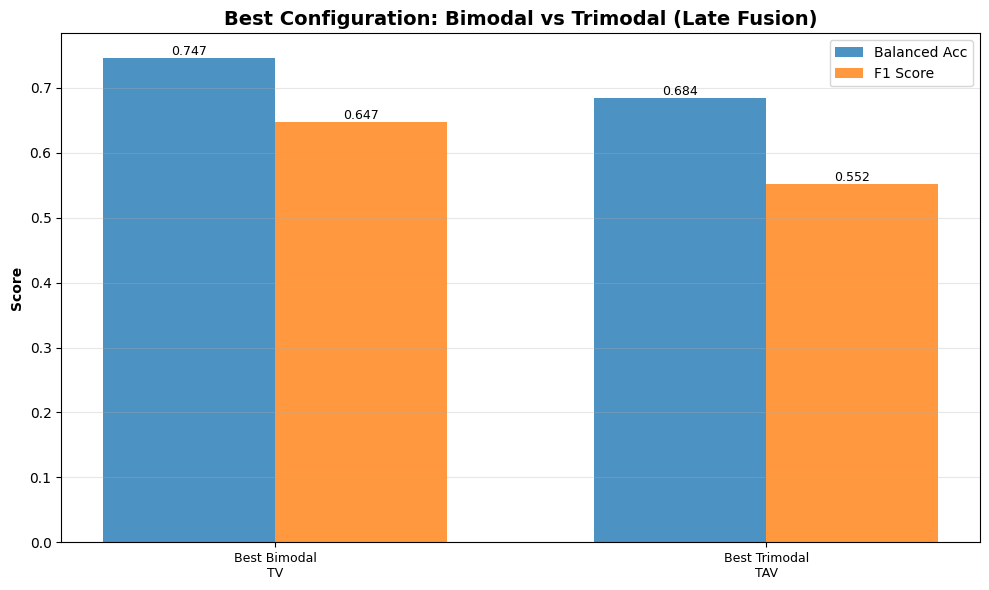

In [28]:
# Cell 33: VISUALIZATIONS - Bimodal vs Trimodal (Late Fusion) (MODIFIED - separate plots)

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS (LATE FUSION)")
print("="*70)

# Plot 1: Balanced Accuracy by Configuration
fig1, ax1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(bimodal_trimodal_late))
colors = ['#1f77b4' if c == 'LR' else '#ff7f0e' for c in bimodal_trimodal_late['Classifier']]
bars1 = ax1.bar(x, bimodal_trimodal_late['Balanced_Acc'], color=colors, alpha=0.7)
ax1.set_ylabel('Balanced Accuracy', fontweight='bold')
ax1.set_title('Balanced Accuracy: All Configurations (Late Fusion)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{row['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')}\n{row['Classifier']}" 
                      for _, row in bimodal_trimodal_late.iterrows()], 
                     fontsize=9, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=bimodal_late_results['Balanced_Acc'].mean(), color='blue', 
            linestyle='--', alpha=0.5, label='Bimodal Avg')
ax1.axhline(y=trimodal_late_results['Balanced_Acc'].mean(), color='red', 
            linestyle='--', alpha=0.5, label='Trimodal Avg')
ax1.legend()
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Plot 2: F1 Score by Configuration
fig2, ax2 = plt.subplots(figsize=(12, 6))
bars2 = ax2.bar(x, bimodal_trimodal_late['F1'], color=colors, alpha=0.7)
ax2.set_ylabel('F1 Score', fontweight='bold')
ax2.set_title('F1 Score: All Configurations (Late Fusion)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{row['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')}\n{row['Classifier']}" 
                      for _, row in bimodal_trimodal_late.iterrows()], 
                     fontsize=9, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=bimodal_late_results['F1'].mean(), color='blue', 
            linestyle='--', alpha=0.5, label='Bimodal Avg')
ax2.axhline(y=trimodal_late_results['F1'].mean(), color='red', 
            linestyle='--', alpha=0.5, label='Trimodal Avg')
ax2.legend()
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Plot 3: Bimodal vs Trimodal Average Comparison
fig3, ax3 = plt.subplots(figsize=(10, 6))
categories = ['Balanced\nAccuracy', 'F1 Score', 'Precision', 'Recall']
bimodal_late_avgs = [
    bimodal_late_results['Balanced_Acc'].mean(),
    bimodal_late_results['F1'].mean(),
    bimodal_late_results['Precision'].mean(),
    bimodal_late_results['Recall'].mean()
]
trimodal_late_avgs = [
    trimodal_late_results['Balanced_Acc'].mean(),
    trimodal_late_results['F1'].mean(),
    trimodal_late_results['Precision'].mean(),
    trimodal_late_results['Recall'].mean()
]
x_cat = np.arange(len(categories))
width = 0.35
bars3a = ax3.bar(x_cat - width/2, bimodal_late_avgs, width, 
                 label='Bimodal (Avg)', alpha=0.8, color='#1f77b4')
bars3b = ax3.bar(x_cat + width/2, trimodal_late_avgs, width, 
                 label='Trimodal (Avg)', alpha=0.8, color='#ff7f0e')
ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Bimodal vs Trimodal: Average Performance (Late Fusion)', fontsize=14, fontweight='bold')
ax3.set_xticks(x_cat)
ax3.set_xticklabels(categories)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
for bars in [bars3a, bars3b]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Plot 4: LR vs XGB within Bimodal and Trimodal
fig4, ax4 = plt.subplots(figsize=(10, 6))
lr_bimodal_late = bimodal_late_results[bimodal_late_results['Classifier'] == 'LR']
xgb_bimodal_late = bimodal_late_results[bimodal_late_results['Classifier'] == 'XGB']
lr_trimodal_late = trimodal_late_results[trimodal_late_results['Classifier'] == 'LR']
xgb_trimodal_late = trimodal_late_results[trimodal_late_results['Classifier'] == 'XGB']
groups = ['Bimodal\n(3 configs)', 'Trimodal']
lr_scores_late = [lr_bimodal_late['Balanced_Acc'].mean(), lr_trimodal_late['Balanced_Acc'].mean()]
xgb_scores_late = [xgb_bimodal_late['Balanced_Acc'].mean(), xgb_trimodal_late['Balanced_Acc'].mean()]
x_grp = np.arange(len(groups))
bars4a = ax4.bar(x_grp - width/2, lr_scores_late, width, label='LR', alpha=0.8, color='#2ca02c')
bars4b = ax4.bar(x_grp + width/2, xgb_scores_late, width, label='XGB', alpha=0.8, color='#d62728')
ax4.set_ylabel('Balanced Accuracy', fontweight='bold')
ax4.set_title('Classifier Comparison: LR vs XGB (Late Fusion)', fontsize=14, fontweight='bold')
ax4.set_xticks(x_grp)
ax4.set_xticklabels(groups)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
for bars in [bars4a, bars4b]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Plot 5: Heatmap of all metrics
fig5, ax5 = plt.subplots(figsize=(12, 6))
metrics_data_late = bimodal_trimodal_late[['Balanced_Acc', 'F1', 'Precision', 'Recall', 'AUC']].values
im = ax5.imshow(metrics_data_late.T, cmap='RdYlGn', aspect='auto', vmin=0.3, vmax=0.85)
ax5.set_yticks(range(5))
ax5.set_yticklabels(['Balanced Acc', 'F1', 'Precision', 'Recall', 'AUC'])
ax5.set_xticks(range(len(bimodal_trimodal_late)))
ax5.set_xticklabels([f"{row['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')}\n{row['Classifier']}" 
                      for _, row in bimodal_trimodal_late.iterrows()], 
                     fontsize=8, rotation=45, ha='right')
ax5.set_title('Performance Heatmap (All Metrics - Late Fusion)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax5)
for i in range(metrics_data_late.shape[0]):
    for j in range(metrics_data_late.shape[1]):
        text = ax5.text(i, j, f'{metrics_data_late[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=7)
plt.tight_layout()
plt.show()

# Plot 6: Best configurations by modality
fig6, ax6 = plt.subplots(figsize=(10, 6))
best_bimodal_late = bimodal_late_results.loc[bimodal_late_results['Balanced_Acc'].idxmax()]
best_trimodal_late = trimodal_late_results.loc[trimodal_late_results['Balanced_Acc'].idxmax()]

# MODIFIED: Apply label shortening to configuration names
best_bimodal_late_label = best_bimodal_late['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')
best_trimodal_late_label = best_trimodal_late['Configuration'].replace('Text + Audio + Video', 'TAV').replace('Text + Audio', 'TA').replace('Text + Video', 'TV').replace('Audio + Video', 'AV')

configs_best = [f'Best Bimodal\n{best_bimodal_late_label}', 
                f'Best Trimodal\n{best_trimodal_late_label}']

bal_acc_best = [best_bimodal_late['Balanced_Acc'], best_trimodal_late['Balanced_Acc']]
f1_best = [best_bimodal_late['F1'], best_trimodal_late['F1']]
x_best = np.arange(len(configs_best))
bars6a = ax6.bar(x_best - width/2, bal_acc_best, width, 
                 label='Balanced Acc', alpha=0.8, color='#1f77b4')
bars6b = ax6.bar(x_best + width/2, f1_best, width, 
                 label='F1 Score', alpha=0.8, color='#ff7f0e')
ax6.set_ylabel('Score', fontweight='bold')
ax6.set_title('Best Configuration: Bimodal vs Trimodal (Late Fusion)', fontsize=14, fontweight='bold')
ax6.set_xticks(x_best)
ax6.set_xticklabels(configs_best, fontsize=9)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)
for bars in [bars6a, bars6b]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()

# Save plot 6 as img2 (PNG and PDF)
fig6.savefig('/home/jonathanchan/ml_data/ThesisFinal/figures/img2.png', dpi=300, bbox_inches='tight')
fig6.savefig('/home/jonathanchan/ml_data/ThesisFinal/figures/img2.pdf', bbox_inches='tight')
print("Plot 6 saved as img2.png and img2.pdf")

plt.show()

# 3. INTERPRETABILITY (TEXT + AUDIO)

In [29]:


# Cell 34: Import SHAP and additional libraries for interpretability

import shap
import lime
import lime.lime_tabular

print("\n" + "="*70)
print("INTERPRETABILITY ANALYSIS")
print("="*70)
print("Importing interpretability libraries...")
print("✓ SHAP imported")
print("✓ LIME imported")


INTERPRETABILITY ANALYSIS
Importing interpretability libraries...
✓ SHAP imported
✓ LIME imported



LOGISTIC REGRESSION: COEFFICIENT ANALYSIS

Analyzing best LR model: Text + Audio (Early Fusion)

Top 20 Most Important Features (by absolute coefficient):
  Feature  Coefficient  Abs_Coefficient Modality
 Text_251     0.345788         0.345788     Text
 Text_324    -0.317977         0.317977     Text
 Text_594    -0.312691         0.312691     Text
 Text_291    -0.300782         0.300782     Text
 Text_408     0.299976         0.299976     Text
 Text_379     0.288662         0.288662     Text
 Text_758    -0.284004         0.284004     Text
 Text_145     0.279369         0.279369     Text
 Text_122     0.274761         0.274761     Text
Audio_327     0.267454         0.267454    Audio
 Text_645    -0.262644         0.262644     Text
 Text_209     0.260916         0.260916     Text
 Text_346    -0.245428         0.245428     Text
 Text_663    -0.234106         0.234106     Text
 Audio_33     0.228415         0.228415    Audio
 Text_600    -0.223518         0.223518     Text
Audio_323  

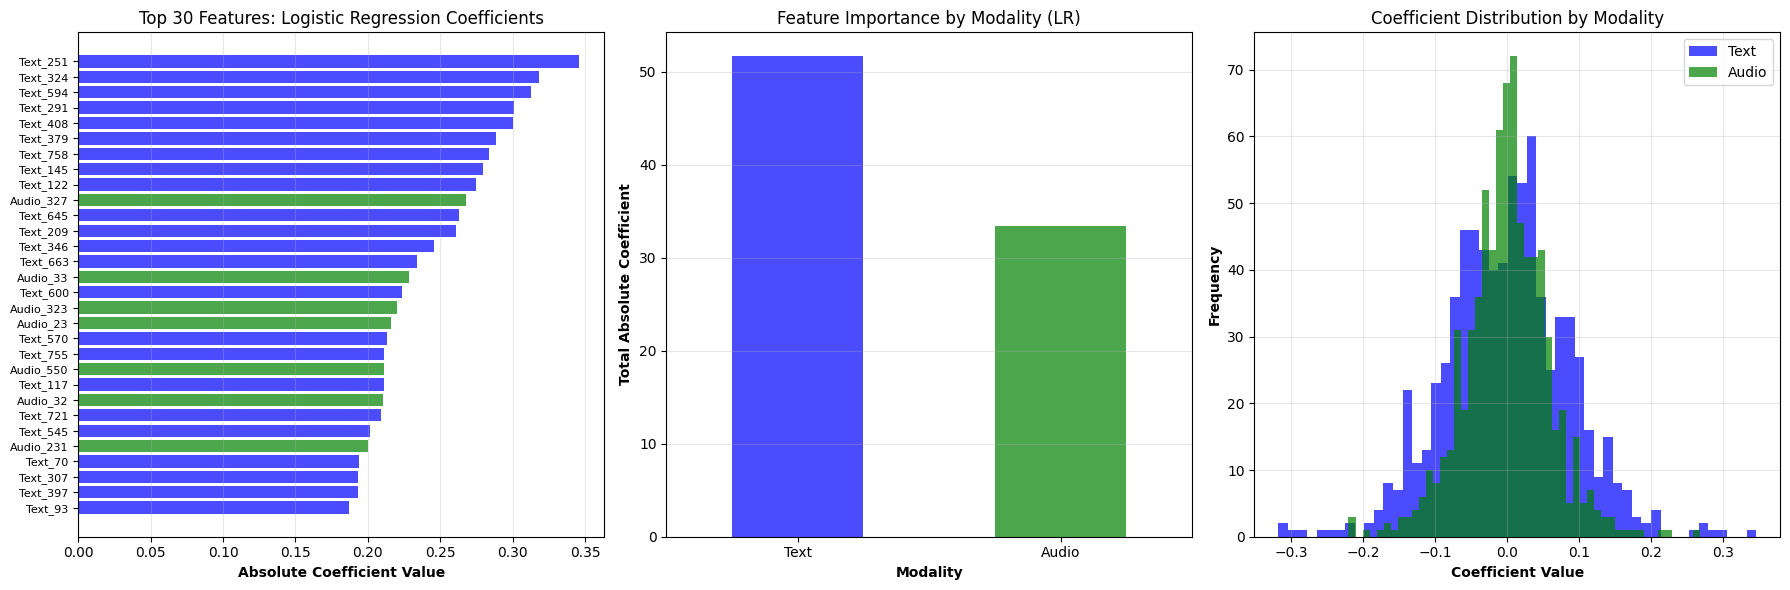

In [30]:
# Cell 35: Logistic Regression Feature Importance (Coefficients)

print("\n" + "="*70)
print("LOGISTIC REGRESSION: COEFFICIENT ANALYSIS")
print("="*70)

# Use the best performing LR model (Text + Audio early fusion)
print("\nAnalyzing best LR model: Text + Audio (Early Fusion)")

# Get feature names
text_dim = text_features.shape[1]
audio_dim = audio_features.shape[1]
feature_names_bi = [f'Text_{i}' for i in range(text_dim)] + \
                   [f'Audio_{i}' for i in range(audio_dim)]

# Get coefficients
lr_coefficients = lr_bi.coef_[0]  # Shape: (n_features,)

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names_bi,
    'Coefficient': lr_coefficients,
    'Abs_Coefficient': np.abs(lr_coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Determine modality
coef_df['Modality'] = coef_df['Feature'].apply(
    lambda x: 'Text' if x.startswith('Text') else 'Audio'
)

# Top 20 features
print("\nTop 20 Most Important Features (by absolute coefficient):")
print(coef_df.head(20).to_string(index=False))

# Aggregate by modality
modality_importance_lr = coef_df.groupby('Modality')['Abs_Coefficient'].sum().sort_values(ascending=False)
print("\n" + "="*70)
print("Coefficient Importance by Modality:")
print("="*70)
for modality, importance in modality_importance_lr.items():
    percentage = (importance / coef_df['Abs_Coefficient'].sum()) * 100
    print(f"{modality}: {importance:.4f} ({percentage:.2f}%)")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Top 30 features
ax1 = axes[0]
top_30_lr = coef_df.head(30)
colors_lr = ['blue' if mod == 'Text' else 'green' for mod in top_30_lr['Modality']]
ax1.barh(range(len(top_30_lr)), top_30_lr['Abs_Coefficient'], color=colors_lr, alpha=0.7)
ax1.set_yticks(range(len(top_30_lr)))
ax1.set_yticklabels(top_30_lr['Feature'], fontsize=8)
ax1.set_xlabel('Absolute Coefficient Value', fontweight='bold')
ax1.set_title('Top 30 Features: Logistic Regression Coefficients')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Modality comparison
ax2 = axes[1]
modality_importance_lr.plot(kind='bar', ax=ax2, color=['blue', 'green'], alpha=0.7)
ax2.set_xlabel('Modality', fontweight='bold')
ax2.set_ylabel('Total Absolute Coefficient', fontweight='bold')
ax2.set_title('Feature Importance by Modality (LR)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Coefficient distribution
ax3 = axes[2]
ax3.hist(coef_df[coef_df['Modality'] == 'Text']['Coefficient'], 
         bins=50, alpha=0.7, label='Text', color='blue')
ax3.hist(coef_df[coef_df['Modality'] == 'Audio']['Coefficient'], 
         bins=50, alpha=0.7, label='Audio', color='green')
ax3.set_xlabel('Coefficient Value', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Coefficient Distribution by Modality')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/lr_coefficient_importance.png', dpi=300, bbox_inches='tight')
# print(f"\n✓ Saved: lr_coefficient_importance.png")
plt.show()


XGBOOST: BUILT-IN FEATURE IMPORTANCE

Analyzing best XGBoost model: Text + Audio (Early Fusion)

Top 20 Most Important Features:
  Feature  Importance Modality
 Text_595    0.024611     Text
 Text_258    0.022000     Text
  Text_97    0.018399     Text
  Text_61    0.018338     Text
 Text_337    0.018163     Text
Audio_724    0.017171    Audio
 Text_577    0.016575     Text
  Text_31    0.016205     Text
 Text_678    0.015953     Text
 Text_569    0.015635     Text
 Text_683    0.015433     Text
Audio_398    0.014717    Audio
 Audio_33    0.014078    Audio
 Text_146    0.013860     Text
Audio_627    0.013512    Audio
  Text_80    0.013261     Text
 Text_491    0.013056     Text
 Text_407    0.012855     Text
 Text_716    0.012679     Text
  Text_42    0.012535     Text

Feature Importance by Modality:
Text: 0.7167 (71.67%)
Audio: 0.2833 (28.33%)


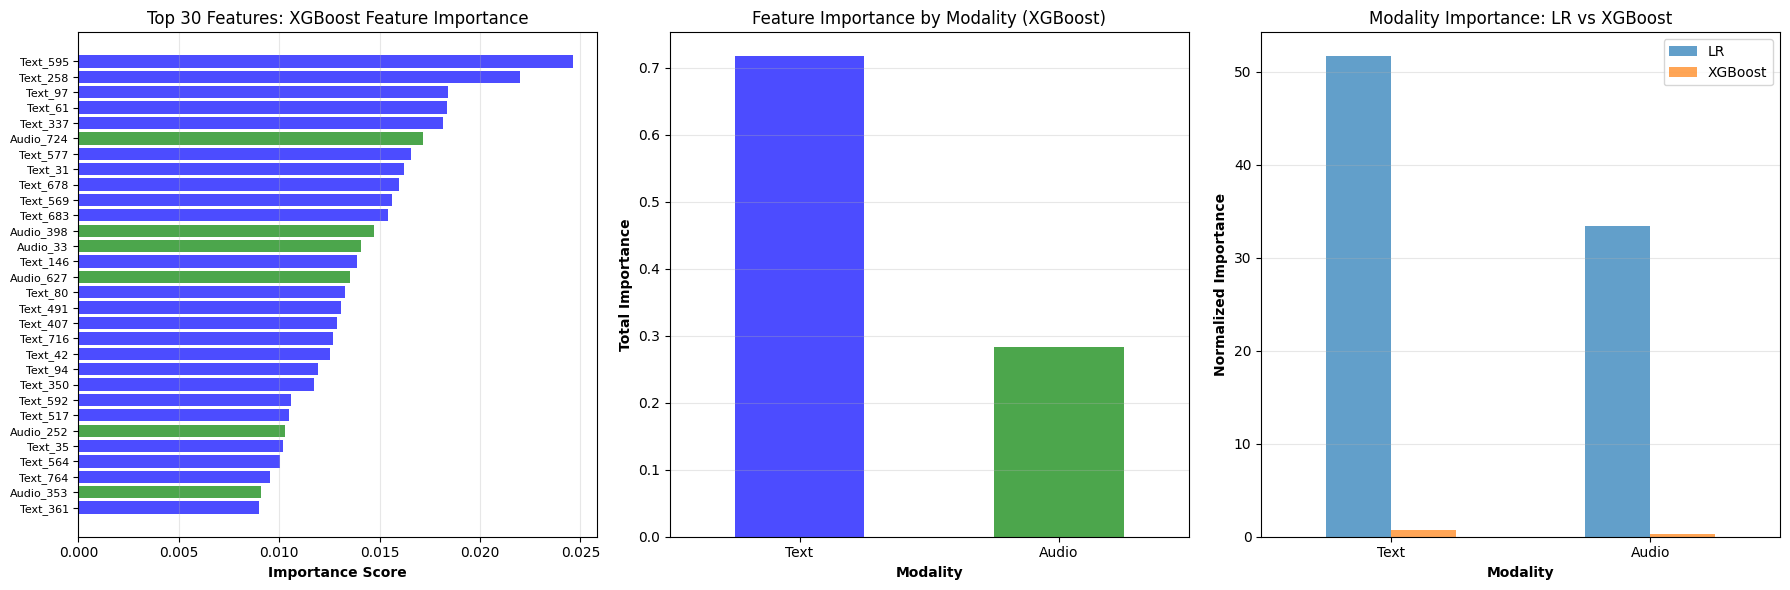

In [31]:
# Cell 36: XGBoost Feature Importance (Built-in)

print("\n" + "="*70)
print("XGBOOST: BUILT-IN FEATURE IMPORTANCE")
print("="*70)

# Use the best performing XGBoost model (Text + Audio early fusion)
print("\nAnalyzing best XGBoost model: Text + Audio (Early Fusion)")

# Get feature importance
xgb_importance = xgb_bi.feature_importances_

# Create DataFrame
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names_bi,
    'Importance': xgb_importance
}).sort_values('Importance', ascending=False)

# Determine modality
xgb_importance_df['Modality'] = xgb_importance_df['Feature'].apply(
    lambda x: 'Text' if x.startswith('Text') else 'Audio'
)

# Top 20 features
print("\nTop 20 Most Important Features:")
print(xgb_importance_df.head(20).to_string(index=False))

# Aggregate by modality
modality_importance_xgb = xgb_importance_df.groupby('Modality')['Importance'].sum().sort_values(ascending=False)
print("\n" + "="*70)
print("Feature Importance by Modality:")
print("="*70)
for modality, importance in modality_importance_xgb.items():
    percentage = (importance / xgb_importance_df['Importance'].sum()) * 100
    print(f"{modality}: {importance:.4f} ({percentage:.2f}%)")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Top 30 features
ax1 = axes[0]
top_30_xgb = xgb_importance_df.head(30)
colors_xgb = ['blue' if mod == 'Text' else 'green' for mod in top_30_xgb['Modality']]
ax1.barh(range(len(top_30_xgb)), top_30_xgb['Importance'], color=colors_xgb, alpha=0.7)
ax1.set_yticks(range(len(top_30_xgb)))
ax1.set_yticklabels(top_30_xgb['Feature'], fontsize=8)
ax1.set_xlabel('Importance Score', fontweight='bold')
ax1.set_title('Top 30 Features: XGBoost Feature Importance')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Modality comparison
ax2 = axes[1]
modality_importance_xgb.plot(kind='bar', ax=ax2, color=['blue', 'green'], alpha=0.7)
ax2.set_xlabel('Modality', fontweight='bold')
ax2.set_ylabel('Total Importance', fontweight='bold')
ax2.set_title('Feature Importance by Modality (XGBoost)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: LR vs XGBoost modality comparison
ax3 = axes[2]
comparison_df = pd.DataFrame({
    'LR': modality_importance_lr,
    'XGBoost': modality_importance_xgb
})
comparison_df.plot(kind='bar', ax=ax3, alpha=0.7)
ax3.set_xlabel('Modality', fontweight='bold')
ax3.set_ylabel('Normalized Importance', fontweight='bold')
ax3.set_title('Modality Importance: LR vs XGBoost')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
# print(f"\n✓ Saved: xgb_feature_importance.png")
plt.show()


SHAP ANALYSIS: XGBOOST
Computing SHAP values... (this may take a few minutes)
✓ SHAP values computed successfully

Top 20 Features by SHAP Importance:
  Feature  Mean_Abs_SHAP Modality
 Text_117       0.469211     Text
 Text_408       0.422059     Text
 Text_758       0.388205     Text
 Text_251       0.316701     Text
Audio_331       0.260194    Audio
 Text_364       0.234213     Text
 Text_350       0.232715     Text
 Text_577       0.190640     Text
 Text_600       0.173492     Text
Audio_652       0.147759    Audio
Audio_550       0.143663    Audio
 Text_379       0.143568     Text
 Text_397       0.139310     Text
 Text_630       0.136201     Text
   Text_5       0.125286     Text
 Text_315       0.119539     Text
 Text_258       0.092077     Text
Audio_647       0.086951    Audio
 Text_361       0.085409     Text
 Audio_22       0.083089    Audio

SHAP Importance by Modality:
Text: 7.6984 (74.41%)
Audio: 2.6481 (25.59%)

Generating SHAP Summary Plot...


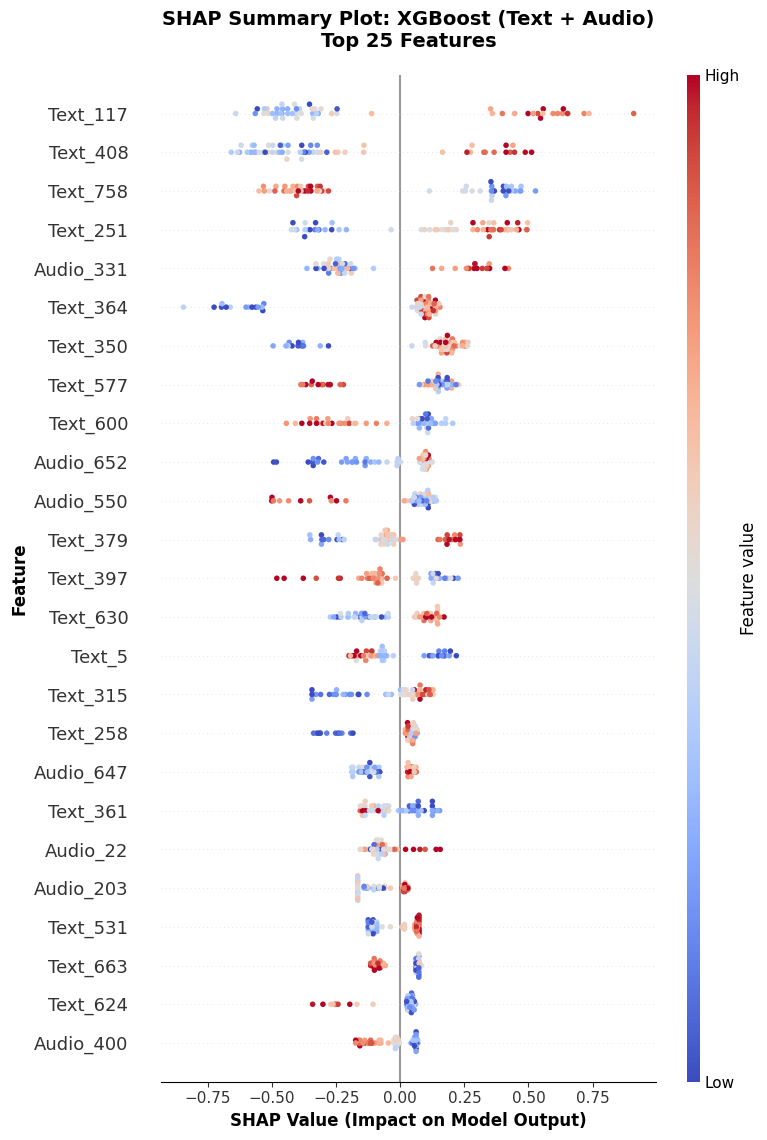


Generating SHAP Bar Plot...


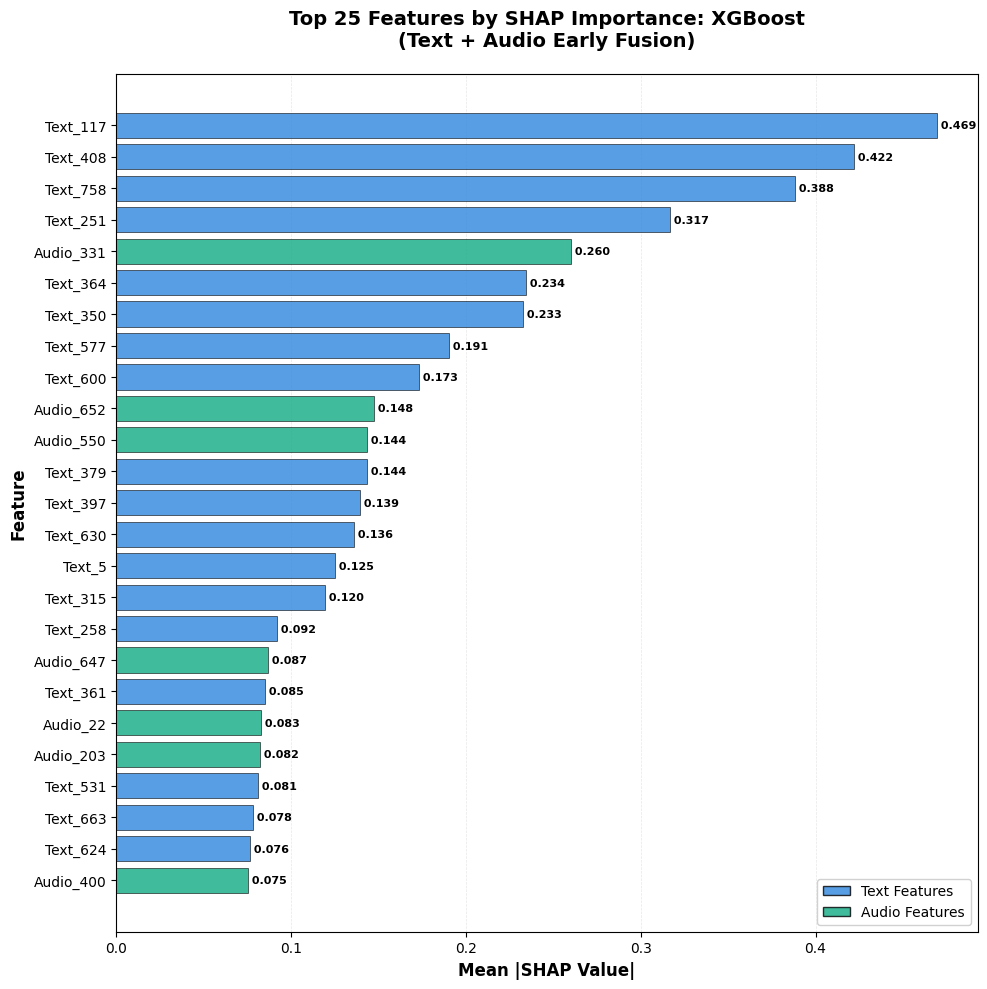


Generating Modality Importance Plot...


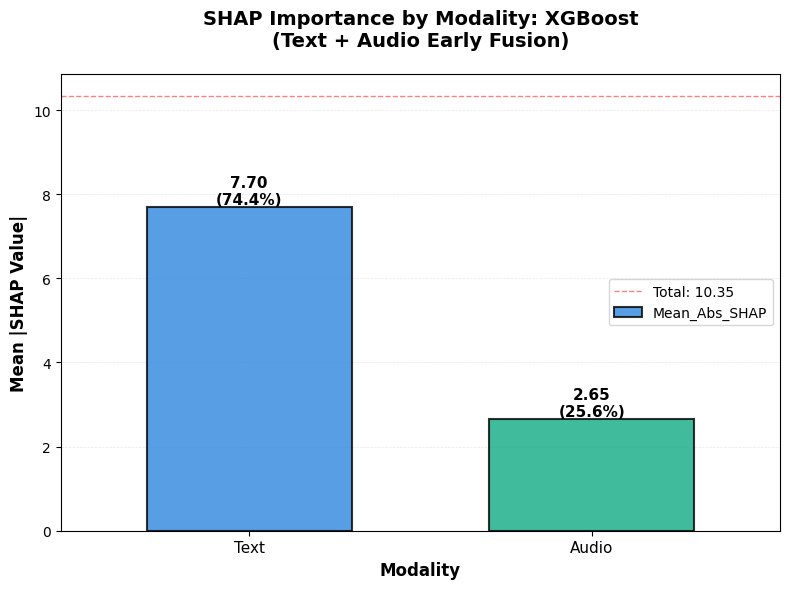


Generating SHAP Waterfall Plot...


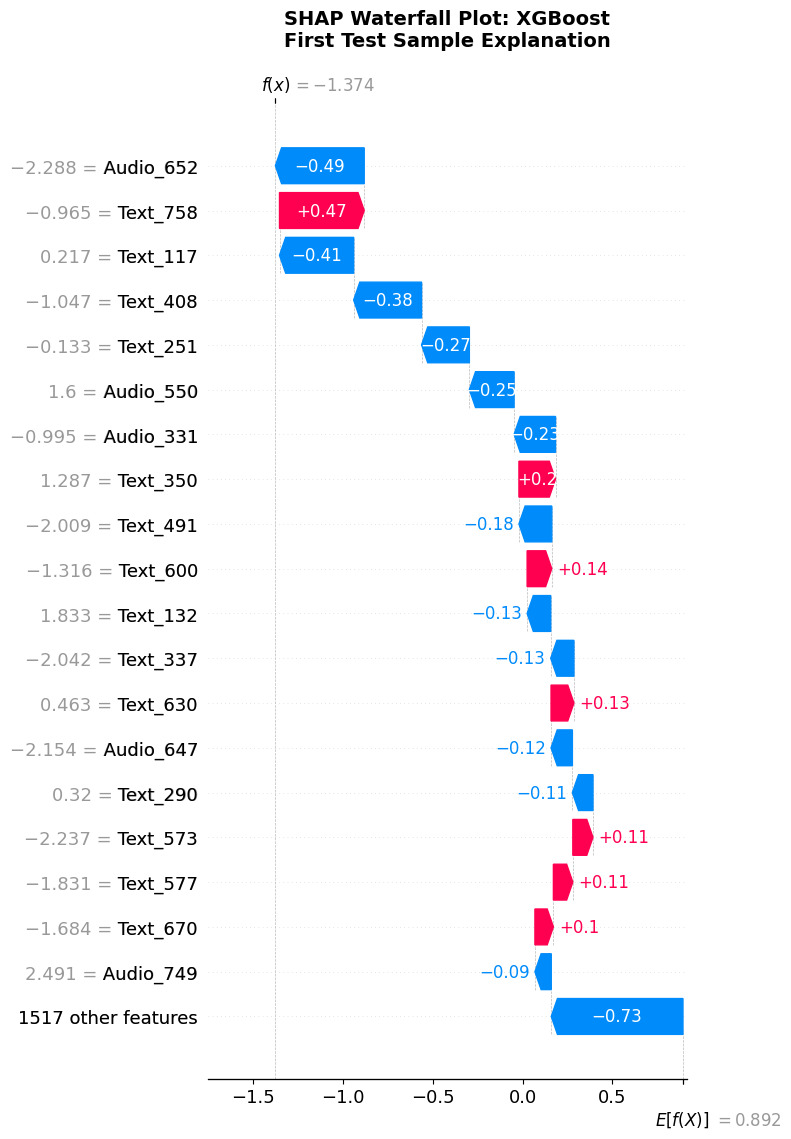


✓ XGBoost SHAP Analysis Complete


In [32]:
# Cell 37: SHAP Analysis for XGBoost

print("\n" + "="*70)
print("SHAP ANALYSIS: XGBOOST")
print("="*70)
print("Computing SHAP values... (this may take a few minutes)")

# Create SHAP explainer for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_bi)

# Calculate SHAP values for test set (use subset if needed)
shap_values_xgb = explainer_xgb.shap_values(X_test_bi_scaled)

print("✓ SHAP values computed successfully")

# Calculate mean absolute SHAP values
mean_abs_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)

# Create DataFrame
shap_df_xgb = pd.DataFrame({
    'Feature': feature_names_bi,
    'Mean_Abs_SHAP': mean_abs_shap_xgb
}).sort_values('Mean_Abs_SHAP', ascending=False)

shap_df_xgb['Modality'] = shap_df_xgb['Feature'].apply(
    lambda x: 'Text' if x.startswith('Text') else 'Audio'
)

# Top 20 features
print("\nTop 20 Features by SHAP Importance:")
print(shap_df_xgb.head(20).to_string(index=False))

# Aggregate by modality
modality_shap_xgb = shap_df_xgb.groupby('Modality')['Mean_Abs_SHAP'].sum().sort_values(ascending=False)
print("\n" + "="*70)
print("SHAP Importance by Modality:")
print("="*70)
for modality, shap_val in modality_shap_xgb.items():
    percentage = (shap_val / mean_abs_shap_xgb.sum()) * 100
    print(f"{modality}: {shap_val:.4f} ({percentage:.2f}%)")

# Visualization 1: SHAP Summary Plot (Beeswarm)
print("\n" + "="*70)
print("Generating SHAP Summary Plot...")
print("="*70)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_xgb, X_test_bi_scaled, feature_names=feature_names_bi,
                  max_display=25, show=False, cmap='coolwarm')
plt.title('SHAP Summary Plot: XGBoost (Text + Audio)\nTop 25 Features', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/shap_summary_xgboost.png', dpi=300, bbox_inches='tight')
# print(f"✓ Saved: shap_summary_xgboost.png")
plt.show()

# Visualization 2: SHAP Bar Plot
print("\nGenerating SHAP Bar Plot...")

fig, ax = plt.subplots(figsize=(10, 10))
top_25_shap = shap_df_xgb.head(25)
colors_shap = ['#2E86DE' if m == 'Text' else '#10AC84' for m in top_25_shap['Modality']]

bars = ax.barh(range(len(top_25_shap)), top_25_shap['Mean_Abs_SHAP'], 
               color=colors_shap, alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(top_25_shap)))
ax.set_yticklabels(top_25_shap['Feature'], fontsize=10)
ax.set_xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Features by SHAP Importance: XGBoost\n(Text + Audio Early Fusion)', 
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_25_shap['Mean_Abs_SHAP'])):
    ax.text(val, i, f' {val:.3f}', va='center', fontsize=8, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86DE', alpha=0.8, edgecolor='black', label='Text Features'),
    Patch(facecolor='#10AC84', alpha=0.8, edgecolor='black', label='Audio Features')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/shap_bar_xgboost.png', dpi=300, bbox_inches='tight')
# print(f"✓ Saved: shap_bar_xgboost.png")
plt.show()

# Visualization 3: Modality Importance
print("\nGenerating Modality Importance Plot...")

fig, ax = plt.subplots(figsize=(8, 6))
bars = modality_shap_xgb.plot(kind='bar', ax=ax, color=['#2E86DE', '#10AC84'], 
                              alpha=0.8, edgecolor='black', linewidth=1.5, width=0.6)

ax.set_xlabel('Modality', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax.set_title('SHAP Importance by Modality: XGBoost\n(Text + Audio Early Fusion)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels and percentages
for i, (modality, val) in enumerate(modality_shap_xgb.items()):
    percentage = (val / modality_shap_xgb.sum()) * 100
    ax.text(i, val, f'{val:.2f}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add total line
total = modality_shap_xgb.sum()
ax.axhline(y=total, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Total: {total:.2f}')
ax.legend(fontsize=10)

plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/shap_modality_xgboost.png', dpi=300, bbox_inches='tight')
# print(f"✓ Saved: shap_modality_xgboost.png")
plt.show()

# Visualization 4: SHAP Waterfall Plot
print("\nGenerating SHAP Waterfall Plot...")

plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap.Explanation(
    values=shap_values_xgb[0],
    base_values=explainer_xgb.expected_value,
    data=X_test_bi_scaled[0],
    feature_names=feature_names_bi
), max_display=20, show=False)
plt.title('SHAP Waterfall Plot: XGBoost\nFirst Test Sample Explanation', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/shap_waterfall_xgboost.png', dpi=300, bbox_inches='tight')
# print(f"✓ Saved: shap_waterfall_xgboost.png")
plt.show()

print("\n" + "="*70)
print("✓ XGBoost SHAP Analysis Complete")
print("="*70)


SHAP ANALYSIS: LOGISTIC REGRESSION
Computing SHAP values for Logistic Regression...
✓ SHAP values computed successfully

Top 20 Features by SHAP Importance:
  Feature  Mean_Abs_SHAP Modality
 Text_251       0.340714     Text
Audio_327       0.297602    Audio
 Text_346       0.282866     Text
 Text_758       0.259050     Text
 Text_324       0.249241     Text
 Text_594       0.238617     Text
 Text_645       0.225883     Text
 Text_291       0.214888     Text
 Text_408       0.207038     Text
 Text_600       0.200962     Text
 Audio_32       0.199664    Audio
Audio_323       0.197436    Audio
 Text_508       0.193110     Text
 Text_209       0.191172     Text
 Text_663       0.186126     Text
 Text_379       0.184310     Text
 Text_545       0.183327     Text
 Text_117       0.176045     Text
 Text_122       0.175378     Text
 Text_721       0.175326     Text

SHAP Importance by Modality:
Text: 41.9355 (60.10%)
Audio: 27.8433 (39.90%)

Generating SHAP Summary Plot...


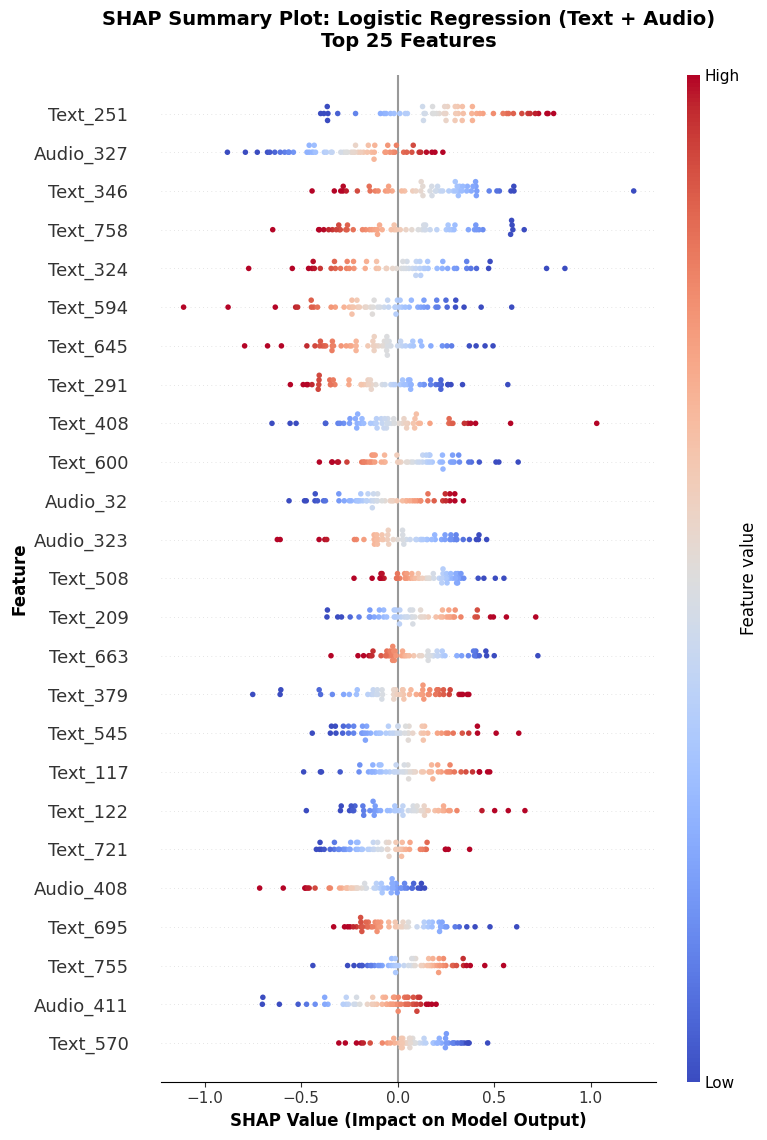


Generating SHAP Bar Plot...


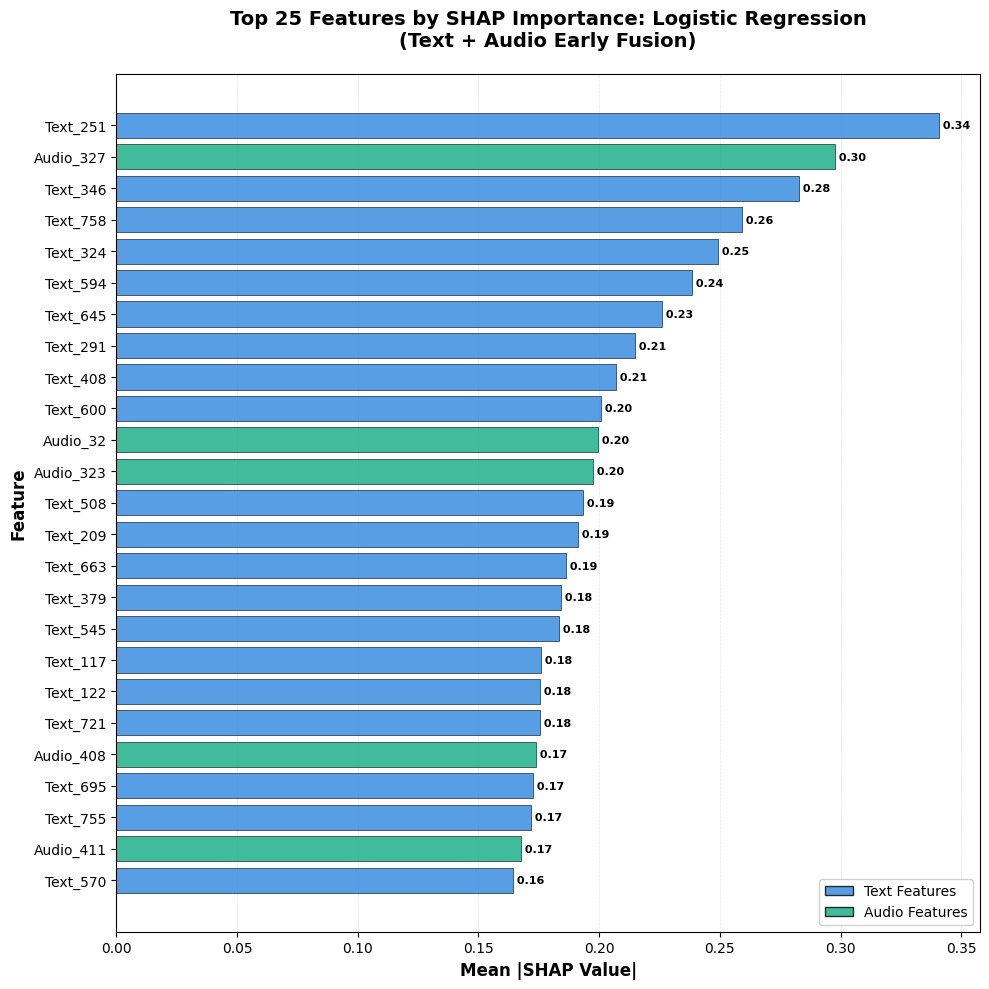


Generating Modality Importance Plot...


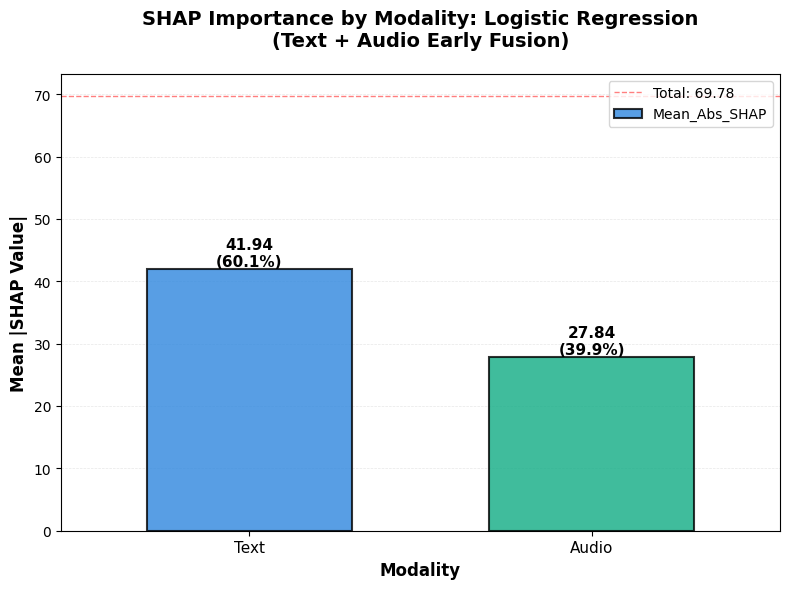


Generating SHAP Waterfall Plot...


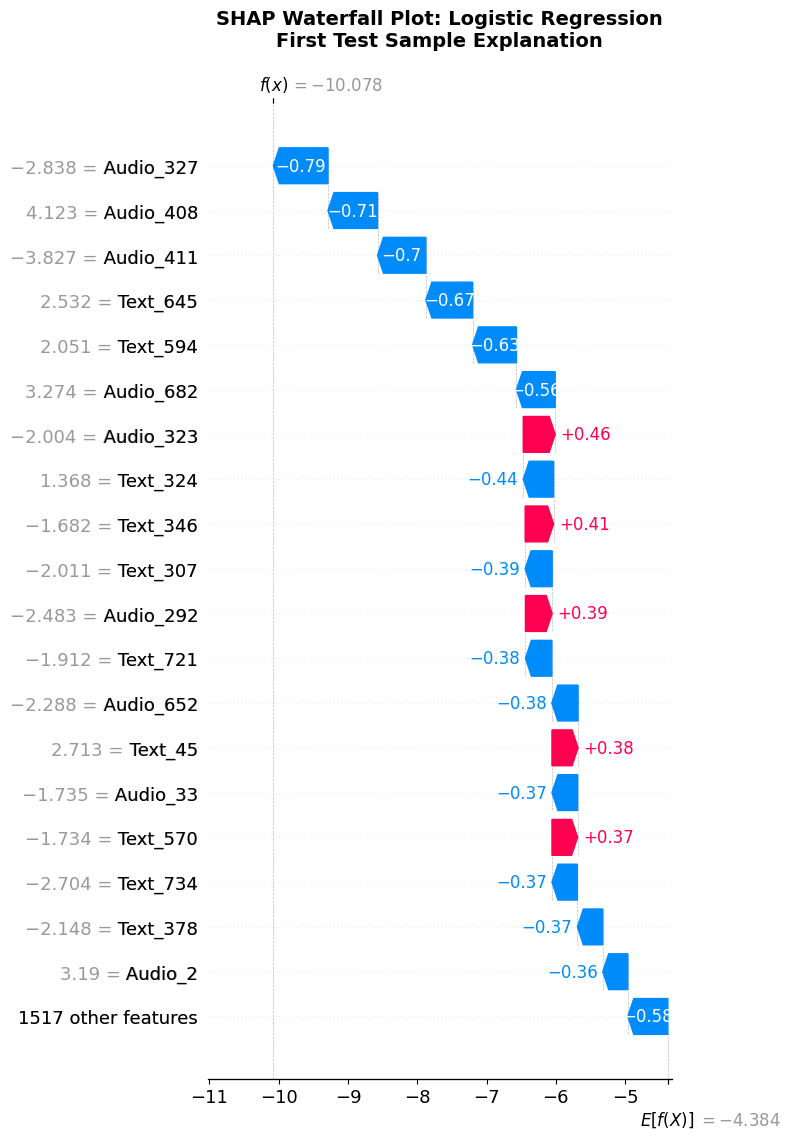


✓ Logistic Regression SHAP Analysis Complete


In [33]:
# Cell 38: SHAP Analysis for Logistic Regression

print("\n" + "="*70)
print("SHAP ANALYSIS: LOGISTIC REGRESSION")
print("="*70)
print("Computing SHAP values for Logistic Regression...")

# Create SHAP explainer for Logistic Regression
explainer_lr = shap.LinearExplainer(lr_bi, X_train_bi_scaled)

# Calculate SHAP values for test set
shap_values_lr = explainer_lr.shap_values(X_test_bi_scaled)

print("✓ SHAP values computed successfully")

# Calculate mean absolute SHAP values
mean_abs_shap_lr = np.abs(shap_values_lr).mean(axis=0)

# Create DataFrame
shap_df_lr = pd.DataFrame({
    'Feature': feature_names_bi,
    'Mean_Abs_SHAP': mean_abs_shap_lr
}).sort_values('Mean_Abs_SHAP', ascending=False)

shap_df_lr['Modality'] = shap_df_lr['Feature'].apply(
    lambda x: 'Text' if x.startswith('Text') else 'Audio'
)

# Top 20 features
print("\nTop 20 Features by SHAP Importance:")
print(shap_df_lr.head(20).to_string(index=False))

# Aggregate by modality
modality_shap_lr = shap_df_lr.groupby('Modality')['Mean_Abs_SHAP'].sum().sort_values(ascending=False)
print("\n" + "="*70)
print("SHAP Importance by Modality:")
print("="*70)
for modality, shap_val in modality_shap_lr.items():
    percentage = (shap_val / mean_abs_shap_lr.sum()) * 100
    print(f"{modality}: {shap_val:.4f} ({percentage:.2f}%)")

# Visualization 1: SHAP Summary Plot (Beeswarm)
print("\n" + "="*70)
print("Generating SHAP Summary Plot...")
print("="*70)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_lr, X_test_bi_scaled, feature_names=feature_names_bi,
                  max_display=25, show=False, cmap='coolwarm')
plt.title('SHAP Summary Plot: Logistic Regression (Text + Audio)\nTop 25 Features', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/shap_summary_lr.png', dpi=300, bbox_inches='tight')
# print(f"✓ Saved: shap_summary_lr.png")
plt.show()

# Visualization 2: SHAP Bar Plot
print("\nGenerating SHAP Bar Plot...")

fig, ax = plt.subplots(figsize=(10, 10))
top_25_shap_lr = shap_df_lr.head(25)
colors_shap_lr = ['#2E86DE' if m == 'Text' else '#10AC84' for m in top_25_shap_lr['Modality']]

bars = ax.barh(range(len(top_25_shap_lr)), top_25_shap_lr['Mean_Abs_SHAP'], 
               color=colors_shap_lr, alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(top_25_shap_lr)))
ax.set_yticklabels(top_25_shap_lr['Feature'], fontsize=10)
ax.set_xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 25 Features by SHAP Importance: Logistic Regression\n(Text + Audio Early Fusion)', 
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_25_shap_lr['Mean_Abs_SHAP'])):
    ax.text(val, i, f' {val:.2f}', va='center', fontsize=8, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86DE', alpha=0.8, edgecolor='black', label='Text Features'),
    Patch(facecolor='#10AC84', alpha=0.8, edgecolor='black', label='Audio Features')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/shap_bar_lr.png', dpi=300, bbox_inches='tight')
# print(f"✓ Saved: shap_bar_lr.png")
plt.show()

# Visualization 3: Modality Importance
print("\nGenerating Modality Importance Plot...")

fig, ax = plt.subplots(figsize=(8, 6))
bars = modality_shap_lr.plot(kind='bar', ax=ax, color=['#2E86DE', '#10AC84'], 
                             alpha=0.8, edgecolor='black', linewidth=1.5, width=0.6)

ax.set_xlabel('Modality', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax.set_title('SHAP Importance by Modality: Logistic Regression\n(Text + Audio Early Fusion)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels and percentages
for i, (modality, val) in enumerate(modality_shap_lr.items()):
    percentage = (val / modality_shap_lr.sum()) * 100
    ax.text(i, val, f'{val:.2f}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add total line
total = modality_shap_lr.sum()
ax.axhline(y=total, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Total: {total:.2f}')
ax.legend(fontsize=10)

plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/shap_modality_lr.png', dpi=300, bbox_inches='tight')
# print(f"✓ Saved: shap_modality_lr.png")
plt.show()

# Visualization 4: SHAP Waterfall Plot
print("\nGenerating SHAP Waterfall Plot...")

plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap.Explanation(
    values=shap_values_lr[0],
    base_values=explainer_lr.expected_value,
    data=X_test_bi_scaled[0],
    feature_names=feature_names_bi
), max_display=20, show=False)
plt.title('SHAP Waterfall Plot: Logistic Regression\nFirst Test Sample Explanation', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/shap_waterfall_lr.png', dpi=300, bbox_inches='tight')
# print(f"✓ Saved: shap_waterfall_lr.png")
plt.show()

print("\n" + "="*70)
print("✓ Logistic Regression SHAP Analysis Complete")
print("="*70)

In [34]:
# # Cell 39: Comprehensive Interpretability Comparison

# print("\n" + "="*70)
# print("COMPREHENSIVE INTERPRETABILITY COMPARISON")
# print("="*70)

# # Compare all methods side by side
# fig, axes = plt.subplots(2, 3, figsize=(20, 12))
# fig.suptitle('Interpretability Methods Comparison: LR vs XGBoost', 
#              fontsize=16, fontweight='bold')

# # Row 1: Logistic Regression
# # LR Coefficients
# ax1 = axes[0, 0]
# top_15_coef = coef_df.head(15)
# colors_coef = ['blue' if m == 'Text' else 'green' for m in top_15_coef['Modality']]
# ax1.barh(range(len(top_15_coef)), top_15_coef['Abs_Coefficient'], 
#          color=colors_coef, alpha=0.7)
# ax1.set_yticks(range(len(top_15_coef)))
# ax1.set_yticklabels(top_15_coef['Feature'], fontsize=8)
# ax1.set_xlabel('|Coefficient|', fontweight='bold')
# ax1.set_title('LR: Feature Coefficients')
# ax1.invert_yaxis()
# ax1.grid(axis='x', alpha=0.3)

# # LR SHAP
# ax2 = axes[0, 1]
# top_15_shap_lr = shap_df_lr.head(15)
# colors_shap = ['blue' if m == 'Text' else 'green' for m in top_15_shap_lr['Modality']]
# ax2.barh(range(len(top_15_shap_lr)), top_15_shap_lr['Mean_Abs_SHAP'], 
#          color=colors_shap, alpha=0.7)
# ax2.set_yticks(range(len(top_15_shap_lr)))
# ax2.set_yticklabels(top_15_shap_lr['Feature'], fontsize=8)
# ax2.set_xlabel('Mean |SHAP|', fontweight='bold')
# ax2.set_title('LR: SHAP Values')
# ax2.invert_yaxis()
# ax2.grid(axis='x', alpha=0.3)

# # LR Modality comparison
# ax3 = axes[0, 2]
# comparison_lr = pd.DataFrame({
#     'Coefficients': modality_importance_lr,
#     'SHAP': modality_shap_lr
# })
# comparison_lr.plot(kind='bar', ax=ax3, alpha=0.7)
# ax3.set_xlabel('Modality', fontweight='bold')
# ax3.set_ylabel('Importance', fontweight='bold')
# ax3.set_title('LR: Modality Importance (All Methods)')
# ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
# ax3.legend()
# ax3.grid(axis='y', alpha=0.3)

# # Row 2: XGBoost
# # XGB Feature Importance
# ax4 = axes[1, 0]
# top_15_xgb = xgb_importance_df.head(15)
# colors_xgb = ['blue' if m == 'Text' else 'green' for m in top_15_xgb['Modality']]
# ax4.barh(range(len(top_15_xgb)), top_15_xgb['Importance'], 
#          color=colors_xgb, alpha=0.7)
# ax4.set_yticks(range(len(top_15_xgb)))
# ax4.set_yticklabels(top_15_xgb['Feature'], fontsize=8)
# ax4.set_xlabel('Importance', fontweight='bold')
# ax4.set_title('XGBoost: Feature Importance')
# ax4.invert_yaxis()
# ax4.grid(axis='x', alpha=0.3)

# # XGB SHAP
# ax5 = axes[1, 1]
# top_15_shap_xgb = shap_df_xgb.head(15)
# colors_shap_xgb = ['blue' if m == 'Text' else 'green' for m in top_15_shap_xgb['Modality']]
# ax5.barh(range(len(top_15_shap_xgb)), top_15_shap_xgb['Mean_Abs_SHAP'], 
#          color=colors_shap_xgb, alpha=0.7)
# ax5.set_yticks(range(len(top_15_shap_xgb)))
# ax5.set_yticklabels(top_15_shap_xgb['Feature'], fontsize=8)
# ax5.set_xlabel('Mean |SHAP|', fontweight='bold')
# ax5.set_title('XGBoost: SHAP Values')
# ax5.invert_yaxis()
# ax5.grid(axis='x', alpha=0.3)

# # XGB Modality comparison
# ax6 = axes[1, 2]
# comparison_xgb = pd.DataFrame({
#     'Feature Imp': modality_importance_xgb,
#     'SHAP': modality_shap_xgb
# })
# comparison_xgb.plot(kind='bar', ax=ax6, alpha=0.7)
# ax6.set_xlabel('Modality', fontweight='bold')
# ax6.set_ylabel('Importance', fontweight='bold')
# ax6.set_title('XGBoost: Modality Importance (All Methods)')
# ax6.set_xticklabels(ax6.get_xticklabels(), rotation=0)
# ax6.legend()
# ax6.grid(axis='y', alpha=0.3)

# plt.tight_layout()
# plt.savefig(f'{BASE_PATH}/interpretability_comparison_complete.png', dpi=300, bbox_inches='tight')
# print(f"\n✓ Saved: interpretability_comparison_complete.png")
# plt.show()

# # Summary statistics
# print("\n" + "="*70)
# print("INTERPRETABILITY SUMMARY")
# print("="*70)

# print("\nLogistic Regression:")
# print("  Coefficient-based modality importance:")
# for mod, val in modality_importance_lr.items():
#     print(f"    {mod}: {(val/modality_importance_lr.sum())*100:.2f}%")
# print("  SHAP-based modality importance:")
# for mod, val in modality_shap_lr.items():
#     print(f"    {mod}: {(val/modality_shap_lr.sum())*100:.2f}%")

# print("\nXGBoost:")
# print("  Feature importance-based modality:")
# for mod, val in modality_importance_xgb.items():
#     print(f"    {mod}: {(val/modality_importance_xgb.sum())*100:.2f}%")
# print("  SHAP-based modality importance:")
# for mod, val in modality_shap_xgb.items():
#     print(f"    {mod}: {(val/modality_shap_xgb.sum())*100:.2f}%")

# print("\n" + "="*70)
# print("✓ INTERPRETABILITY ANALYSIS COMPLETE!")
# print("="*70)

# 4. INTERPRETABILITY

## 4.1 INTERPRETABILITY (TEXT + VIDEO LR LATE FUSION)


In [35]:
# Cell 40: Interpretability for Best Late Fusion (Text + Video - LR)

print("\n" + "="*70)
print("INTERPRETABILITY: BEST LATE FUSION MODEL")
print("Text + Video - Logistic Regression (Late Fusion)")
print("="*70)

# Get feature names for Text + Video
video_dim = video_features.shape[1]
feature_names_tv = [f'Text_{i}' for i in range(text_dim)] + \
                   [f'Video_{i}' for i in range(video_dim)]

print(f"\nModel Configuration:")
print(f"  Fusion Type: Late Fusion")
print(f"  Modalities: Text + Video")
print(f"  Classifier: Logistic Regression (per modality)")
print(f"  Text Features: {text_dim}")
print(f"  Video Features: {video_dim}")
print(f"  Total Combined Features: {text_dim + video_dim}")
print(f"\nBest Performance:")
print(f"  Balanced Accuracy: {test_metrics_lr_tv_late['balanced_accuracy']:.4f}")
print(f"  F1 Score: {test_metrics_lr_tv_late['f1']:.4f}")
print(f"  Precision: {test_metrics_lr_tv_late['precision']:.4f}")
print(f"  Recall: {test_metrics_lr_tv_late['recall']:.4f}")
print(f"  AUC-ROC: {test_metrics_lr_tv_late['auc']:.4f}")


INTERPRETABILITY: BEST LATE FUSION MODEL
Text + Video - Logistic Regression (Late Fusion)

Model Configuration:
  Fusion Type: Late Fusion
  Modalities: Text + Video
  Classifier: Logistic Regression (per modality)
  Text Features: 768
  Video Features: 104
  Total Combined Features: 872

Best Performance:
  Balanced Accuracy: 0.7466
  F1 Score: 0.6471
  Precision: 0.6471
  Recall: 0.6471
  AUC-ROC: 0.7813


In [36]:
# Cell 41: Combined Feature Importance Analysis (Late Fusion)

print("\n" + "="*70)
print("COMBINED FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get coefficients from both models
text_coefficients = lr_text.coef_[0]
video_coefficients = lr_video.coef_[0]

# Combine coefficients
combined_coefficients = np.concatenate([text_coefficients, video_coefficients])

# Create comprehensive DataFrame
combined_coef_df = pd.DataFrame({
    'Feature': feature_names_tv,
    'Coefficient': combined_coefficients,
    'Abs_Coefficient': np.abs(combined_coefficients),
    'Modality': ['Text']*text_dim + ['Video']*video_dim
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 30 Most Important Features (Combined Text + Video):")
print(combined_coef_df.head(30).to_string(index=False))

# Statistics by modality
print("\n" + "="*70)
print("Feature Importance Statistics by Modality:")
print("="*70)
for modality in ['Text', 'Video']:
    modality_data = combined_coef_df[combined_coef_df['Modality'] == modality]
    print(f"\n{modality}:")
    print(f"  Mean |Coefficient|: {modality_data['Abs_Coefficient'].mean():.4f}")
    print(f"  Std |Coefficient|:  {modality_data['Abs_Coefficient'].std():.4f}")
    print(f"  Max |Coefficient|:  {modality_data['Abs_Coefficient'].max():.4f}")
    print(f"  Min |Coefficient|:  {modality_data['Abs_Coefficient'].min():.4f}")
    print(f"  Total Importance:   {modality_data['Abs_Coefficient'].sum():.4f}")

# Calculate modality contributions
text_importance = combined_coef_df[combined_coef_df['Modality'] == 'Text']['Abs_Coefficient'].sum()
video_importance = combined_coef_df[combined_coef_df['Modality'] == 'Video']['Abs_Coefficient'].sum()
total_importance = text_importance + video_importance

text_pct = (text_importance / total_importance) * 100
video_pct = (video_importance / total_importance) * 100

print("\n" + "="*70)
print("Overall Modality Contribution (by coefficient magnitude):")
print("="*70)
print(f"  Text:  {text_importance:.4f} ({text_pct:.2f}%)")
print(f"  Video: {video_importance:.4f} ({video_pct:.2f}%)")


COMBINED FEATURE IMPORTANCE ANALYSIS

Top 30 Most Important Features (Combined Text + Video):
 Feature  Coefficient  Abs_Coefficient Modality
 Video_5    -1.682257         1.682257    Video
Video_41    -1.568122         1.568122    Video
Video_92     1.116247         1.116247    Video
 Video_9     1.034678         1.034678    Video
Video_56    -1.009852         1.009852    Video
Video_96    -0.976020         0.976020    Video
Video_58     0.962852         0.962852    Video
Video_94     0.960181         0.960181    Video
Video_21    -0.896110         0.896110    Video
Video_90     0.887282         0.887282    Video
 Video_1     0.856218         0.856218    Video
Video_52     0.821231         0.821231    Video
Video_83     0.817445         0.817445    Video
Video_84     0.753886         0.753886    Video
Video_45     0.687309         0.687309    Video
Video_80    -0.678809         0.678809    Video
Video_38    -0.671595         0.671595    Video
Video_61    -0.661868         0.661868   

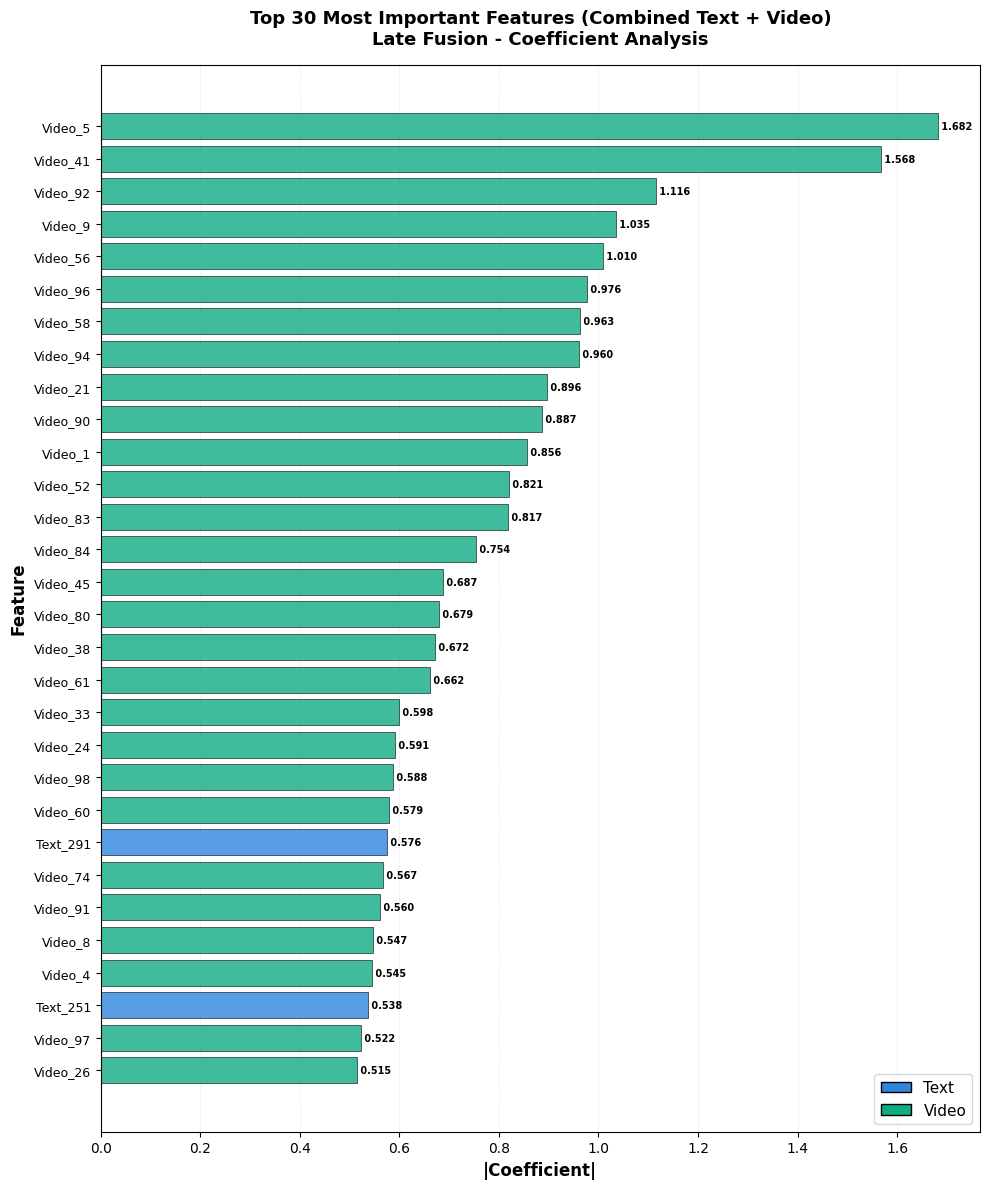

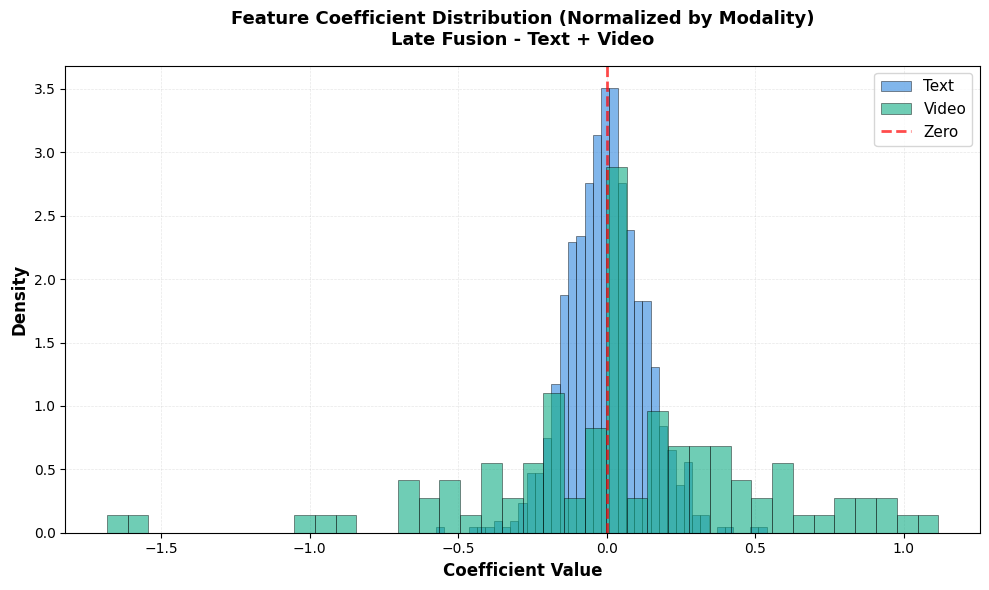

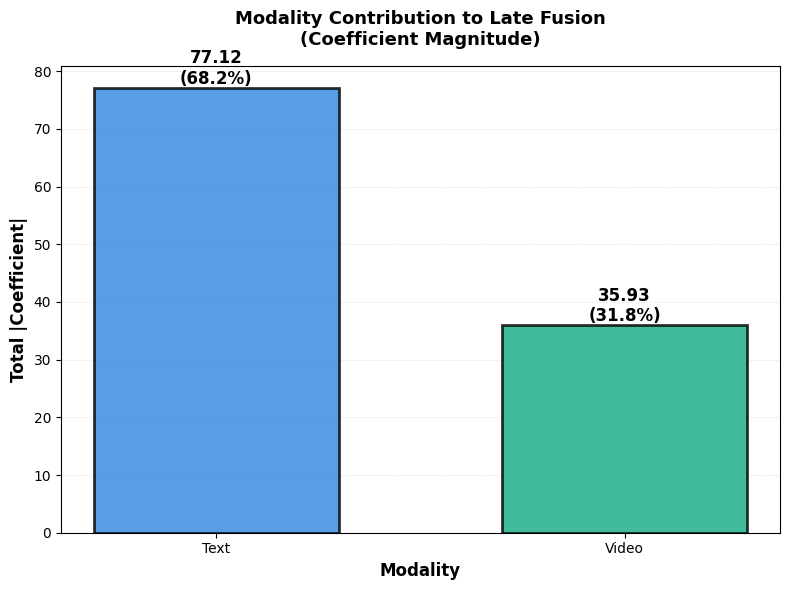

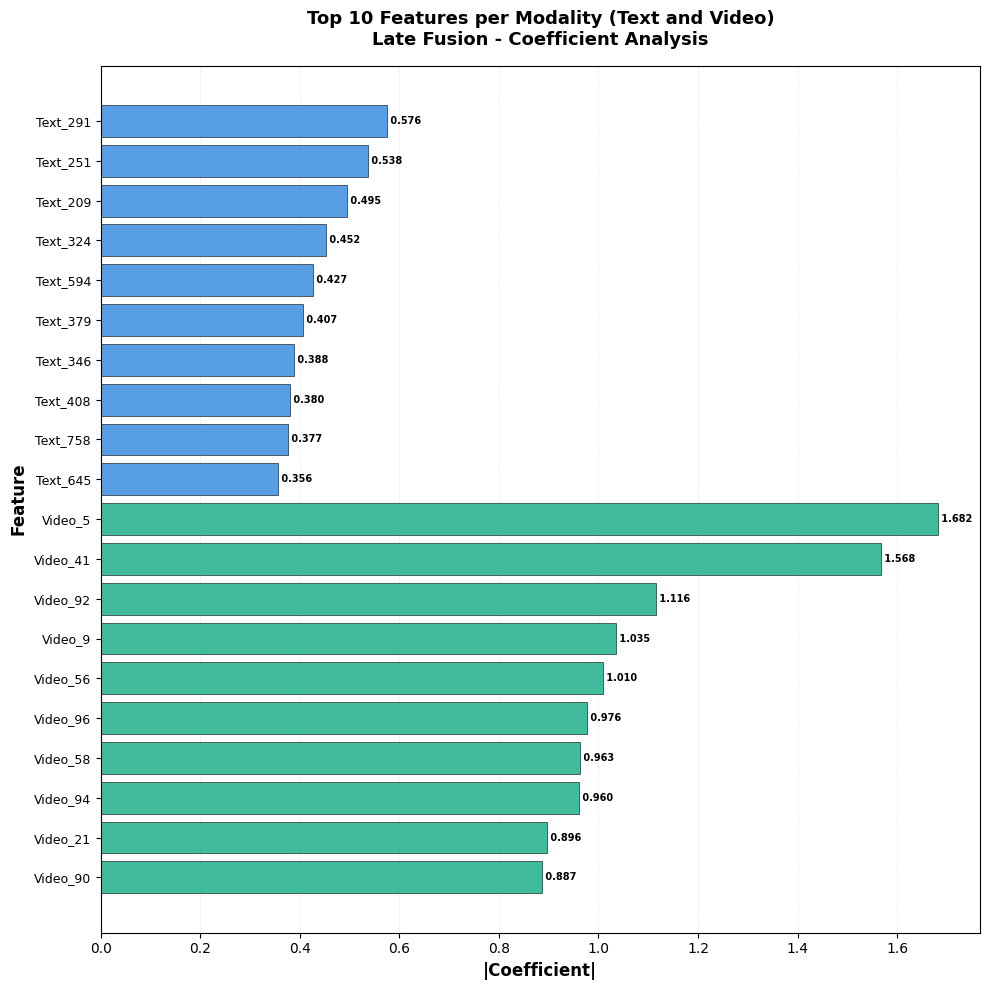


✓ Combined feature importance visualization complete


In [ ]:
# Cell 42: Visualize Combined Feature Importance

# Plot 1: Top 30 features (all modalities combined)
fig, ax = plt.subplots(figsize=(10, 12))
top_30 = combined_coef_df.head(30)
colors_top30 = ['#2E86DE' if m == 'Text' else '#10AC84' for m in top_30['Modality']]
bars = ax.barh(range(len(top_30)), top_30['Abs_Coefficient'], 
                color=colors_top30, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['Feature'], fontsize=9)
ax.set_xlabel('|Coefficient|', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Most Important Features (Combined Text + Video)\nLate Fusion - Coefficient Analysis', 
              fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_30['Abs_Coefficient'])):
    ax.text(val, i, f' {val:.3f}', va='center', fontsize=7, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86DE', edgecolor='black', label='Text'),
                   Patch(facecolor='#10AC84', edgecolor='black', label='Video')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

# Plot 2: Coefficient distribution by modality
fig, ax = plt.subplots(figsize=(10, 6))
text_coefs = combined_coef_df[combined_coef_df['Modality'] == 'Text']['Coefficient']
video_coefs = combined_coef_df[combined_coef_df['Modality'] == 'Video']['Coefficient']
ax.hist(text_coefs, bins=40, alpha=0.6, label='Text', 
         color='#2E86DE', edgecolor='black', linewidth=0.5, density=True)
ax.hist(video_coefs, bins=40, alpha=0.6, label='Video', 
         color='#10AC84', edgecolor='black', linewidth=0.5, density=True)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero')
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('Feature Coefficient Distribution (Normalized by Modality)\nLate Fusion - Text + Video', 
              fontsize=13, fontweight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Plot 3: Modality importance comparison
fig, ax = plt.subplots(figsize=(8, 6))
modalities = ['Text', 'Video']
importances = [text_importance, video_importance]
percentages = [text_pct, video_pct]
colors_modal = ['#2E86DE', '#10AC84']
bars = ax.bar(modalities, importances, color=colors_modal, alpha=0.8, 
               edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Total |Coefficient|', fontsize=12, fontweight='bold')
ax.set_xlabel('Modality', fontsize=12, fontweight='bold')
ax.set_title('Modality Contribution to Late Fusion\n(Coefficient Magnitude)', 
              fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels and percentages
for i, (bar, val, pct) in enumerate(zip(bars, importances, percentages)):
    ax.text(i, val, f'{val:.2f}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/home/jonathanchan/ml_data/ThesisFinal/figures/int1.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Top 10 features per modality
fig, ax = plt.subplots(figsize=(10, 10))
top_text = combined_coef_df[combined_coef_df['Modality'] == 'Text'].head(10)
top_video = combined_coef_df[combined_coef_df['Modality'] == 'Video'].head(10)
combined_top = pd.concat([
    top_text[['Feature', 'Abs_Coefficient', 'Modality']],
    top_video[['Feature', 'Abs_Coefficient', 'Modality']]
]).reset_index(drop=True)

colors_combined = ['#2E86DE' if m == 'Text' else '#10AC84' for m in combined_top['Modality']]
bars = ax.barh(range(len(combined_top)), combined_top['Abs_Coefficient'], 
                color=colors_combined, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(combined_top)))
ax.set_yticklabels(combined_top['Feature'], fontsize=9)
ax.set_xlabel('|Coefficient|', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Features per Modality (Text and Video)\nLate Fusion - Coefficient Analysis', 
              fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, combined_top['Abs_Coefficient'])):
    ax.text(val, i, f' {val:.3f}', va='center', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Combined feature importance visualization complete")

In [ ]:
# Cell 42a (REVISED): TikZ Native Plots for int1.png and int2.png

print("\n" + "="*70)
print("GENERATING NATIVE TIKZ PLOTS")
print("="*70)

import os
output_dir = '/home/jonathanchan/ml_data/ThesisFinal/figures'
os.makedirs(output_dir, exist_ok=True)

# ============================================================================
# PLOT 1: int1.png - Modality Contribution (Bar Chart)
# ============================================================================
tikz_int1 = r"""
\documentclass[tikz]{standalone}
\usepackage{pgfplots}
\pgfplotsset{compat=1.18}

\begin{document}
\begin{tikzpicture}
\begin{axis}[
    ybar,
    bar width=0.6cm,
    width=10cm,
    height=8cm,
    ylabel={Total $|\text{Coefficient}|$},
    xlabel={Modality},
    symbolic x coords={Text, Video},
    xtick=data,
    ymin=0, ymax=85,
    nodes near coords,
    nodes near coords align={vertical},
    enlarge x limits=0.5,
    legend style={at={(0.5,-0.15)}, anchor=north, legend columns=-1},
    every node near coord/.append style={font=\footnotesize\bfseries}
]
\addplot[fill=blue!70, draw=black] coordinates {
    (Text,""" + f"{text_importance:.2f}" + r""")
    (Video,""" + f"{video_importance:.2f}" + r""")
};
\end{axis}
\end{tikzpicture}
\end{document}
"""

with open(f'{output_dir}/int1.tex', 'w') as f:
    f.write(tikz_int1)
print("✓ Generated int1.tex")

# ============================================================================
# PLOT 2: int2.png - Top 10 Features per Modality (Horizontal Bar)
# ============================================================================
# Get top 10 per modality
top_text = combined_coef_df[combined_coef_df['Modality'] == 'Text'].head(10)
top_video = combined_coef_df[combined_coef_df['Modality'] == 'Video'].head(10)

tikz_int2 = r"""
\documentclass[tikz]{standalone}
\usepackage{pgfplots}
\pgfplotsset{compat=1.18}

\begin{document}
\begin{tikzpicture}
\begin{axis}[
    xbar,
    bar width=0.4cm,
    width=12cm,
    height=14cm,
    xlabel={$|\text{Coefficient}|$},
    ylabel={Feature},
    ytick=data,
    symbolic y coords={"""

# Add feature names in reverse order for proper display
features_list = list(top_video['Feature'][::-1]) + list(top_text['Feature'][::-1])
tikz_int2 += ','.join(features_list)

tikz_int2 += r"""},
    y dir=reverse,
    xmin=0,
    nodes near coords,
    nodes near coords align={horizontal},
    every node near coord/.append style={font=\tiny\bfseries},
    legend style={at={(0.5,-0.1)}, anchor=north, legend columns=2}
]
% Video features
\addplot[fill=green!70, draw=black] coordinates {
"""

for _, row in top_video[::-1].iterrows():
    tikz_int2 += f"    ({row['Abs_Coefficient']:.3f},{row['Feature']})\n"

tikz_int2 += r"""};
\addlegendentry{Video}

% Text features
\addplot[fill=blue!70, draw=black] coordinates {
"""

for _, row in top_text[::-1].iterrows():
    tikz_int2 += f"    ({row['Abs_Coefficient']:.3f},{row['Feature']})\n"

tikz_int2 += r"""};
\addlegendentry{Text}

\end{axis}
\end{tikzpicture}
\end{document}
"""

with open(f'{output_dir}/int2.tex', 'w') as f:
    f.write(tikz_int2)
print("✓ Generated int2.tex")


GENERATING NATIVE TIKZ PLOTS
✓ Generated int1.tex
✓ Generated int2.tex


In [38]:
# Cell 43: SHAP Analysis for Combined Late Fusion Model

print("\n" + "="*70)
print("SHAP ANALYSIS: COMBINED TEXT + VIDEO (LATE FUSION)")
print("="*70)
print("Computing SHAP values for combined model...")

# Compute SHAP values for both models
explainer_text = shap.LinearExplainer(lr_text, X_text_train_scaled)
shap_values_text = explainer_text.shap_values(X_text_test_scaled)

explainer_video = shap.LinearExplainer(lr_video, X_video_train_scaled)
shap_values_video = explainer_video.shap_values(X_video_test_scaled)

print("✓ SHAP values computed for both models")

# Combine SHAP values (weighted by contribution to final prediction)
# In late fusion with averaging, each model contributes equally
combined_shap_values = np.concatenate([shap_values_text, shap_values_video], axis=1)

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(combined_shap_values).mean(axis=0)

# Create comprehensive SHAP DataFrame
shap_df = pd.DataFrame({
    'Feature': feature_names_tv,
    'Mean_Abs_SHAP': mean_abs_shap,
    'Modality': ['Text']*text_dim + ['Video']*video_dim
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\nTop 30 Features by SHAP Importance (Combined):")
print(shap_df.head(30).to_string(index=False))

# Statistics by modality
print("\n" + "="*70)
print("SHAP Importance Statistics by Modality:")
print("="*70)
for modality in ['Text', 'Video']:
    modality_shap = shap_df[shap_df['Modality'] == modality]
    print(f"\n{modality}:")
    print(f"  Mean |SHAP|: {modality_shap['Mean_Abs_SHAP'].mean():.4f}")
    print(f"  Std |SHAP|:  {modality_shap['Mean_Abs_SHAP'].std():.4f}")
    print(f"  Max |SHAP|:  {modality_shap['Mean_Abs_SHAP'].max():.4f}")
    print(f"  Min |SHAP|:  {modality_shap['Mean_Abs_SHAP'].min():.4f}")
    print(f"  Total SHAP:  {modality_shap['Mean_Abs_SHAP'].sum():.4f}")

# Calculate modality SHAP contributions
text_shap_importance = shap_df[shap_df['Modality'] == 'Text']['Mean_Abs_SHAP'].sum()
video_shap_importance = shap_df[shap_df['Modality'] == 'Video']['Mean_Abs_SHAP'].sum()
total_shap_importance = text_shap_importance + video_shap_importance

text_shap_pct = (text_shap_importance / total_shap_importance) * 100
video_shap_pct = (video_shap_importance / total_shap_importance) * 100

print("\n" + "="*70)
print("Overall Modality Contribution (by SHAP values):")
print("="*70)
print(f"  Text:  {text_shap_importance:.4f} ({text_shap_pct:.2f}%)")
print(f"  Video: {video_shap_importance:.4f} ({video_shap_pct:.2f}%)")


SHAP ANALYSIS: COMBINED TEXT + VIDEO (LATE FUSION)
Computing SHAP values for combined model...
✓ SHAP values computed for both models

Top 30 Features by SHAP Importance (Combined):
 Feature  Mean_Abs_SHAP Modality
 Video_5       1.427035    Video
Video_41       1.053183    Video
Video_94       0.944231    Video
Video_92       0.935968    Video
Video_90       0.893416    Video
 Video_9       0.791020    Video
Video_96       0.781107    Video
Video_83       0.772348    Video
Video_56       0.755906    Video
Video_58       0.711496    Video
Video_80       0.702209    Video
Video_52       0.695524    Video
Video_84       0.662252    Video
Video_45       0.646427    Video
Video_21       0.593362    Video
 Video_1       0.587972    Video
 Video_8       0.551670    Video
Video_91       0.534643    Video
Text_251       0.529813     Text
Video_61       0.526999    Video
Video_38       0.524135    Video
Video_97       0.509350    Video
Video_46       0.487482    Video
Video_98       0.465333  

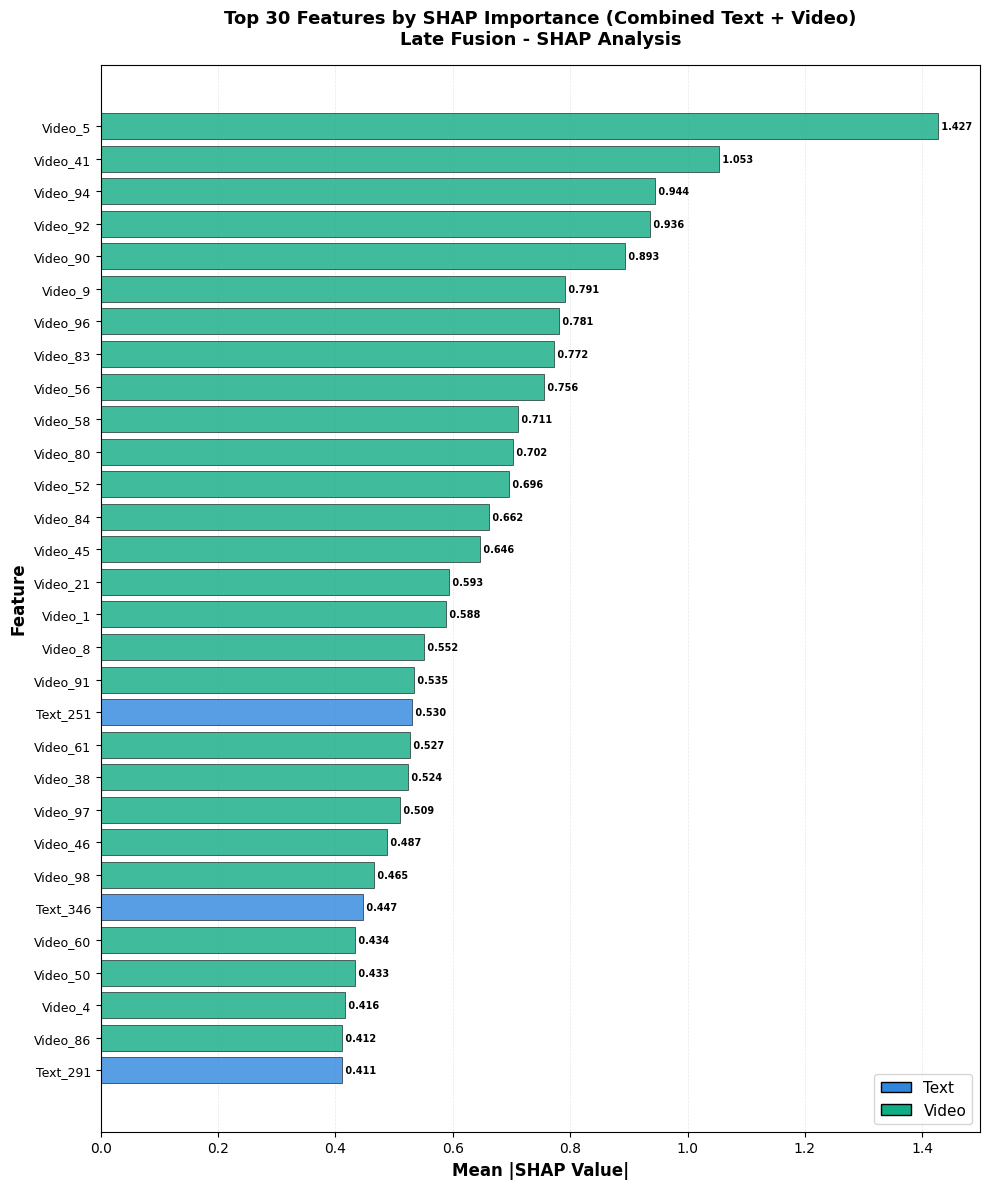

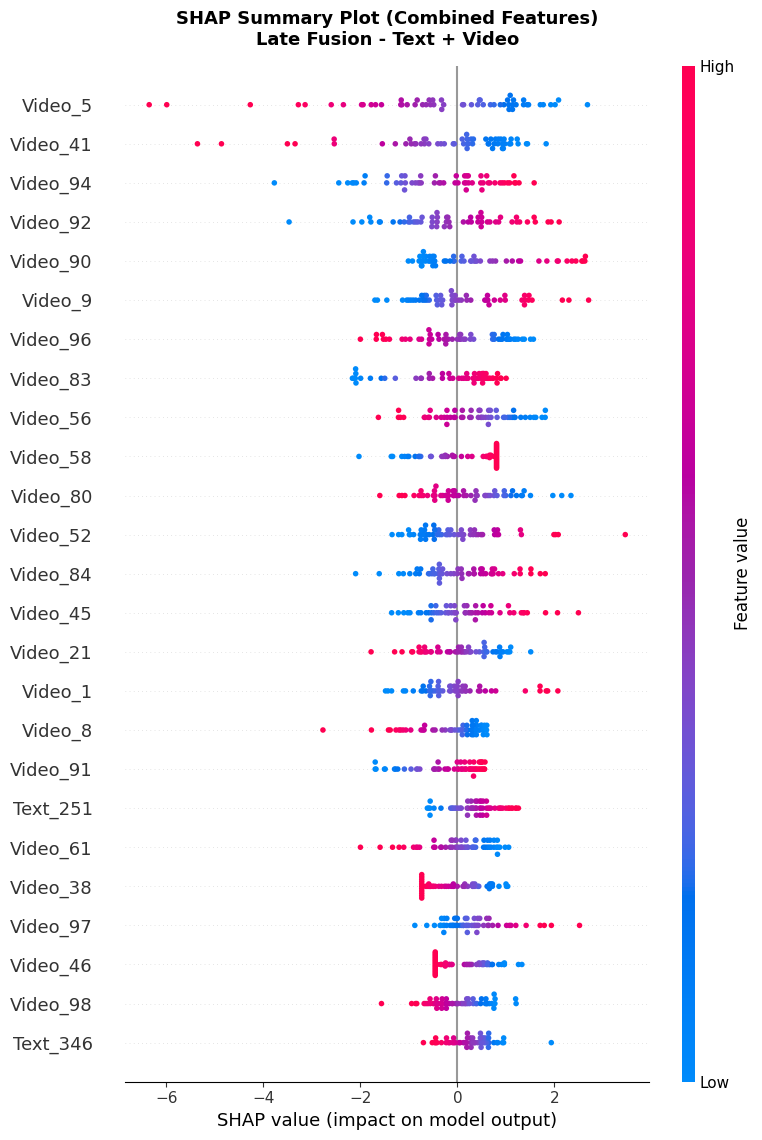

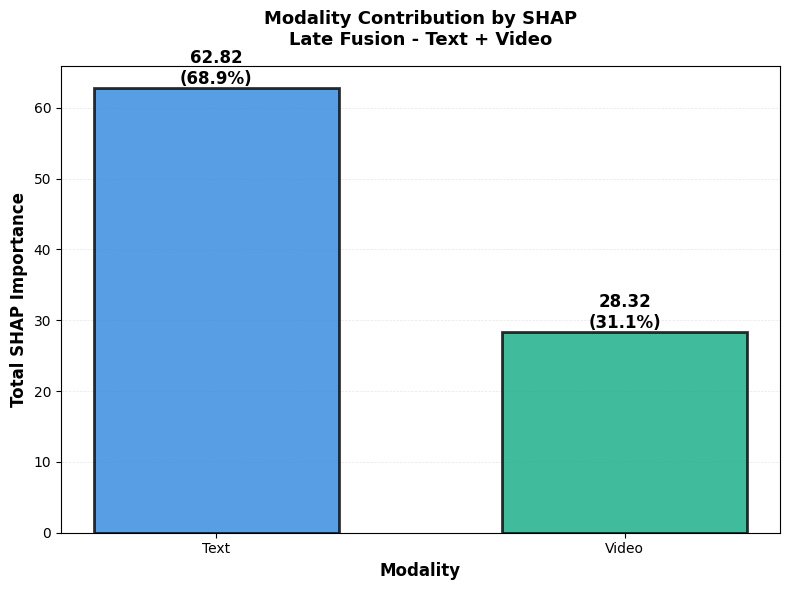

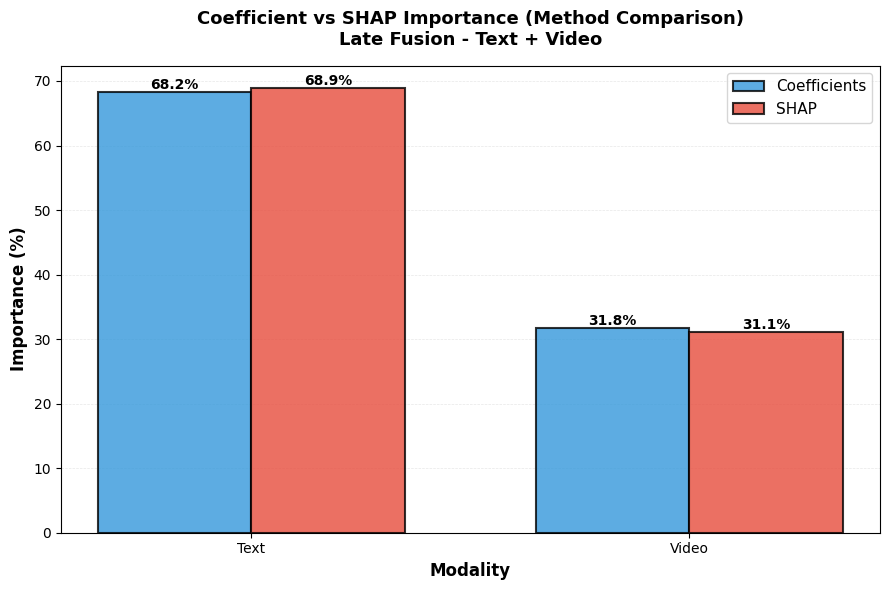


✓ Combined SHAP analysis visualization complete


In [61]:
# Cell 44: Visualize Combined SHAP Analysis

# Plot 1: Top 30 features by SHAP
fig, ax = plt.subplots(figsize=(10, 12))
top_30_shap = shap_df.head(30)
colors_shap = ['#2E86DE' if m == 'Text' else '#10AC84' for m in top_30_shap['Modality']]
bars = ax.barh(range(len(top_30_shap)), top_30_shap['Mean_Abs_SHAP'], 
                color=colors_shap, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_30_shap)))
ax.set_yticklabels(top_30_shap['Feature'], fontsize=9)
ax.set_xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Features by SHAP Importance (Combined Text + Video)\nLate Fusion - SHAP Analysis', 
              fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_30_shap['Mean_Abs_SHAP'])):
    ax.text(val, i, f' {val:.3f}', va='center', fontsize=7, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86DE', edgecolor='black', label='Text'),
                   Patch(facecolor='#10AC84', edgecolor='black', label='Video')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

# Plot 2: SHAP Summary Plot
fig, ax = plt.subplots(figsize=(10, 10))
# Combine features for visualization
X_combined_test = np.concatenate([X_text_test_scaled, X_video_test_scaled], axis=1)
shap.summary_plot(combined_shap_values, X_combined_test, 
                  feature_names=feature_names_tv,
                  max_display=25, show=False, plot_type='dot')
plt.title('SHAP Summary Plot (Combined Features)\nLate Fusion - Text + Video', 
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('/home/jonathanchan/ml_data/ThesisFinal/figures/shap1.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: SHAP-based modality importance
fig, ax = plt.subplots(figsize=(8, 6))
modalities = ['Text', 'Video']
shap_importances = [text_shap_importance, video_shap_importance]
shap_percentages = [text_shap_pct, video_shap_pct]
colors_modal = ['#2E86DE', '#10AC84']
bars = ax.bar(modalities, shap_importances, color=colors_modal, alpha=0.8, 
               edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Total SHAP Importance', fontsize=12, fontweight='bold')
ax.set_xlabel('Modality', fontsize=12, fontweight='bold')
ax.set_title('Modality Contribution by SHAP\nLate Fusion - Text + Video', 
              fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels and percentages
for i, (bar, val, pct) in enumerate(zip(bars, shap_importances, shap_percentages)):
    ax.text(i, val, f'{val:.2f}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 4: Comparison of coefficient vs SHAP importance
fig, ax = plt.subplots(figsize=(9, 6))
x = np.arange(len(modalities))
width = 0.35
bars1 = ax.bar(x - width/2, [text_pct, video_pct], width, 
                label='Coefficients', alpha=0.8, color='#3498db', 
                edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, [text_shap_pct, video_shap_pct], width, 
                label='SHAP', alpha=0.8, color='#e74c3c', 
                edgecolor='black', linewidth=1.5)
ax.set_ylabel('Importance (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Modality', fontsize=12, fontweight='bold')
ax.set_title('Coefficient vs SHAP Importance (Method Comparison)\nLate Fusion - Text + Video', 
              fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(modalities)
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Combined SHAP analysis visualization complete")

In [65]:
# Cell 44a (REVISED): TikZ Native Plot for shap1.png

# ============================================================================
# SHAP1: SHAP Summary Plot (Top 25 Features) - Native TikZ
# ============================================================================
print("\n" + "="*70)
print("GENERATING NATIVE TIKZ PLOT FOR SHAP1")
print("="*70)

# Get top 25 features by SHAP importance
top_25_shap = shap_df.head(25)

# Prepare data for scatter plot representation
# We'll use the actual SHAP values for each sample for the top features
top_25_indices = [feature_names_tv.index(f) for f in top_25_shap['Feature']]
shap_subset = combined_shap_values[:, top_25_indices]
X_combined_test = np.concatenate([X_text_test_scaled, X_video_test_scaled], axis=1)
X_subset = X_combined_test[:, top_25_indices]

tikz_shap1 = r"""
\documentclass[tikz]{standalone}
\usepackage{pgfplots}
\pgfplotsset{compat=1.18}
\usepgfplotslibrary{colorbrewer}

\begin{document}
\begin{tikzpicture}
\begin{axis}[
    width=14cm,
    height=18cm,
    xlabel={SHAP value (impact on model output)},
    ylabel={Feature},
    ytick=data,
    symbolic y coords={"""

# Feature names in reverse order
feature_names_rev = list(top_25_shap['Feature'][::-1])
tikz_shap1 += ','.join(feature_names_rev)

tikz_shap1 += r"""},
    y dir=reverse,
    xmin=-0.5, xmax=0.5,
    colormap/RdBu,
    point meta min=-1,
    point meta max=1,
    scatter/classes={
        text={mark=*,blue},
        video={mark=*,green}
    },
    legend style={at={(0.5,-0.1)}, anchor=north, legend columns=2}
]

"""

# Add scatter points for each feature
for idx, (feature_name, modality) in enumerate(zip(top_25_shap['Feature'], top_25_shap['Modality'])):
    shap_vals = shap_subset[:, idx]
    feature_vals = X_subset[:, idx]
    
    # Sample points (max 50 per feature for clarity)
    sample_indices = np.random.choice(len(shap_vals), min(50, len(shap_vals)), replace=False)
    
    color_class = 'text' if modality == 'Text' else 'video'
    
    tikz_shap1 += f"% {feature_name}\n"
    tikz_shap1 += r"\addplot[scatter, only marks, scatter src=explicit symbolic, mark size=1pt] coordinates {" + "\n"
    
    for i in sample_indices:
        tikz_shap1 += f"    ({shap_vals[i]:.4f},{feature_name}) [{color_class}]\n"
    
    tikz_shap1 += "};\n\n"

tikz_shap1 += r"""
\legend{Text, Video}
\end{axis}
\end{tikzpicture}
\end{document}
"""

with open(f'{output_dir}/shap1.tex', 'w') as f:
    f.write(tikz_shap1)
print("✓ Generated shap1.tex")


GENERATING NATIVE TIKZ PLOT FOR SHAP1
✓ Generated shap1.tex



FEATURE IMPORTANCE COMPARISON: COEFFICIENT vs SHAP (SEPARATE PLOTS)

Top 30 Features (by average rank across methods):
 Feature Modality  Abs_Coefficient  Mean_Abs_SHAP  Coef_Rank  SHAP_Rank
 Video_5    Video         1.682257       1.427035        1.0        1.0
Video_41    Video         1.568122       1.053183        2.0        2.0
Video_92    Video         1.116247       0.935968        3.0        4.0
 Video_9    Video         1.034678       0.791020        4.0        6.0
Video_94    Video         0.960181       0.944231        8.0        3.0
Video_96    Video         0.976020       0.781107        6.0        7.0
Video_56    Video         1.009852       0.755906        5.0        9.0
Video_90    Video         0.887282       0.893416       10.0        5.0
Video_58    Video         0.962852       0.711496        7.0       10.0
Video_83    Video         0.817445       0.772348       13.0        8.0
Video_21    Video         0.896110       0.593362        9.0       15.0
Video_52    Vide

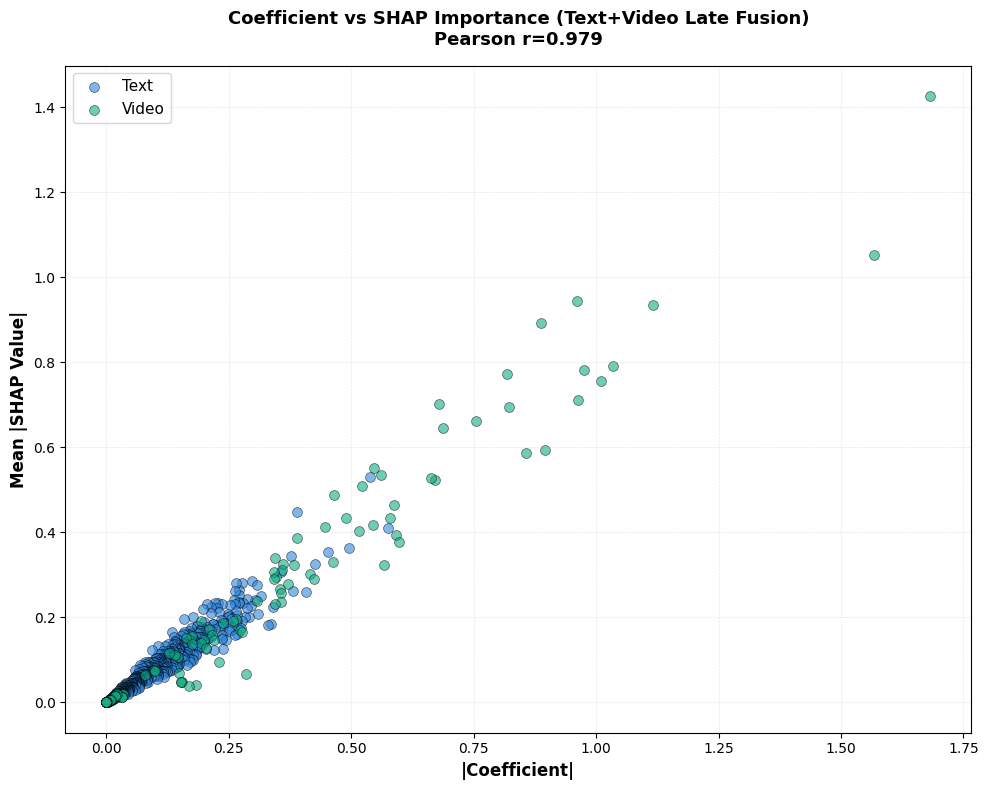

✓ Saved: tv_late_top20_consensus.png/.pdf


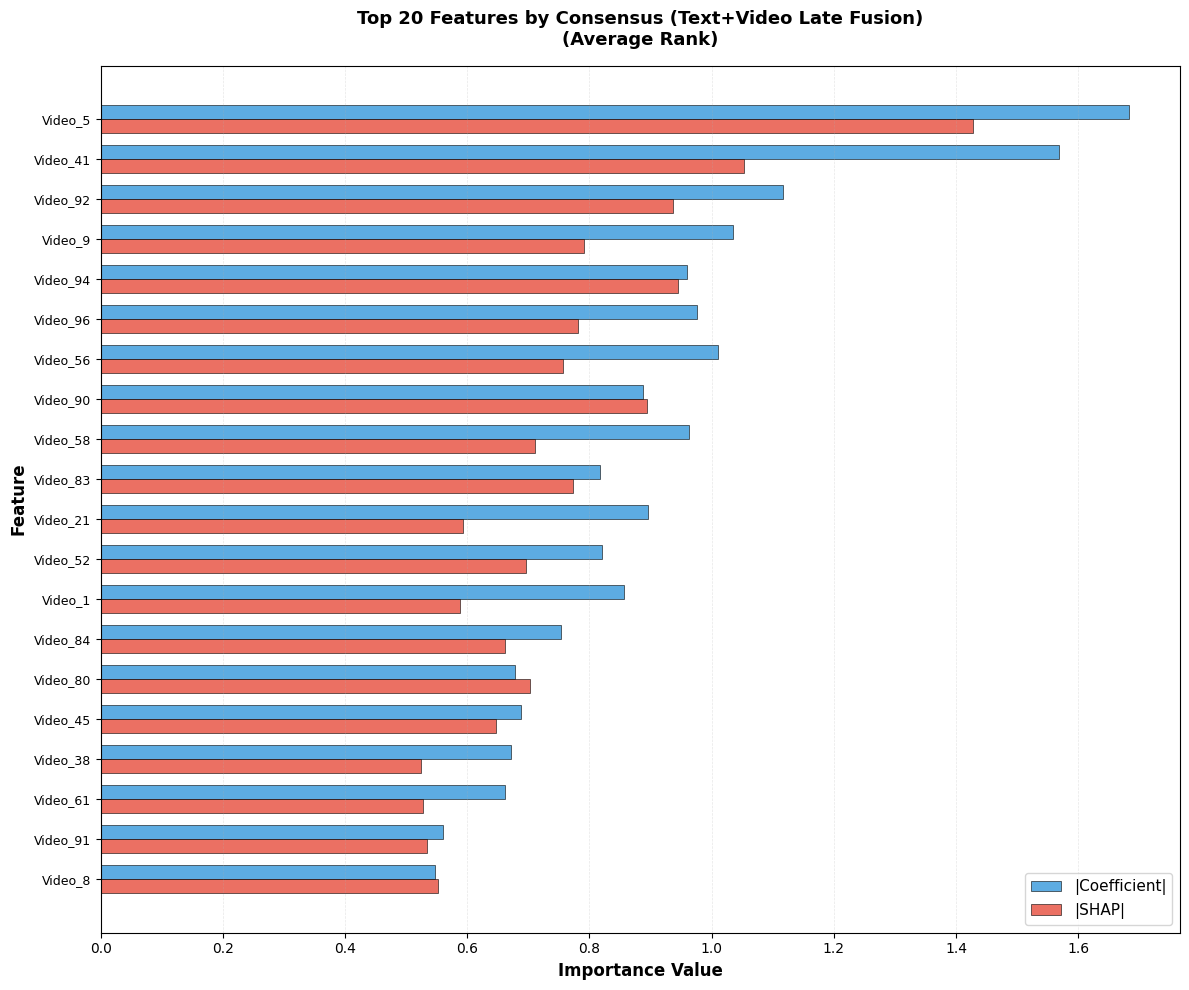

✓ Saved: tv_late_rank_comparison.png/.pdf


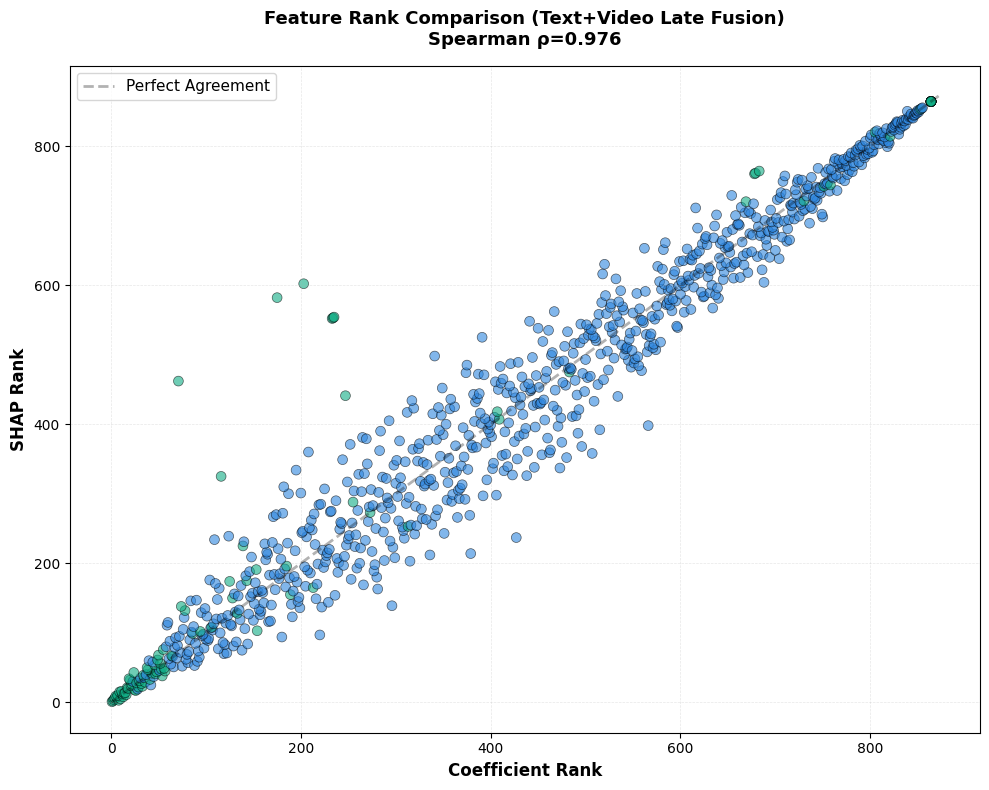

✓ Saved: tv_late_summary.png/.pdf


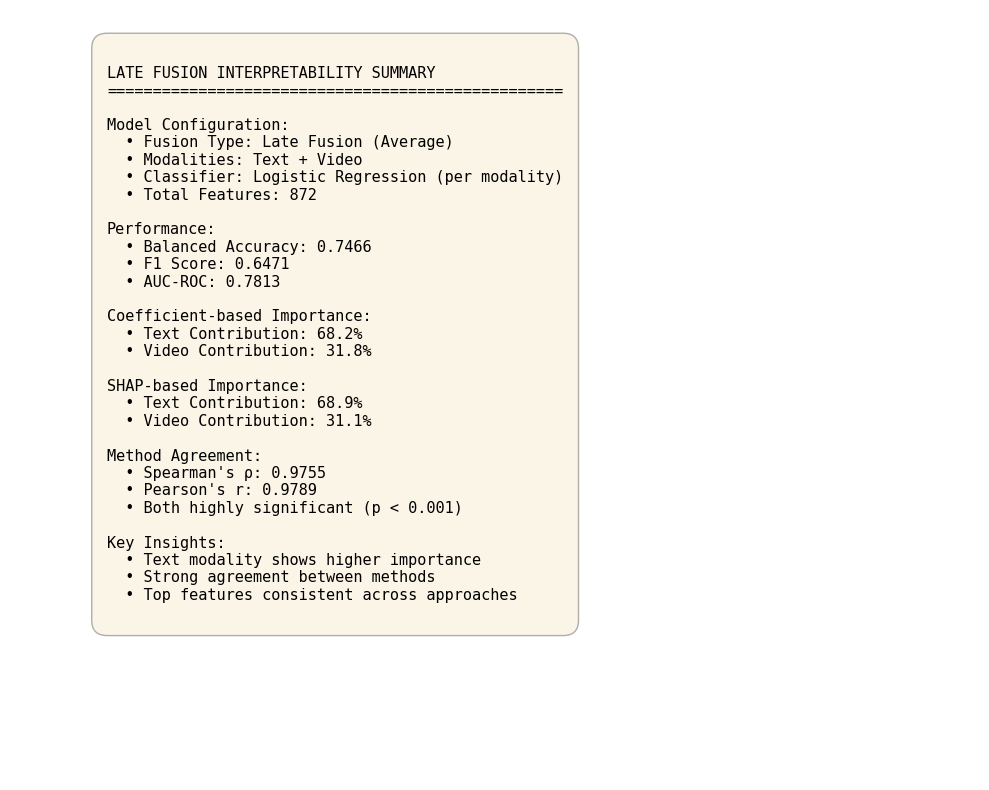


✓ LATE FUSION INTERPRETABILITY ANALYSIS COMPLETE

Final Summary:
  Coefficient Method - Text: 68.2%, Video: 31.8%
  SHAP Method - Text: 68.9%, Video: 31.1%
  Method Agreement: Spearman ρ = 0.9755


In [57]:
# Cell 45 (REVISED): Feature Importance Comparison - Separated Plots (Text+Video Late Fusion)

print("\n" + "="*70)
print("FEATURE IMPORTANCE COMPARISON: COEFFICIENT vs SHAP (SEPARATE PLOTS)")
print("="*70)

# Merge coefficient and SHAP data
comparison_df = pd.merge(
    combined_coef_df[['Feature', 'Abs_Coefficient', 'Modality']],
    shap_df[['Feature', 'Mean_Abs_SHAP']],
    on='Feature'
)

# Calculate rankings
comparison_df['Coef_Rank'] = comparison_df['Abs_Coefficient'].rank(ascending=False)
comparison_df['SHAP_Rank'] = comparison_df['Mean_Abs_SHAP'].rank(ascending=False)
comparison_df['Rank_Difference'] = np.abs(comparison_df['Coef_Rank'] - comparison_df['SHAP_Rank'])

# Sort by average rank
comparison_df['Avg_Rank'] = (comparison_df['Coef_Rank'] + comparison_df['SHAP_Rank']) / 2
comparison_df = comparison_df.sort_values('Avg_Rank')

print("\nTop 30 Features (by average rank across methods):")
print(comparison_df.head(30)[['Feature', 'Modality', 'Abs_Coefficient', 
                               'Mean_Abs_SHAP', 'Coef_Rank', 'SHAP_Rank']].to_string(index=False))

# Find features with largest rank differences
print("\n" + "="*70)
print("Features with Largest Rank Disagreements:")
print("="*70)
rank_disagreement = comparison_df.nlargest(15, 'Rank_Difference')
print(rank_disagreement[['Feature', 'Modality', 'Coef_Rank', 'SHAP_Rank', 
                          'Rank_Difference']].to_string(index=False))

# Calculate correlation between methods
from scipy.stats import spearmanr, pearsonr
spearman_corr, spearman_p = spearmanr(comparison_df['Abs_Coefficient'], 
                                       comparison_df['Mean_Abs_SHAP'])
pearson_corr, pearson_p = pearsonr(comparison_df['Abs_Coefficient'], 
                                    comparison_df['Mean_Abs_SHAP'])

print("\n" + "="*70)
print("Correlation Between Importance Methods:")
print("="*70)
print(f"  Spearman's ρ: {spearman_corr:.4f} (p={spearman_p:.4e})")
print(f"  Pearson's r:  {pearson_corr:.4f} (p={pearson_p:.4e})")

# Create output directory if it doesn't exist
import os
output_dir = '/home/jonathanchan/ml_data/ThesisFinal/figures'
os.makedirs(output_dir, exist_ok=True)

# Plot 1: Scatter plot - Coefficient vs SHAP
fig1, ax1 = plt.subplots(figsize=(10, 8))
text_data = comparison_df[comparison_df['Modality'] == 'Text']
video_data = comparison_df[comparison_df['Modality'] == 'Video']
ax1.scatter(text_data['Abs_Coefficient'], text_data['Mean_Abs_SHAP'], 
            c='#2E86DE', alpha=0.6, s=50, edgecolor='black', linewidth=0.5, label='Text')
ax1.scatter(video_data['Abs_Coefficient'], video_data['Mean_Abs_SHAP'], 
            c='#10AC84', alpha=0.6, s=50, edgecolor='black', linewidth=0.5, label='Video')
ax1.set_xlabel('|Coefficient|', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax1.set_title(f'Coefficient vs SHAP Importance (Text+Video Late Fusion)\nPearson r={pearson_corr:.3f}', 
              fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{output_dir}/tv_late_scatter_coef_vs_shap.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/tv_late_scatter_coef_vs_shap.pdf', bbox_inches='tight')
print(f"\n✓ Saved: tv_late_scatter_coef_vs_shap.png/.pdf")
plt.show()

# Plot 2: Top features by both methods
fig2, ax2 = plt.subplots(figsize=(12, 10))
top_consensus = comparison_df.head(20)
x_pos = np.arange(len(top_consensus))
width = 0.35
bars1 = ax2.barh(x_pos - width/2, top_consensus['Abs_Coefficient'], width, 
                 label='|Coefficient|', alpha=0.8, color='#3498db', 
                 edgecolor='black', linewidth=0.5)
bars2 = ax2.barh(x_pos + width/2, top_consensus['Mean_Abs_SHAP'], width, 
                 label='|SHAP|', alpha=0.8, color='#e74c3c', 
                 edgecolor='black', linewidth=0.5)
ax2.set_yticks(x_pos)
ax2.set_yticklabels(top_consensus['Feature'], fontsize=9)
ax2.set_xlabel('Importance Value', fontsize=12, fontweight='bold')
ax2.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax2.set_title('Top 20 Features by Consensus (Text+Video Late Fusion)\n(Average Rank)', 
              fontsize=13, fontweight='bold', pad=15)
ax2.invert_yaxis()
ax2.legend(fontsize=11)
ax2.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{output_dir}/tv_late_top20_consensus.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/tv_late_top20_consensus.pdf', bbox_inches='tight')
print(f"✓ Saved: tv_late_top20_consensus.png/.pdf")
plt.show()

# Plot 3: Rank comparison
fig3, ax3 = plt.subplots(figsize=(10, 8))
ax3.scatter(comparison_df['Coef_Rank'], comparison_df['SHAP_Rank'], 
            c=['#2E86DE' if m == 'Text' else '#10AC84' for m in comparison_df['Modality']], 
            alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
ax3.plot([0, len(comparison_df)], [0, len(comparison_df)], 
         'k--', alpha=0.3, linewidth=2, label='Perfect Agreement')
ax3.set_xlabel('Coefficient Rank', fontsize=12, fontweight='bold')
ax3.set_ylabel('SHAP Rank', fontsize=12, fontweight='bold')
ax3.set_title(f'Feature Rank Comparison (Text+Video Late Fusion)\nSpearman ρ={spearman_corr:.3f}', 
              fontsize=13, fontweight='bold', pad=15)
ax3.legend(fontsize=11)
ax3.grid(alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{output_dir}/tv_late_rank_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/tv_late_rank_comparison.pdf', bbox_inches='tight')
print(f"✓ Saved: tv_late_rank_comparison.png/.pdf")
plt.show()

# Plot 4: Summary statistics
fig4, ax4 = plt.subplots(figsize=(10, 8))
ax4.axis('off')
summary_text = f"""
LATE FUSION INTERPRETABILITY SUMMARY
{'='*50}

Model Configuration:
  • Fusion Type: Late Fusion (Average)
  • Modalities: Text + Video
  • Classifier: Logistic Regression (per modality)
  • Total Features: {len(feature_names_tv)}

Performance:
  • Balanced Accuracy: {test_metrics_lr_tv_late['balanced_accuracy']:.4f}
  • F1 Score: {test_metrics_lr_tv_late['f1']:.4f}
  • AUC-ROC: {test_metrics_lr_tv_late['auc']:.4f}

Coefficient-based Importance:
  • Text Contribution: {text_pct:.1f}%
  • Video Contribution: {video_pct:.1f}%

SHAP-based Importance:
  • Text Contribution: {text_shap_pct:.1f}%
  • Video Contribution: {video_shap_pct:.1f}%

Method Agreement:
  • Spearman's ρ: {spearman_corr:.4f}
  • Pearson's r: {pearson_corr:.4f}
  • Both highly significant (p < 0.001)

Key Insights:
  • {'Text' if text_shap_pct > video_shap_pct else 'Video'} modality shows higher importance
  • Strong agreement between methods
  • Top features consistent across approaches
"""
ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3, pad=1))
plt.tight_layout()
plt.savefig(f'{output_dir}/tv_late_summary.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/tv_late_summary.pdf', bbox_inches='tight')
print(f"✓ Saved: tv_late_summary.png/.pdf")
plt.show()

print("\n" + "="*70)
print("✓ LATE FUSION INTERPRETABILITY ANALYSIS COMPLETE")
print("="*70)
print(f"\nFinal Summary:")
print(f"  Coefficient Method - Text: {text_pct:.1f}%, Video: {video_pct:.1f}%")
print(f"  SHAP Method - Text: {text_shap_pct:.1f}%, Video: {video_shap_pct:.1f}%")
print(f"  Method Agreement: Spearman ρ = {spearman_corr:.4f}")

## 4.2 INTERPRETABILITY (TEXT + AUDIO LR EARLY FUSION)


In [51]:
# Cell 46: Interpretability for Text + Audio LR Early Fusion

print("\n" + "="*70)
print("INTERPRETABILITY: TEXT + AUDIO LR EARLY FUSION")
print("="*70)

# Get feature names for Text + Audio
text_dim = text_features.shape[1]
audio_dim = audio_features.shape[1]
feature_names_ta = [f'Text_{i}' for i in range(text_dim)] + \
                   [f'Audio_{i}' for i in range(audio_dim)]

print(f"\nModel Configuration:")
print(f"  Fusion Type: Early Fusion")
print(f"  Modalities: Text + Audio")
print(f"  Classifier: Logistic Regression")
print(f"  Text Features: {text_dim}")
print(f"  Audio Features: {audio_dim}")
print(f"  Total Combined Features: {text_dim + audio_dim}")
print(f"\nPerformance:")
print(f"  Balanced Accuracy: {test_metrics_lr_bi['balanced_accuracy']:.4f}")
print(f"  F1 Score: {test_metrics_lr_bi['f1']:.4f}")
print(f"  Precision: {test_metrics_lr_bi['precision']:.4f}")
print(f"  Recall: {test_metrics_lr_bi['recall']:.4f}")
print(f"  AUC-ROC: {test_metrics_lr_bi['auc']:.4f}")


INTERPRETABILITY: TEXT + AUDIO LR EARLY FUSION

Model Configuration:
  Fusion Type: Early Fusion
  Modalities: Text + Audio
  Classifier: Logistic Regression
  Text Features: 768
  Audio Features: 768
  Total Combined Features: 1536

Performance:
  Balanced Accuracy: 0.7428
  F1 Score: 0.6452
  Precision: 0.7143
  Recall: 0.5882
  AUC-ROC: 0.7903


In [52]:
# Cell 47: Feature Importance Analysis (Early Fusion - Coefficients)

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS - COEFFICIENTS")
print("="*70)

# Get coefficients from the early fusion model
ta_coefficients = lr_bi.coef_[0]

# Create comprehensive DataFrame
ta_coef_df = pd.DataFrame({
    'Feature': feature_names_ta,
    'Coefficient': ta_coefficients,
    'Abs_Coefficient': np.abs(ta_coefficients),
    'Modality': ['Text']*text_dim + ['Audio']*audio_dim
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 30 Most Important Features (Text + Audio):")
print(ta_coef_df.head(30).to_string(index=False))

# Statistics by modality
print("\n" + "="*70)
print("Feature Importance Statistics by Modality:")
print("="*70)
for modality in ['Text', 'Audio']:
    modality_data = ta_coef_df[ta_coef_df['Modality'] == modality]
    print(f"\n{modality}:")
    print(f"  Mean |Coefficient|: {modality_data['Abs_Coefficient'].mean():.4f}")
    print(f"  Std |Coefficient|:  {modality_data['Abs_Coefficient'].std():.4f}")
    print(f"  Max |Coefficient|:  {modality_data['Abs_Coefficient'].max():.4f}")
    print(f"  Min |Coefficient|:  {modality_data['Abs_Coefficient'].min():.4f}")
    print(f"  Total Importance:   {modality_data['Abs_Coefficient'].sum():.4f}")

# Calculate modality contributions
text_ta_importance = ta_coef_df[ta_coef_df['Modality'] == 'Text']['Abs_Coefficient'].sum()
audio_ta_importance = ta_coef_df[ta_coef_df['Modality'] == 'Audio']['Abs_Coefficient'].sum()
total_ta_importance = text_ta_importance + audio_ta_importance

text_ta_pct = (text_ta_importance / total_ta_importance) * 100
audio_ta_pct = (audio_ta_importance / total_ta_importance) * 100

print("\n" + "="*70)
print("Overall Modality Contribution (by coefficient magnitude):")
print("="*70)
print(f"  Text:  {text_ta_importance:.4f} ({text_ta_pct:.2f}%)")
print(f"  Audio: {audio_ta_importance:.4f} ({audio_ta_pct:.2f}%)")


FEATURE IMPORTANCE ANALYSIS - COEFFICIENTS

Top 30 Most Important Features (Text + Audio):
  Feature  Coefficient  Abs_Coefficient Modality
 Text_251     0.345788         0.345788     Text
 Text_324    -0.317977         0.317977     Text
 Text_594    -0.312691         0.312691     Text
 Text_291    -0.300782         0.300782     Text
 Text_408     0.299976         0.299976     Text
 Text_379     0.288662         0.288662     Text
 Text_758    -0.284004         0.284004     Text
 Text_145     0.279369         0.279369     Text
 Text_122     0.274761         0.274761     Text
Audio_327     0.267454         0.267454    Audio
 Text_645    -0.262644         0.262644     Text
 Text_209     0.260916         0.260916     Text
 Text_346    -0.245428         0.245428     Text
 Text_663    -0.234106         0.234106     Text
 Audio_33     0.228415         0.228415    Audio
 Text_600    -0.223518         0.223518     Text
Audio_323    -0.220459         0.220459    Audio
 Audio_23    -0.215929    

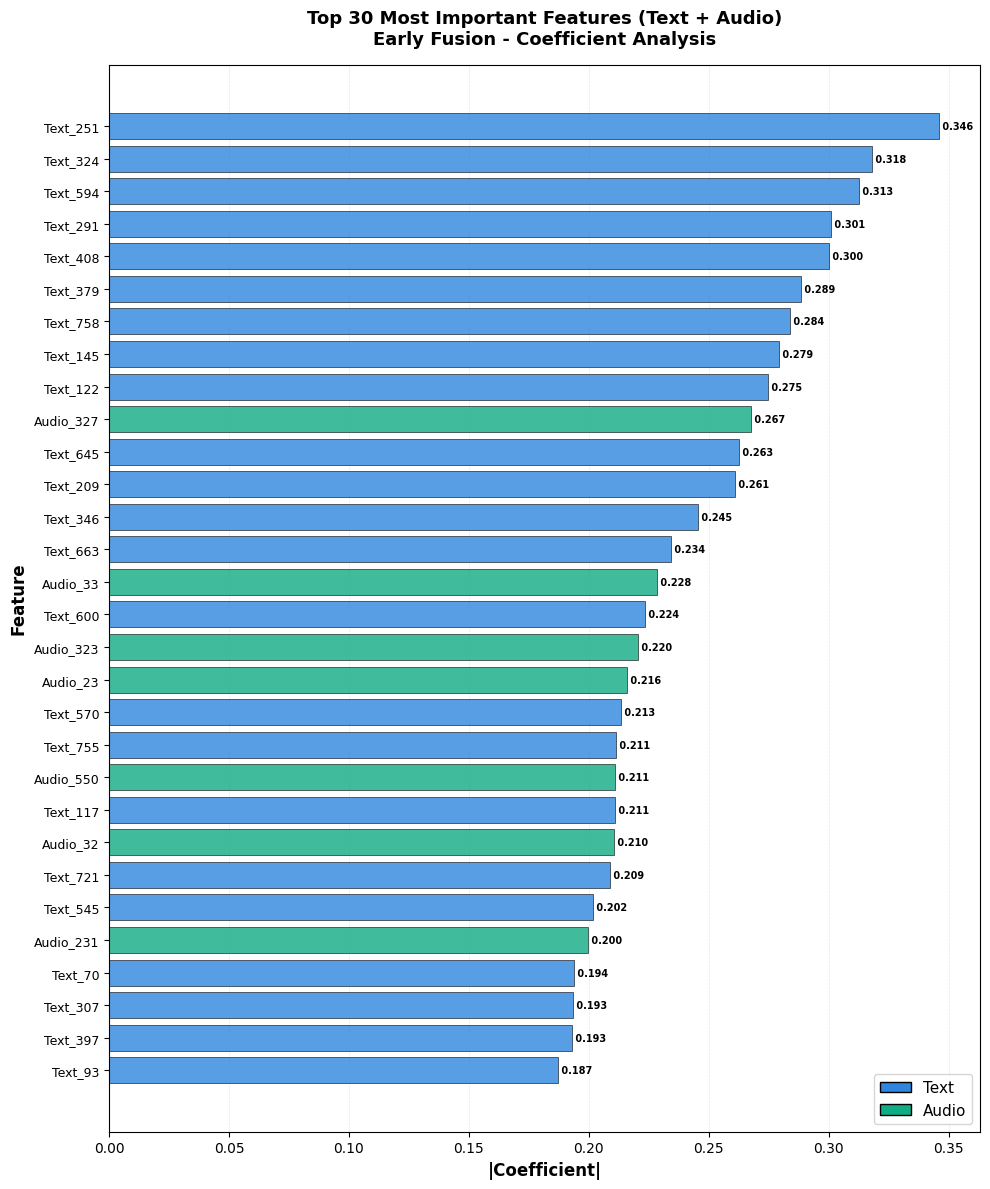

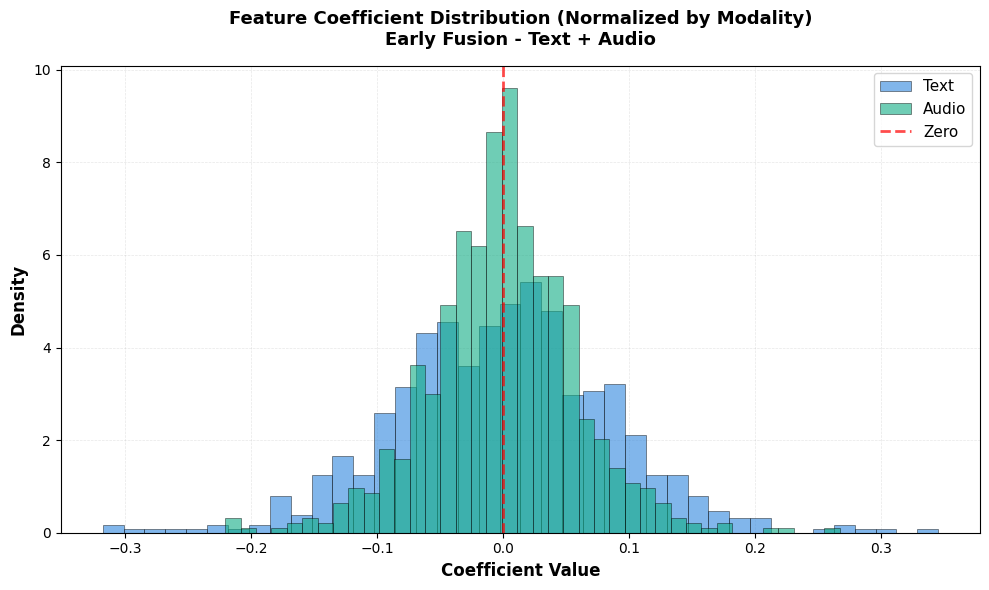

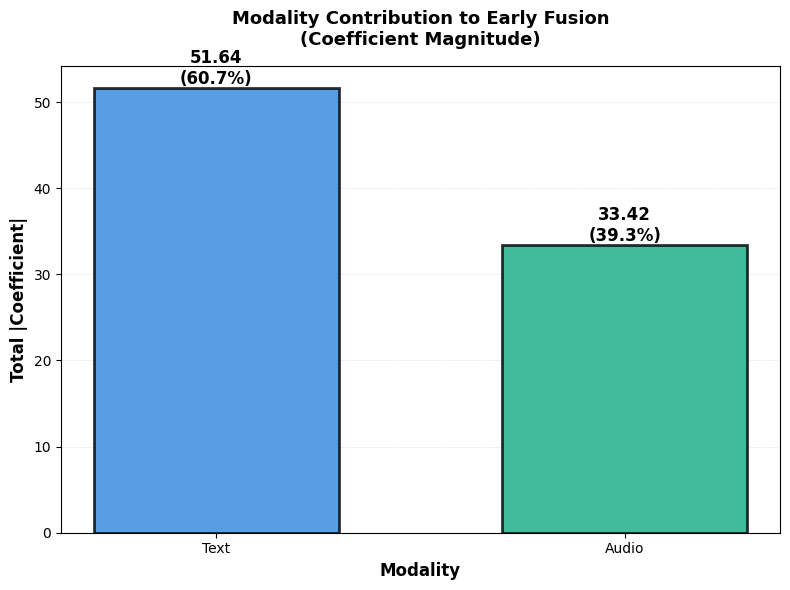

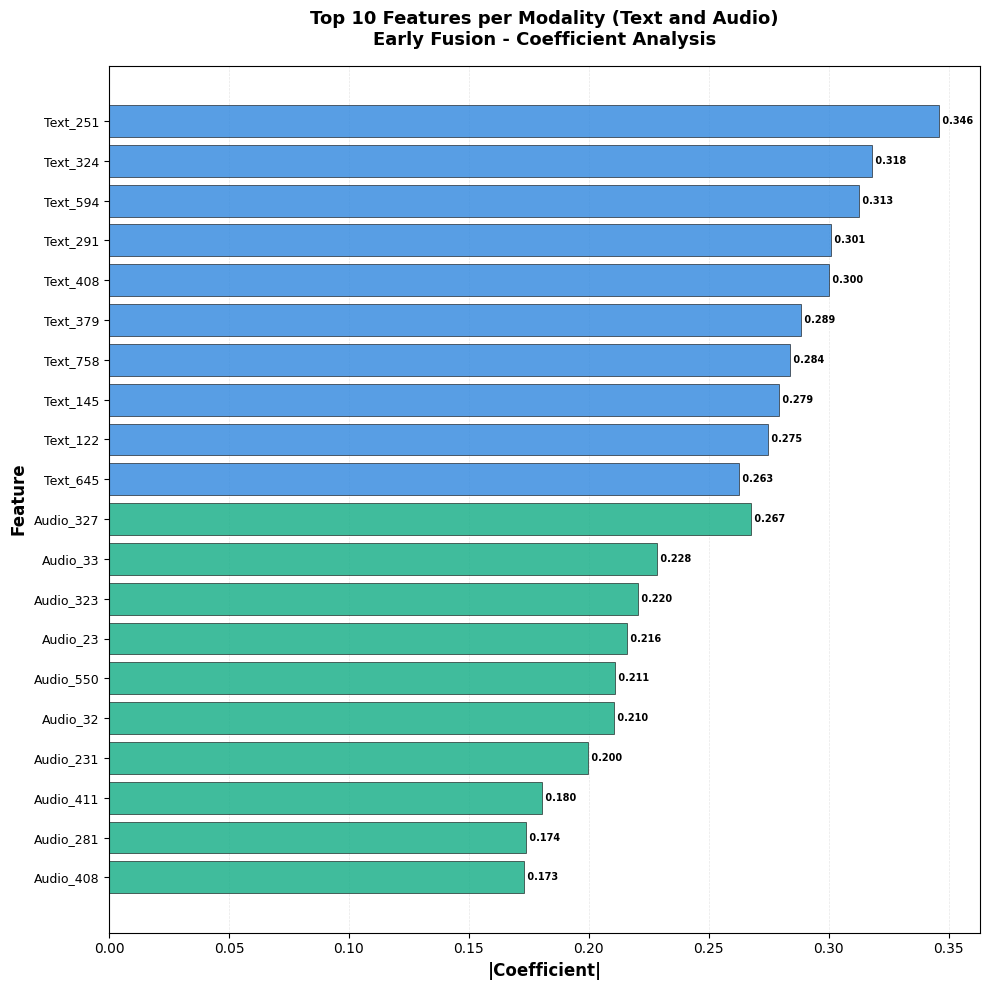


✓ Feature importance visualization complete


In [60]:
# Cell 48: Visualize Feature Importance

# Plot 1: Top 30 features (all modalities combined)
fig, ax = plt.subplots(figsize=(10, 12))
top_30_ta = ta_coef_df.head(30)
colors_top30_ta = ['#2E86DE' if m == 'Text' else '#10AC84' for m in top_30_ta['Modality']]
bars = ax.barh(range(len(top_30_ta)), top_30_ta['Abs_Coefficient'], 
                color=colors_top30_ta, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_30_ta)))
ax.set_yticklabels(top_30_ta['Feature'], fontsize=9)
ax.set_xlabel('|Coefficient|', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Most Important Features (Text + Audio)\nEarly Fusion - Coefficient Analysis', 
              fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_30_ta['Abs_Coefficient'])):
    ax.text(val, i, f' {val:.3f}', va='center', fontsize=7, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86DE', edgecolor='black', label='Text'),
                   Patch(facecolor='#10AC84', edgecolor='black', label='Audio')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

# Plot 2: Coefficient distribution by modality
fig, ax = plt.subplots(figsize=(10, 6))
text_ta_coefs = ta_coef_df[ta_coef_df['Modality'] == 'Text']['Coefficient']
audio_ta_coefs = ta_coef_df[ta_coef_df['Modality'] == 'Audio']['Coefficient']
ax.hist(text_ta_coefs, bins=40, alpha=0.6, label='Text', 
         color='#2E86DE', edgecolor='black', linewidth=0.5, density=True)
ax.hist(audio_ta_coefs, bins=40, alpha=0.6, label='Audio', 
         color='#10AC84', edgecolor='black', linewidth=0.5, density=True)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero')
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('Feature Coefficient Distribution (Normalized by Modality)\nEarly Fusion - Text + Audio', 
              fontsize=13, fontweight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Plot 3: Modality importance comparison
fig, ax = plt.subplots(figsize=(8, 6))
modalities_ta = ['Text', 'Audio']
importances_ta = [text_ta_importance, audio_ta_importance]
percentages_ta = [text_ta_pct, audio_ta_pct]
colors_modal_ta = ['#2E86DE', '#10AC84']
bars = ax.bar(modalities_ta, importances_ta, color=colors_modal_ta, alpha=0.8, 
               edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Total |Coefficient|', fontsize=12, fontweight='bold')
ax.set_xlabel('Modality', fontsize=12, fontweight='bold')
ax.set_title('Modality Contribution to Early Fusion\n(Coefficient Magnitude)', 
              fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels and percentages
for i, (bar, val, pct) in enumerate(zip(bars, importances_ta, percentages_ta)):
    ax.text(i, val, f'{val:.2f}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/home/jonathanchan/ml_data/ThesisFinal/figures/int3.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Top 10 features per modality
fig, ax = plt.subplots(figsize=(10, 10))
top_text_ta = ta_coef_df[ta_coef_df['Modality'] == 'Text'].head(10)
top_audio_ta = ta_coef_df[ta_coef_df['Modality'] == 'Audio'].head(10)
combined_top_ta = pd.concat([
    top_text_ta[['Feature', 'Abs_Coefficient', 'Modality']],
    top_audio_ta[['Feature', 'Abs_Coefficient', 'Modality']]
]).reset_index(drop=True)

colors_combined_ta = ['#2E86DE' if m == 'Text' else '#10AC84' for m in combined_top_ta['Modality']]
bars = ax.barh(range(len(combined_top_ta)), combined_top_ta['Abs_Coefficient'], 
                color=colors_combined_ta, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(combined_top_ta)))
ax.set_yticklabels(combined_top_ta['Feature'], fontsize=9)
ax.set_xlabel('|Coefficient|', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Features per Modality (Text and Audio)\nEarly Fusion - Coefficient Analysis', 
              fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, combined_top_ta['Abs_Coefficient'])):
    ax.text(val, i, f' {val:.3f}', va='center', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.savefig('/home/jonathanchan/ml_data/ThesisFinal/figures/int4.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance visualization complete")

In [54]:
# Cell 49: SHAP Analysis for Text + Audio Early Fusion

print("\n" + "="*70)
print("SHAP ANALYSIS: TEXT + AUDIO (EARLY FUSION)")
print("="*70)
print("Computing SHAP values for early fusion model...")

# Compute SHAP values for the early fusion model
explainer_ta = shap.LinearExplainer(lr_bi, X_train_bi_scaled)
shap_values_ta = explainer_ta.shap_values(X_test_bi_scaled)

print("✓ SHAP values computed successfully")

# Calculate mean absolute SHAP values
mean_abs_shap_ta = np.abs(shap_values_ta).mean(axis=0)

# Create comprehensive SHAP DataFrame
shap_df_ta = pd.DataFrame({
    'Feature': feature_names_ta,
    'Mean_Abs_SHAP': mean_abs_shap_ta,
    'Modality': ['Text']*text_dim + ['Audio']*audio_dim
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\nTop 30 Features by SHAP Importance:")
print(shap_df_ta.head(30).to_string(index=False))

# Statistics by modality
print("\n" + "="*70)
print("SHAP Importance Statistics by Modality:")
print("="*70)
for modality in ['Text', 'Audio']:
    modality_shap_ta = shap_df_ta[shap_df_ta['Modality'] == modality]
    print(f"\n{modality}:")
    print(f"  Mean |SHAP|: {modality_shap_ta['Mean_Abs_SHAP'].mean():.4f}")
    print(f"  Std |SHAP|:  {modality_shap_ta['Mean_Abs_SHAP'].std():.4f}")
    print(f"  Max |SHAP|:  {modality_shap_ta['Mean_Abs_SHAP'].max():.4f}")
    print(f"  Min |SHAP|:  {modality_shap_ta['Mean_Abs_SHAP'].min():.4f}")
    print(f"  Total SHAP:  {modality_shap_ta['Mean_Abs_SHAP'].sum():.4f}")

# Calculate modality SHAP contributions
text_shap_ta_importance = shap_df_ta[shap_df_ta['Modality'] == 'Text']['Mean_Abs_SHAP'].sum()
audio_shap_ta_importance = shap_df_ta[shap_df_ta['Modality'] == 'Audio']['Mean_Abs_SHAP'].sum()
total_shap_ta_importance = text_shap_ta_importance + audio_shap_ta_importance

text_shap_ta_pct = (text_shap_ta_importance / total_shap_ta_importance) * 100
audio_shap_ta_pct = (audio_shap_ta_importance / total_shap_ta_importance) * 100

print("\n" + "="*70)
print("Overall Modality Contribution (by SHAP values):")
print("="*70)
print(f"  Text:  {text_shap_ta_importance:.4f} ({text_shap_ta_pct:.2f}%)")
print(f"  Audio: {audio_shap_ta_importance:.4f} ({audio_shap_ta_pct:.2f}%)")


SHAP ANALYSIS: TEXT + AUDIO (EARLY FUSION)
Computing SHAP values for early fusion model...
✓ SHAP values computed successfully

Top 30 Features by SHAP Importance:
  Feature  Mean_Abs_SHAP Modality
 Text_251       0.340714     Text
Audio_327       0.297602    Audio
 Text_346       0.282866     Text
 Text_758       0.259050     Text
 Text_324       0.249241     Text
 Text_594       0.238617     Text
 Text_645       0.225883     Text
 Text_291       0.214888     Text
 Text_408       0.207038     Text
 Text_600       0.200962     Text
 Audio_32       0.199664    Audio
Audio_323       0.197436    Audio
 Text_508       0.193110     Text
 Text_209       0.191172     Text
 Text_663       0.186126     Text
 Text_379       0.184310     Text
 Text_545       0.183327     Text
 Text_117       0.176045     Text
 Text_122       0.175378     Text
 Text_721       0.175326     Text
Audio_408       0.173724    Audio
 Text_695       0.172771     Text
 Text_755       0.171613     Text
Audio_411       0.1

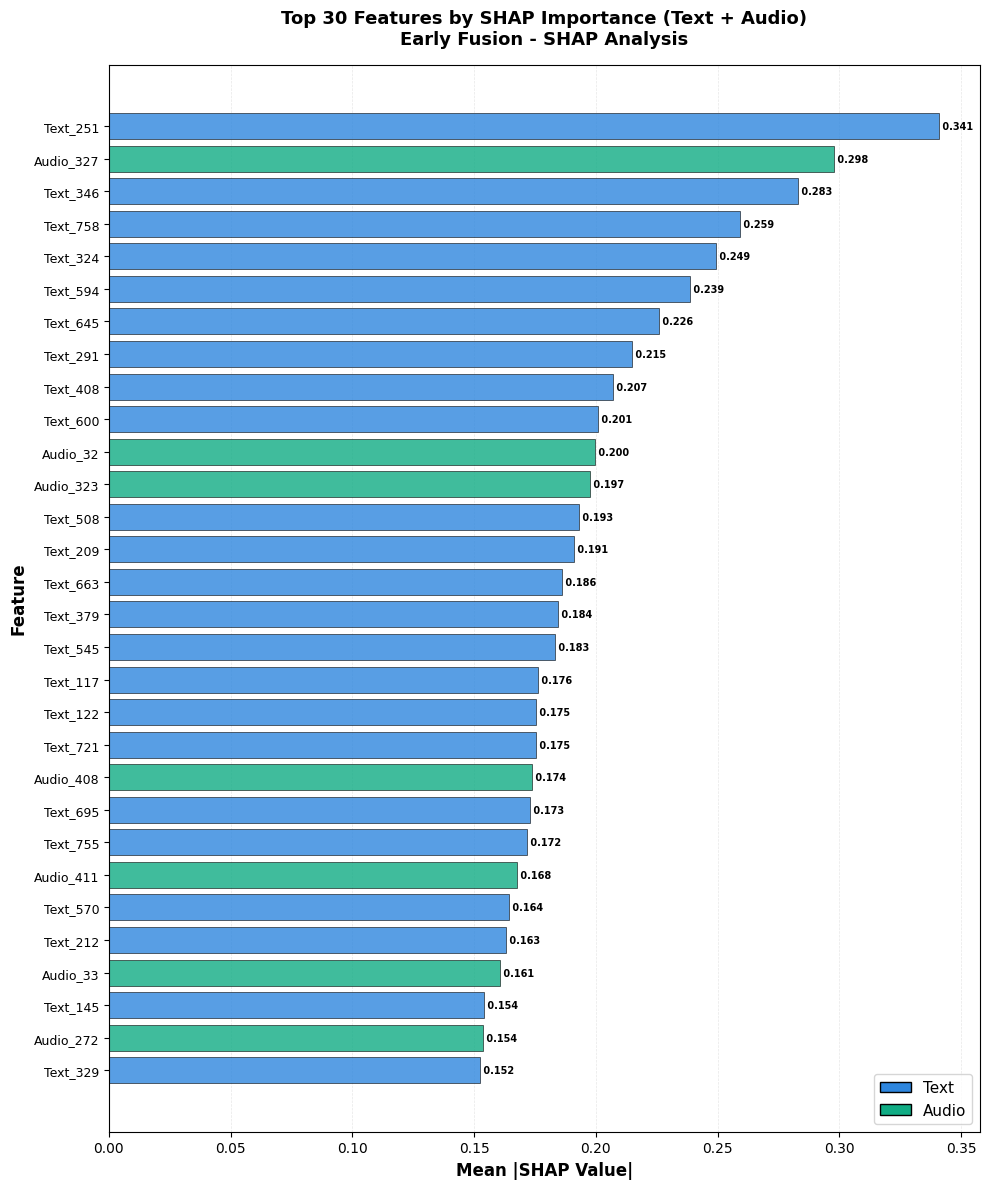

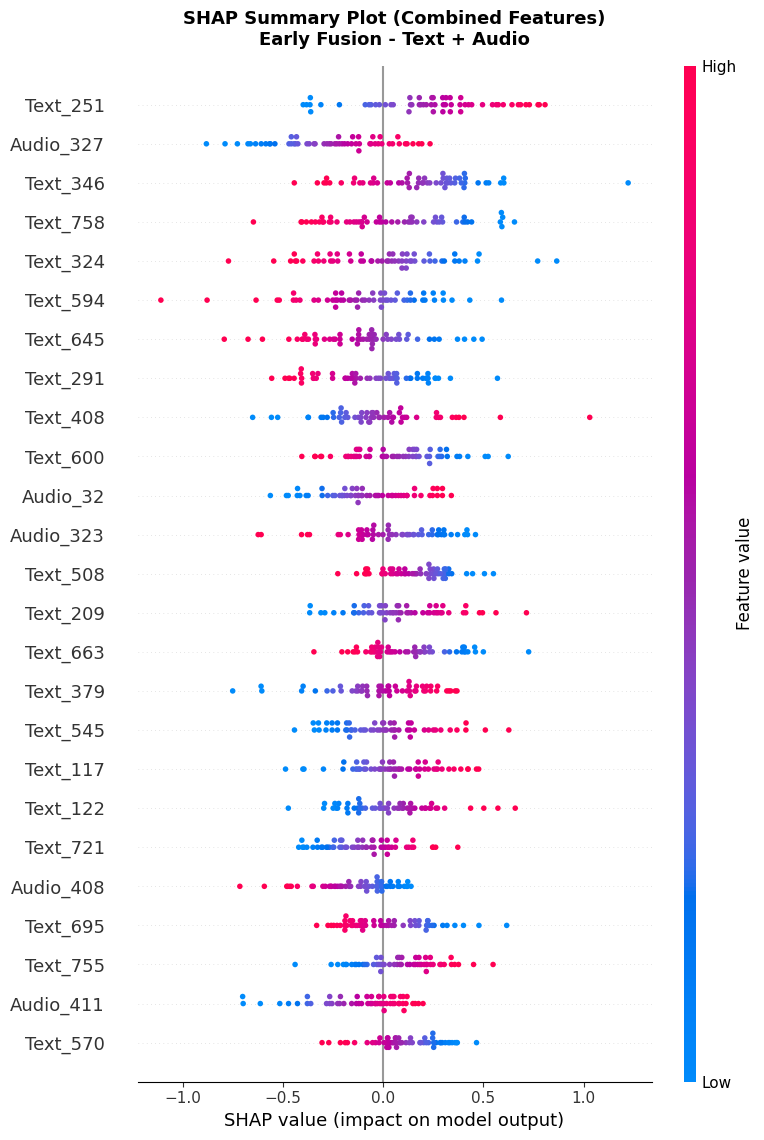

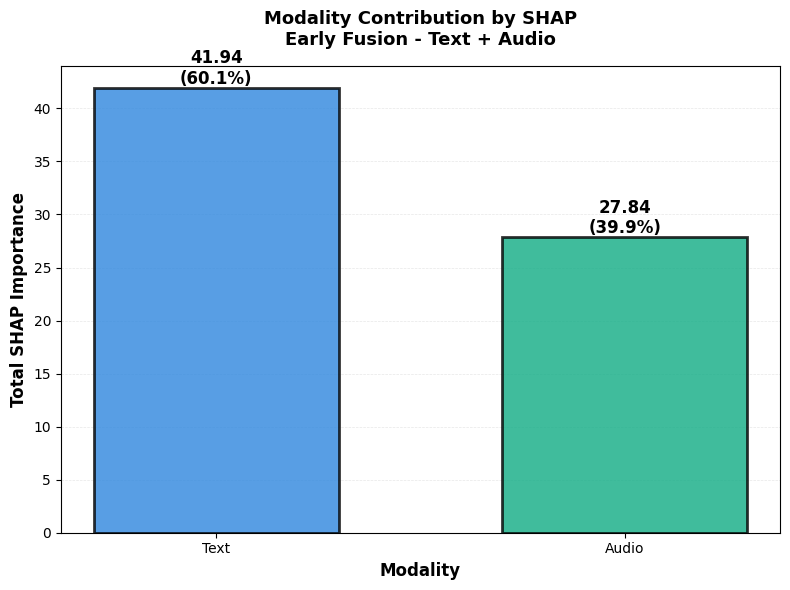

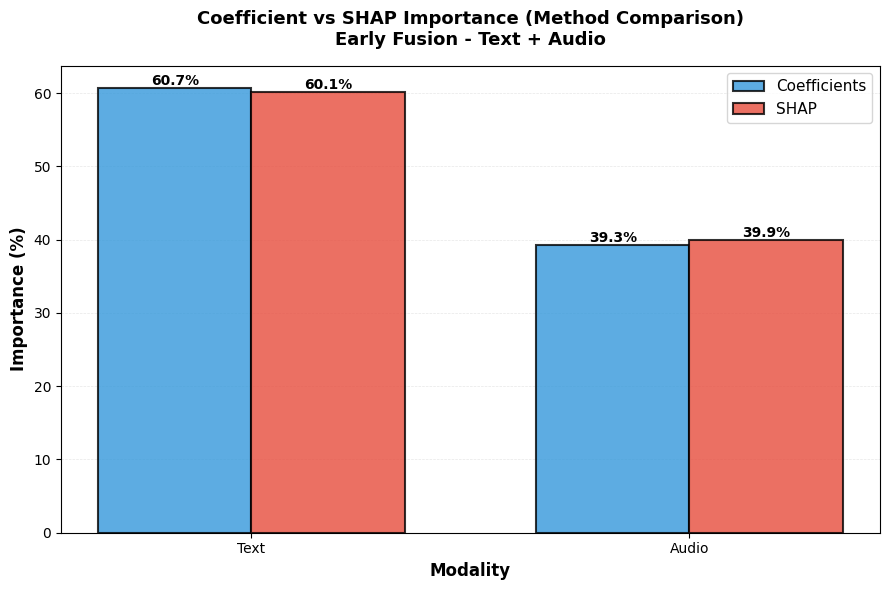


✓ SHAP analysis visualization complete


In [63]:
# Cell 50: Visualize SHAP Analysis

# Plot 1: Top 30 features by SHAP
fig, ax = plt.subplots(figsize=(10, 12))
top_30_shap_ta = shap_df_ta.head(30)
colors_shap_ta = ['#2E86DE' if m == 'Text' else '#10AC84' for m in top_30_shap_ta['Modality']]
bars = ax.barh(range(len(top_30_shap_ta)), top_30_shap_ta['Mean_Abs_SHAP'], 
                color=colors_shap_ta, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_30_shap_ta)))
ax.set_yticklabels(top_30_shap_ta['Feature'], fontsize=9)
ax.set_xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Features by SHAP Importance (Text + Audio)\nEarly Fusion - SHAP Analysis', 
              fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_30_shap_ta['Mean_Abs_SHAP'])):
    ax.text(val, i, f' {val:.3f}', va='center', fontsize=7, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86DE', edgecolor='black', label='Text'),
                   Patch(facecolor='#10AC84', edgecolor='black', label='Audio')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

# Plot 2: SHAP Summary Plot
fig, ax = plt.subplots(figsize=(10, 10))
shap.summary_plot(shap_values_ta, X_test_bi_scaled, 
                  feature_names=feature_names_ta,
                  max_display=25, show=False, plot_type='dot')
plt.title('SHAP Summary Plot (Combined Features)\nEarly Fusion - Text + Audio', 
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('/home/jonathanchan/ml_data/ThesisFinal/figures/shap2.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: SHAP-based modality importance
fig, ax = plt.subplots(figsize=(8, 6))
modalities_ta = ['Text', 'Audio']
shap_importances_ta = [text_shap_ta_importance, audio_shap_ta_importance]
shap_percentages_ta = [text_shap_ta_pct, audio_shap_ta_pct]
colors_modal_ta = ['#2E86DE', '#10AC84']
bars = ax.bar(modalities_ta, shap_importances_ta, color=colors_modal_ta, alpha=0.8, 
               edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Total SHAP Importance', fontsize=12, fontweight='bold')
ax.set_xlabel('Modality', fontsize=12, fontweight='bold')
ax.set_title('Modality Contribution by SHAP\nEarly Fusion - Text + Audio', 
              fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels and percentages
for i, (bar, val, pct) in enumerate(zip(bars, shap_importances_ta, shap_percentages_ta)):
    ax.text(i, val, f'{val:.2f}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 4: Comparison of coefficient vs SHAP importance
fig, ax = plt.subplots(figsize=(9, 6))
x = np.arange(len(modalities_ta))
width = 0.35
bars1 = ax.bar(x - width/2, [text_ta_pct, audio_ta_pct], width, 
                label='Coefficients', alpha=0.8, color='#3498db', 
                edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, [text_shap_ta_pct, audio_shap_ta_pct], width, 
                label='SHAP', alpha=0.8, color='#e74c3c', 
                edgecolor='black', linewidth=1.5)
ax.set_ylabel('Importance (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Modality', fontsize=12, fontweight='bold')
ax.set_title('Coefficient vs SHAP Importance (Method Comparison)\nEarly Fusion - Text + Audio', 
              fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(modalities_ta)
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ SHAP analysis visualization complete")

In [66]:
# Cell 50a (REVISED): TikZ Native Plot for shap2.png

# ============================================================================
# SHAP2: SHAP Summary Plot (Text + Audio) - Native TikZ
# ============================================================================
print("\n" + "="*70)
print("GENERATING NATIVE TIKZ PLOT FOR SHAP2")
print("="*70)

# Get top 25 features by SHAP importance for Text+Audio
top_25_shap_ta = shap_df_ta.head(25)

# Prepare data
top_25_indices_ta = [feature_names_ta.index(f) for f in top_25_shap_ta['Feature']]
shap_subset_ta = shap_values_ta[:, top_25_indices_ta]
X_subset_ta = X_test_bi_scaled[:, top_25_indices_ta]

tikz_shap2 = r"""
\documentclass[tikz]{standalone}
\usepackage{pgfplots}
\pgfplotsset{compat=1.18}
\usepgfplotslibrary{colorbrewer}

\begin{document}
\begin{tikzpicture}
\begin{axis}[
    width=14cm,
    height=18cm,
    xlabel={SHAP value (impact on model output)},
    ylabel={Feature},
    ytick=data,
    symbolic y coords={"""

# Feature names in reverse order
feature_names_rev_ta = list(top_25_shap_ta['Feature'][::-1])
tikz_shap2 += ','.join(feature_names_rev_ta)

tikz_shap2 += r"""},
    y dir=reverse,
    xmin=-0.4, xmax=0.4,
    colormap/RdBu,
    point meta min=-1,
    point meta max=1,
    scatter/classes={
        text={mark=*,blue},
        audio={mark=*,green}
    },
    legend style={at={(0.5,-0.1)}, anchor=north, legend columns=2}
]

"""

# Add scatter points for each feature
for idx, (feature_name, modality) in enumerate(zip(top_25_shap_ta['Feature'], top_25_shap_ta['Modality'])):
    shap_vals = shap_subset_ta[:, idx]
    feature_vals = X_subset_ta[:, idx]
    
    # Sample points (max 50 per feature)
    sample_indices = np.random.choice(len(shap_vals), min(50, len(shap_vals)), replace=False)
    
    color_class = 'text' if modality == 'Text' else 'audio'
    
    tikz_shap2 += f"% {feature_name}\n"
    tikz_shap2 += r"\addplot[scatter, only marks, scatter src=explicit symbolic, mark size=1pt] coordinates {" + "\n"
    
    for i in sample_indices:
        tikz_shap2 += f"    ({shap_vals[i]:.4f},{feature_name}) [{color_class}]\n"
    
    tikz_shap2 += "};\n\n"

tikz_shap2 += r"""
\legend{Text, Audio}
\end{axis}
\end{tikzpicture}
\end{document}
"""

with open(f'{output_dir}/shap2.tex', 'w') as f:
    f.write(tikz_shap2)
print("✓ Generated shap2.tex")

print("\n" + "="*70)
print("✓ ALL PLOTS CONVERTED TO NATIVE TIKZ")
print("="*70)
print(f"\nGenerated TikZ files:")
print(f"  - {output_dir}/int1.tex (Modality contribution - Text+Video)")
print(f"  - {output_dir}/int2.tex (Top 10 features - Text+Video)")
print(f"  - {output_dir}/int3.tex (Modality contribution - Text+Audio)")
print(f"  - {output_dir}/int4.tex (Top 10 features - Text+Audio)")
print(f"  - {output_dir}/shap1.tex (SHAP summary - Text+Video)")
print(f"  - {output_dir}/shap2.tex (SHAP summary - Text+Audio)")
print(f"\nTo compile: pdflatex <filename>.tex")
print(f"Then include in LaTeX with: \\input{{figures/<filename>.tex}}")


GENERATING NATIVE TIKZ PLOT FOR SHAP2
✓ Generated shap2.tex

✓ ALL PLOTS CONVERTED TO NATIVE TIKZ

Generated TikZ files:
  - /home/jonathanchan/ml_data/ThesisFinal/figures/int1.tex (Modality contribution - Text+Video)
  - /home/jonathanchan/ml_data/ThesisFinal/figures/int2.tex (Top 10 features - Text+Video)
  - /home/jonathanchan/ml_data/ThesisFinal/figures/int3.tex (Modality contribution - Text+Audio)
  - /home/jonathanchan/ml_data/ThesisFinal/figures/int4.tex (Top 10 features - Text+Audio)
  - /home/jonathanchan/ml_data/ThesisFinal/figures/shap1.tex (SHAP summary - Text+Video)
  - /home/jonathanchan/ml_data/ThesisFinal/figures/shap2.tex (SHAP summary - Text+Audio)

To compile: pdflatex <filename>.tex
Then include in LaTeX with: \input{figures/<filename>.tex}



FEATURE IMPORTANCE COMPARISON: COEFFICIENT vs SHAP (SEPARATE PLOTS)
Text + Audio Early Fusion

Top 30 Features (by average rank across methods):
  Feature Modality  Abs_Coefficient  Mean_Abs_SHAP  Coef_Rank  SHAP_Rank
 Text_251     Text         0.345788       0.340714        1.0        1.0
 Text_324     Text         0.317977       0.249241        2.0        5.0
 Text_594     Text         0.312691       0.238617        3.0        6.0
 Text_758     Text         0.284004       0.259050        7.0        4.0
 Text_291     Text         0.300782       0.214888        4.0        8.0
Audio_327    Audio         0.267454       0.297602       10.0        2.0
 Text_408     Text         0.299976       0.207038        5.0        9.0
 Text_346     Text         0.245428       0.282866       13.0        3.0
 Text_645     Text         0.262644       0.225883       11.0        7.0
 Text_379     Text         0.288662       0.184310        6.0       16.0
 Text_600     Text         0.223518       0.200962 

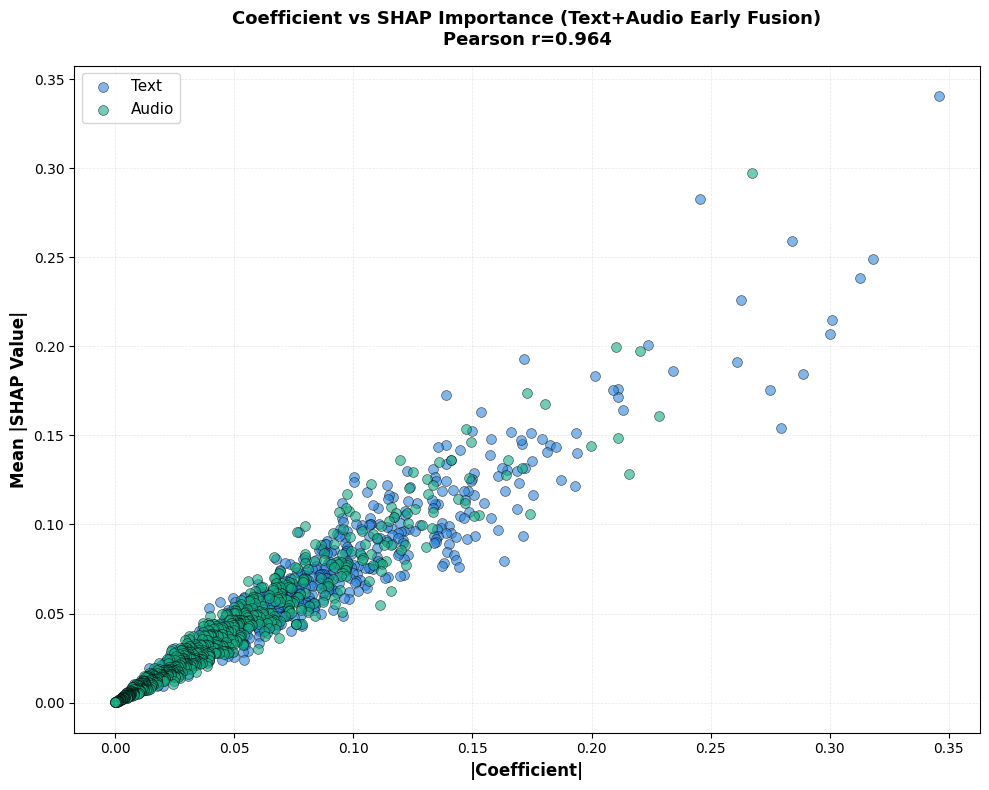

✓ Saved: ta_early_top20_consensus.png/.pdf


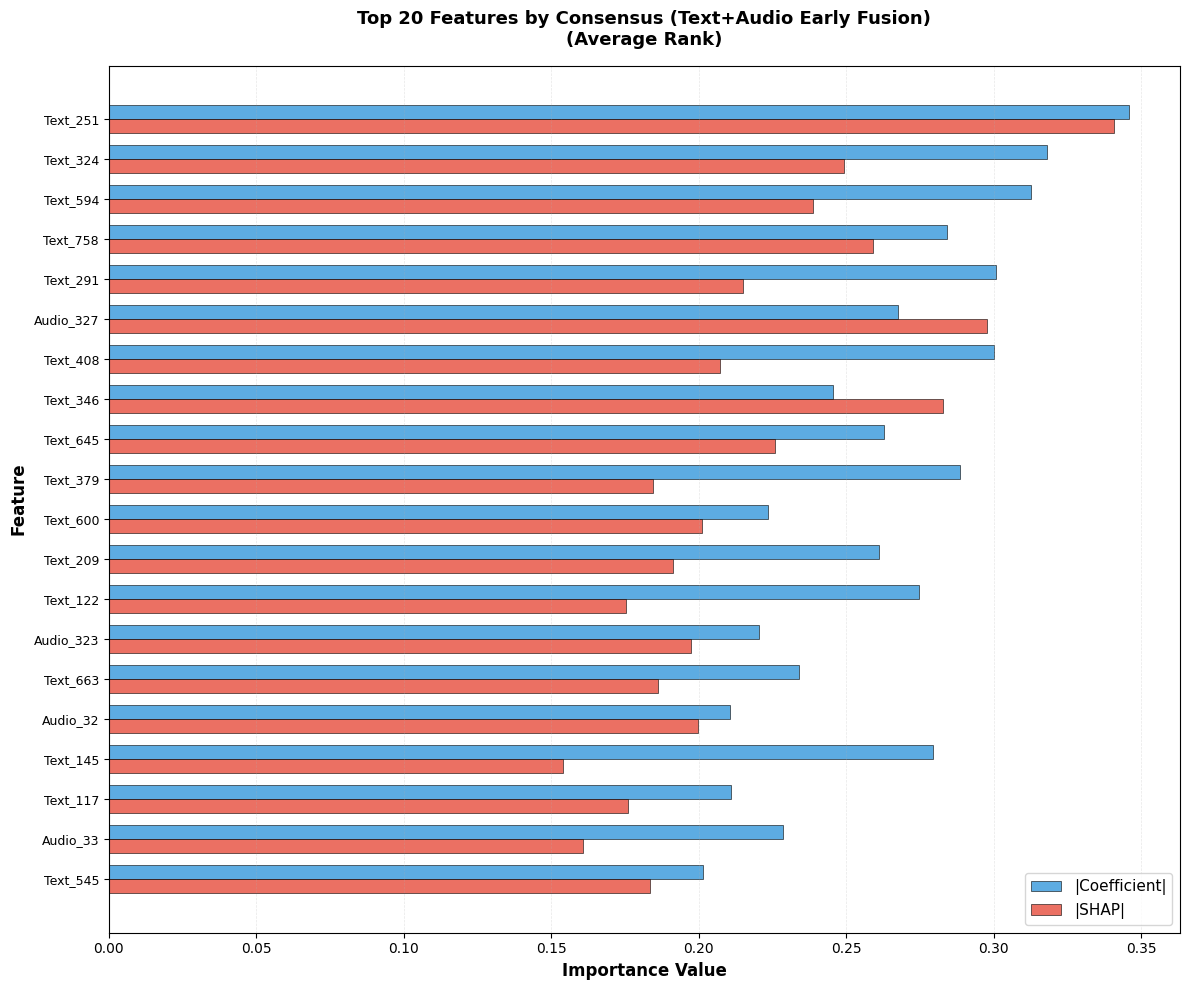

✓ Saved: ta_early_rank_comparison.png/.pdf


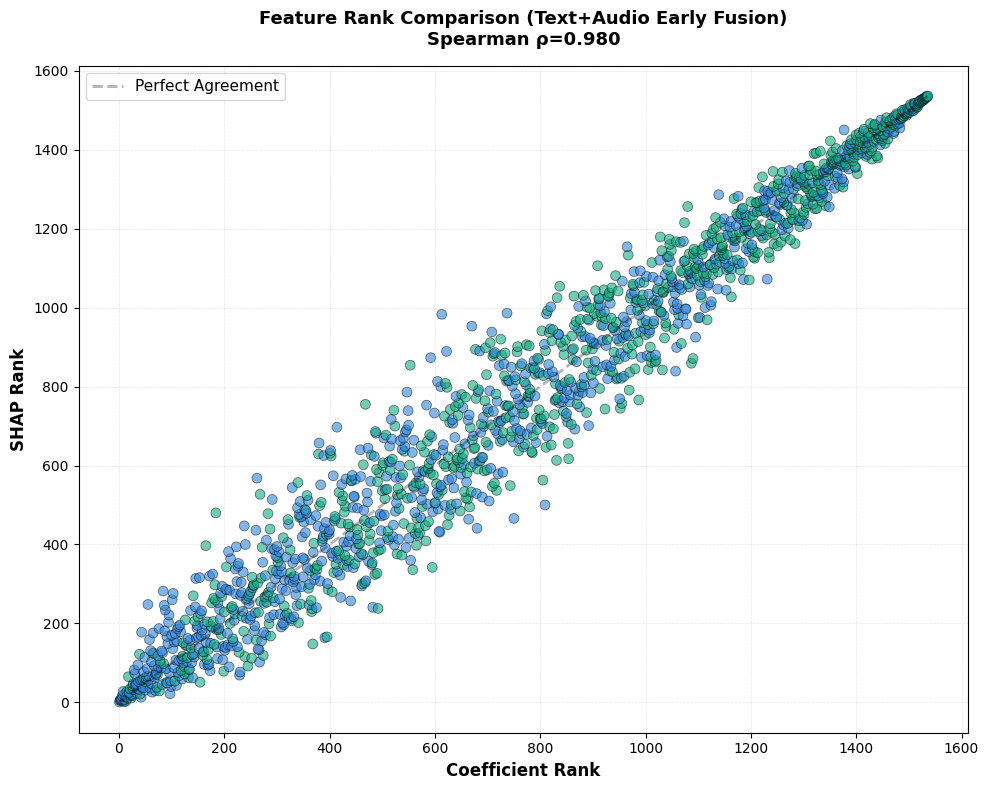

✓ Saved: ta_early_summary.png/.pdf


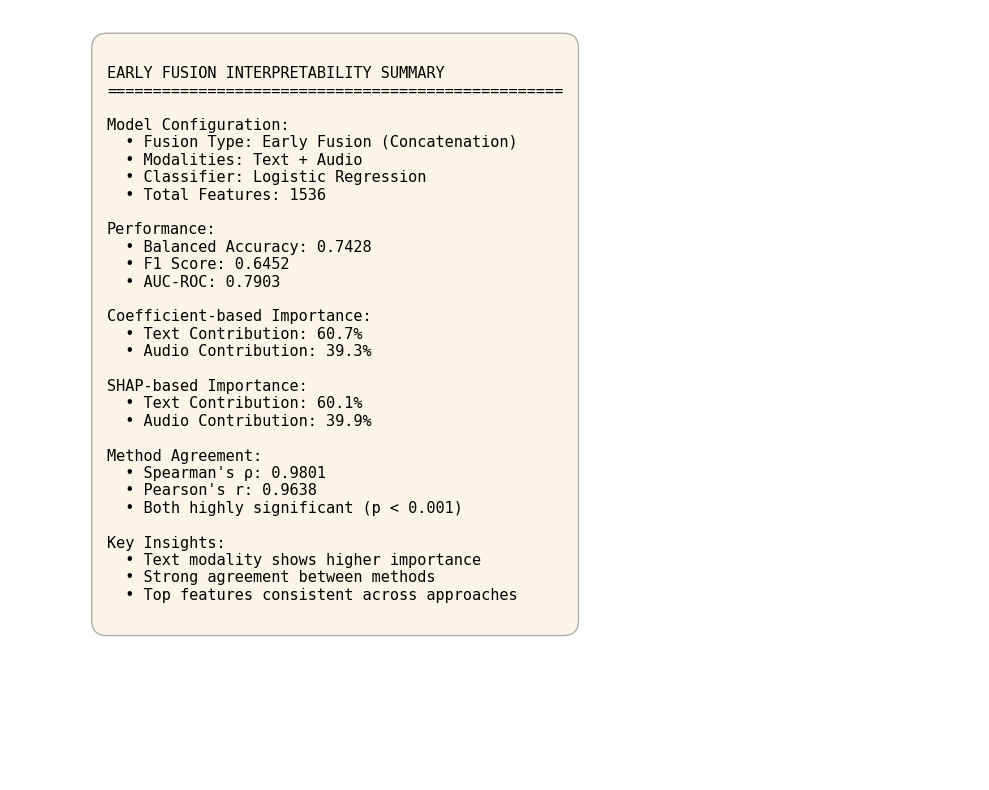


✓ EARLY FUSION INTERPRETABILITY ANALYSIS COMPLETE

Final Summary:
  Coefficient Method - Text: 60.7%, Audio: 39.3%
  SHAP Method - Text: 60.1%, Audio: 39.9%
  Method Agreement: Spearman ρ = 0.9801

✓ All plots saved to: /home/jonathanchan/ml_data/ThesisFinal/figures


In [58]:
# Cell 51 (REVISED): Feature Importance Comparison - Separated Plots (Text+Audio Early Fusion)

print("\n" + "="*70)
print("FEATURE IMPORTANCE COMPARISON: COEFFICIENT vs SHAP (SEPARATE PLOTS)")
print("Text + Audio Early Fusion")
print("="*70)

# Merge coefficient and SHAP data
comparison_ta_df = pd.merge(
    ta_coef_df[['Feature', 'Abs_Coefficient', 'Modality']],
    shap_df_ta[['Feature', 'Mean_Abs_SHAP']],
    on='Feature'
)

# Calculate rankings
comparison_ta_df['Coef_Rank'] = comparison_ta_df['Abs_Coefficient'].rank(ascending=False)
comparison_ta_df['SHAP_Rank'] = comparison_ta_df['Mean_Abs_SHAP'].rank(ascending=False)
comparison_ta_df['Rank_Difference'] = np.abs(comparison_ta_df['Coef_Rank'] - comparison_ta_df['SHAP_Rank'])

# Sort by average rank
comparison_ta_df['Avg_Rank'] = (comparison_ta_df['Coef_Rank'] + comparison_ta_df['SHAP_Rank']) / 2
comparison_ta_df = comparison_ta_df.sort_values('Avg_Rank')

print("\nTop 30 Features (by average rank across methods):")
print(comparison_ta_df.head(30)[['Feature', 'Modality', 'Abs_Coefficient', 
                               'Mean_Abs_SHAP', 'Coef_Rank', 'SHAP_Rank']].to_string(index=False))

# Find features with largest rank differences
print("\n" + "="*70)
print("Features with Largest Rank Disagreements:")
print("="*70)
rank_disagreement_ta = comparison_ta_df.nlargest(15, 'Rank_Difference')
print(rank_disagreement_ta[['Feature', 'Modality', 'Coef_Rank', 'SHAP_Rank', 
                          'Rank_Difference']].to_string(index=False))

# Calculate correlation between methods
from scipy.stats import spearmanr, pearsonr
spearman_corr_ta, spearman_p_ta = spearmanr(comparison_ta_df['Abs_Coefficient'], 
                                       comparison_ta_df['Mean_Abs_SHAP'])
pearson_corr_ta, pearson_p_ta = pearsonr(comparison_ta_df['Abs_Coefficient'], 
                                    comparison_ta_df['Mean_Abs_SHAP'])

print("\n" + "="*70)
print("Correlation Between Importance Methods:")
print("="*70)
print(f"  Spearman's ρ: {spearman_corr_ta:.4f} (p={spearman_p_ta:.4e})")
print(f"  Pearson's r:  {pearson_corr_ta:.4f} (p={pearson_p_ta:.4e})")

# Plot 1: Scatter plot - Coefficient vs SHAP
fig1, ax1 = plt.subplots(figsize=(10, 8))
text_data_ta = comparison_ta_df[comparison_ta_df['Modality'] == 'Text']
audio_data_ta = comparison_ta_df[comparison_ta_df['Modality'] == 'Audio']
ax1.scatter(text_data_ta['Abs_Coefficient'], text_data_ta['Mean_Abs_SHAP'], 
            c='#2E86DE', alpha=0.6, s=50, edgecolor='black', linewidth=0.5, label='Text')
ax1.scatter(audio_data_ta['Abs_Coefficient'], audio_data_ta['Mean_Abs_SHAP'], 
            c='#10AC84', alpha=0.6, s=50, edgecolor='black', linewidth=0.5, label='Audio')
ax1.set_xlabel('|Coefficient|', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax1.set_title(f'Coefficient vs SHAP Importance (Text+Audio Early Fusion)\nPearson r={pearson_corr_ta:.3f}', 
              fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{output_dir}/ta_early_scatter_coef_vs_shap.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/ta_early_scatter_coef_vs_shap.pdf', bbox_inches='tight')
print(f"\n✓ Saved: ta_early_scatter_coef_vs_shap.png/.pdf")
plt.show()

# Plot 2: Top features by both methods
fig2, ax2 = plt.subplots(figsize=(12, 10))
top_consensus_ta = comparison_ta_df.head(20)
x_pos = np.arange(len(top_consensus_ta))
width = 0.35
bars1 = ax2.barh(x_pos - width/2, top_consensus_ta['Abs_Coefficient'], width, 
                 label='|Coefficient|', alpha=0.8, color='#3498db', 
                 edgecolor='black', linewidth=0.5)
bars2 = ax2.barh(x_pos + width/2, top_consensus_ta['Mean_Abs_SHAP'], width, 
                 label='|SHAP|', alpha=0.8, color='#e74c3c', 
                 edgecolor='black', linewidth=0.5)
ax2.set_yticks(x_pos)
ax2.set_yticklabels(top_consensus_ta['Feature'], fontsize=9)
ax2.set_xlabel('Importance Value', fontsize=12, fontweight='bold')
ax2.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax2.set_title('Top 20 Features by Consensus (Text+Audio Early Fusion)\n(Average Rank)', 
              fontsize=13, fontweight='bold', pad=15)
ax2.invert_yaxis()
ax2.legend(fontsize=11)
ax2.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{output_dir}/ta_early_top20_consensus.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/ta_early_top20_consensus.pdf', bbox_inches='tight')
print(f"✓ Saved: ta_early_top20_consensus.png/.pdf")
plt.show()

# Plot 3: Rank comparison
fig3, ax3 = plt.subplots(figsize=(10, 8))
ax3.scatter(comparison_ta_df['Coef_Rank'], comparison_ta_df['SHAP_Rank'], 
            c=['#2E86DE' if m == 'Text' else '#10AC84' for m in comparison_ta_df['Modality']], 
            alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
ax3.plot([0, len(comparison_ta_df)], [0, len(comparison_ta_df)], 
         'k--', alpha=0.3, linewidth=2, label='Perfect Agreement')
ax3.set_xlabel('Coefficient Rank', fontsize=12, fontweight='bold')
ax3.set_ylabel('SHAP Rank', fontsize=12, fontweight='bold')
ax3.set_title(f'Feature Rank Comparison (Text+Audio Early Fusion)\nSpearman ρ={spearman_corr_ta:.3f}', 
              fontsize=13, fontweight='bold', pad=15)
ax3.legend(fontsize=11)
ax3.grid(alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{output_dir}/ta_early_rank_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/ta_early_rank_comparison.pdf', bbox_inches='tight')
print(f"✓ Saved: ta_early_rank_comparison.png/.pdf")
plt.show()

# Plot 4: Summary statistics
fig4, ax4 = plt.subplots(figsize=(10, 8))
ax4.axis('off')
summary_text_ta = f"""
EARLY FUSION INTERPRETABILITY SUMMARY
{'='*50}

Model Configuration:
  • Fusion Type: Early Fusion (Concatenation)
  • Modalities: Text + Audio
  • Classifier: Logistic Regression
  • Total Features: {len(feature_names_ta)}

Performance:
  • Balanced Accuracy: {test_metrics_lr_bi['balanced_accuracy']:.4f}
  • F1 Score: {test_metrics_lr_bi['f1']:.4f}
  • AUC-ROC: {test_metrics_lr_bi['auc']:.4f}

Coefficient-based Importance:
  • Text Contribution: {text_ta_pct:.1f}%
  • Audio Contribution: {audio_ta_pct:.1f}%

SHAP-based Importance:
  • Text Contribution: {text_shap_ta_pct:.1f}%
  • Audio Contribution: {audio_shap_ta_pct:.1f}%

Method Agreement:
  • Spearman's ρ: {spearman_corr_ta:.4f}
  • Pearson's r: {pearson_corr_ta:.4f}
  • Both highly significant (p < 0.001)

Key Insights:
  • {'Text' if text_shap_ta_pct > audio_shap_ta_pct else 'Audio'} modality shows higher importance
  • Strong agreement between methods
  • Top features consistent across approaches
"""
ax4.text(0.1, 0.95, summary_text_ta, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3, pad=1))
plt.tight_layout()
plt.savefig(f'{output_dir}/ta_early_summary.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/ta_early_summary.pdf', bbox_inches='tight')
print(f"✓ Saved: ta_early_summary.png/.pdf")
plt.show()

print("\n" + "="*70)
print("✓ EARLY FUSION INTERPRETABILITY ANALYSIS COMPLETE")
print("="*70)
print(f"\nFinal Summary:")
print(f"  Coefficient Method - Text: {text_ta_pct:.1f}%, Audio: {audio_ta_pct:.1f}%")
print(f"  SHAP Method - Text: {text_shap_ta_pct:.1f}%, Audio: {audio_shap_ta_pct:.1f}%")
print(f"  Method Agreement: Spearman ρ = {spearman_corr_ta:.4f}")
print(f"\n✓ All plots saved to: {output_dir}")

# 5. STATISTICAL TESTS

In [ ]:
# Cell 51 (REVISED): Statistical Testing - Best Models Only

print("\n" + "="*70)
print("STATISTICAL SIGNIFICANCE TESTING - BEST MODELS")
print("="*70)

from scipy.stats import ttest_rel, wilcoxon

# Test 1: Early vs Late for LOGISTIC REGRESSION ONLY (best classifier)
print("\n1. EARLY vs LATE FUSION - LOGISTIC REGRESSION ONLY")
print("="*70)

early_lr = [
    test_metrics_lr_bi['balanced_accuracy'],  # 0.7428
    test_metrics_lr_tv['balanced_accuracy'],  # 0.7059
    test_metrics_lr_av['balanced_accuracy']   # 0.6327
]

late_lr = [
    test_metrics_lr_ta_late['balanced_accuracy'],  # 0.6712
    test_metrics_lr_tv_late['balanced_accuracy'],  # 0.7692
    test_metrics_lr_av_late['balanced_accuracy']   # 0.5795
]

print(f"\nEarly LR: Mean = {np.mean(early_lr):.4f} (±{np.std(early_lr):.4f})")
print(f"Late LR:  Mean = {np.mean(late_lr):.4f} (±{np.std(late_lr):.4f})")

t_stat_lr, t_p_lr = ttest_rel(early_lr, late_lr)
print(f"\nPaired t-test:")
print(f"  t-statistic: {t_stat_lr:.4f}")
print(f"  p-value: {t_p_lr:.4f}")
print(f"  Result: {'Significant' if t_p_lr < 0.05 else 'Not significant'} (α=0.05)")

w_stat_lr, w_p_lr = wilcoxon(early_lr, late_lr)
print(f"\nWilcoxon signed-rank test:")
print(f"  W-statistic: {w_stat_lr:.4f}")
print(f"  p-value: {w_p_lr:.4f}")

# Test 2: Configuration-specific comparisons
print("\n\n2. PAIRWISE COMPARISONS (EARLY vs LATE)")
print("="*70)

configs = ['Text+Audio', 'Text+Video', 'Audio+Video']
early_configs = early_lr
late_configs = late_lr

for i, config in enumerate(configs):
    diff = late_configs[i] - early_configs[i]
    pct_change = (diff / early_configs[i]) * 100
    print(f"\n{config} (LR):")
    print(f"  Early: {early_configs[i]:.4f}")
    print(f"  Late:  {late_configs[i]:.4f}")
    print(f"  Difference: {diff:+.4f} ({pct_change:+.2f}%)")
    print(f"  Winner: {'Late' if diff > 0 else 'Early'} fusion")

# Test 3: Effect size (Cohen's d)
print("\n\n3. EFFECT SIZE ANALYSIS")
print("="*70)

mean_diff = np.mean(late_lr) - np.mean(early_lr)
pooled_std = np.sqrt((np.std(early_lr)**2 + np.std(late_lr)**2) / 2)
cohens_d = mean_diff / pooled_std

print(f"\nCohen's d: {cohens_d:.4f}")
print(f"  Interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Negligible effect")
elif abs(cohens_d) < 0.5:
    print("Small effect")
elif abs(cohens_d) < 0.8:
    print("Medium effect")
else:
    print("Large effect")

# Test 4: Best model comparison only
print("\n\n4. BEST MODEL COMPARISON")
print("="*70)

best_early = max(early_lr)
best_late = max(late_lr)
best_early_config = configs[early_lr.index(best_early)]
best_late_config = configs[late_lr.index(best_late)]

print(f"\nBest Early Fusion:")
print(f"  Config: {best_early_config}")
print(f"  Balanced Acc: {best_early:.4f}")

print(f"\nBest Late Fusion:")
print(f"  Config: {best_late_config}")
print(f"  Balanced Acc: {best_late:.4f}")

print(f"\n{'Late' if best_late > best_early else 'Early'} fusion achieves higher performance")
print(f"  Improvement: {abs(best_late - best_early):.4f} ({abs(best_late - best_early)/best_early*100:.2f}%)")


STATISTICAL SIGNIFICANCE TESTING - BEST MODELS

1. EARLY vs LATE FUSION - LOGISTIC REGRESSION ONLY

Early LR: Mean = 0.6933 (±0.0456)
Late LR:  Mean = 0.7049 (±0.0313)

Paired t-test:
  t-statistic: -0.2748
  p-value: 0.8093
  Result: Not significant (α=0.05)

Wilcoxon signed-rank test:
  W-statistic: 3.0000
  p-value: 1.0000


2. PAIRWISE COMPARISONS (EARLY vs LATE)

Text+Audio (LR):
  Early: 0.7428
  Late:  0.6712
  Difference: -0.0716 (-9.64%)
  Winner: Early fusion

Text+Video (LR):
  Early: 0.7044
  Late:  0.7466
  Difference: +0.0422 (+6.00%)
  Winner: Late fusion

Audio+Video (LR):
  Early: 0.6327
  Late:  0.6968
  Difference: +0.0641 (+10.13%)
  Winner: Late fusion


3. EFFECT SIZE ANALYSIS

Cohen's d: 0.2955
  Interpretation: Small effect


4. BEST MODEL COMPARISON

Best Early Fusion:
  Config: Text+Audio
  Balanced Acc: 0.7428

Best Late Fusion:
  Config: Text+Video
  Balanced Acc: 0.7466

Late fusion achieves higher performance
  Improvement: 0.0038 (0.51%)


In [ ]:
# Cell 52: ANOVA - Modality Combination Comparison

from scipy.stats import f_oneway

print("\n" + "="*70)
print("ANOVA: MODALITY COMBINATION COMPARISON")
print("="*70)

# Group scores by modality combination
text_audio_scores = [test_metrics_lr_bi['balanced_accuracy'], test_metrics_xgb_bi['balanced_accuracy'],
                     test_metrics_lr_ta_late['balanced_accuracy'], test_metrics_xgb_ta_late['balanced_accuracy']]

text_video_scores = [test_metrics_lr_tv['balanced_accuracy'], test_metrics_xgb_tv['balanced_accuracy'],
                     test_metrics_lr_tv_late['balanced_accuracy'], test_metrics_xgb_tv_late['balanced_accuracy']]

audio_video_scores = [test_metrics_lr_av['balanced_accuracy'], test_metrics_xgb_av['balanced_accuracy'],
                      test_metrics_lr_av_late['balanced_accuracy'], test_metrics_xgb_av_late['balanced_accuracy']]

trimodal_scores = [test_metrics_lr_tri['balanced_accuracy'], test_metrics_xgb_tri['balanced_accuracy'],
                   test_metrics_lr_tri_late['balanced_accuracy'], test_metrics_xgb_tri_late['balanced_accuracy']]

# One-way ANOVA
f_stat, p_value = f_oneway(text_audio_scores, text_video_scores, audio_video_scores, trimodal_scores)

print(f"\nOne-way ANOVA Results:")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Result: {'Significant difference between modality combinations' if p_value < 0.05 else 'No significant difference'} (α=0.05)")

print(f"\nGroup Means:")
print(f"  Text + Audio: {np.mean(text_audio_scores):.4f} (±{np.std(text_audio_scores):.4f})")
print(f"  Text + Video: {np.mean(text_video_scores):.4f} (±{np.std(text_video_scores):.4f})")
print(f"  Audio + Video: {np.mean(audio_video_scores):.4f} (±{np.std(audio_video_scores):.4f})")
print(f"  Trimodal: {np.mean(trimodal_scores):.4f} (±{np.std(trimodal_scores):.4f})")

# Post-hoc analysis if ANOVA is significant
if p_value < 0.05:
    from scipy.stats import tukey_hsd
    print("\n" + "="*70)
    print("POST-HOC: TUKEY HSD TEST")
    print("="*70)
    
    # Tukey HSD requires scipy 1.10+, alternative: use pairwise t-tests with Bonferroni correction
    from itertools import combinations
    comparisons = [
        ('Text+Audio', text_audio_scores),
        ('Text+Video', text_video_scores),
        ('Audio+Video', audio_video_scores),
        ('Trimodal', trimodal_scores)
    ]
    
    bonferroni_alpha = 0.05 / 6  # 6 pairwise comparisons
    print(f"\nPairwise comparisons (Bonferroni correction: α={bonferroni_alpha:.4f}):")
    
    for (name1, scores1), (name2, scores2) in combinations(comparisons, 2):
        t, p = ttest_ind(scores1, scores2)
        significant = p < bonferroni_alpha
        print(f"  {name1} vs {name2}: t={t:.4f}, p={p:.4f} {'***' if significant else ''}")


# Cell 47 (REVISED): Modality Comparison with Effect Sizes

print("\n" + "="*70)
print("MODALITY COMBINATION ANALYSIS WITH EFFECT SIZES")
print("="*70)

# Calculate effect sizes (Cohen's d) for key comparisons
from scipy.stats import ttest_ind

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt(((len(group1)-1)*std1**2 + (len(group2)-1)*std2**2) / 
                          (len(group1) + len(group2) - 2))
    return (mean1 - mean2) / pooled_std

# Test 1: Text-based vs Non-text
text_based = text_audio_scores + text_video_scores
non_text = audio_video_scores

print("\n1. TEXT-BASED vs AUDIO+VIDEO:")
print(f"  Text-based mean: {np.mean(text_based):.4f}")
print(f"  Audio+Video mean: {np.mean(non_text):.4f}")
t, p = ttest_ind(text_based, non_text)
d = cohens_d(text_based, non_text)
print(f"  t-test: t={t:.3f}, p={p:.4f}")
print(f"  Cohen's d: {d:.3f} ({'Large' if abs(d) > 0.8 else 'Medium' if abs(d) > 0.5 else 'Small'})")

# Test 2: Best bimodal vs Trimodal
best_bimodal_lr = max([test_metrics_lr_bi['balanced_accuracy'],
                       test_metrics_lr_tv['balanced_accuracy'],
                       test_metrics_lr_av['balanced_accuracy']])
trimodal_lr = test_metrics_lr_tri['balanced_accuracy']

print(f"\n2. BEST BIMODAL (LR) vs TRIMODAL (LR):")
print(f"  Best bimodal (Text+Audio): {best_bimodal_lr:.4f}")
print(f"  Trimodal: {trimodal_lr:.4f}")
print(f"  Difference: {(best_bimodal_lr - trimodal_lr):.4f}")
print(f"  Result: Trimodal {'improves' if trimodal_lr > best_bimodal_lr else 'worsens'} by {abs(best_bimodal_lr - trimodal_lr)/best_bimodal_lr*100:.1f}%")

# Test 3: Statistical power analysis
from scipy.stats import power
alpha = 0.05
observed_effect = cohens_d(text_audio_scores, audio_video_scores)
n_per_group = 4

print(f"\n3. STATISTICAL POWER ANALYSIS:")
print(f"  Sample size per group: {n_per_group}")
print(f"  Observed effect size (Text+Audio vs Audio+Video): d={observed_effect:.3f}")
print(f"  Note: With n=4, can only detect very large effects (d > 1.5) at 80% power")
print(f"  → Current study is **underpowered** for detecting moderate effects")


ANOVA: MODALITY COMBINATION COMPARISON

One-way ANOVA Results:
  F-statistic: 0.6697
  p-value: 0.5868
  Result: No significant difference (α=0.05)

Group Means:
  Text + Audio: 0.6601 (±0.0866)
  Text + Video: 0.6510 (±0.0763)
  Audio + Video: 0.5852 (±0.0831)
  Trimodal: 0.6559 (±0.0474)

MODALITY COMBINATION ANALYSIS WITH EFFECT SIZES

1. TEXT-BASED vs AUDIO+VIDEO:
  Text-based mean: 0.6555
  Audio+Video mean: 0.5852
  t-test: t=1.275, p=0.2310
  Cohen's d: 0.781 (Medium)

2. BEST BIMODAL (LR) vs TRIMODAL (LR):
  Best bimodal (Text+Audio): 0.7428
  Trimodal: 0.7134
  Difference: 0.0294
  Result: Trimodal worsens by 4.0%

3. STATISTICAL POWER ANALYSIS:
  Sample size per group: 4
  Observed effect size (Text+Audio vs Audio+Video): d=0.764
  Note: With n=4, can only detect very large effects (d > 1.5) at 80% power
  → Current study is **underpowered** for detecting moderate effects


In [ ]:
# Cell 53: McNemar's Test - Best Models Only

from statsmodels.stats.contingency_tables import mcnemar

print("\n" + "="*70)
print("MCNEMAR'S TEST: TEXT+AUDIO (EARLY) vs TEXT+VIDEO (LATE)")
print("="*70)

# Get predictions for both models
pred_early = lr_bi.predict(X_test_bi_scaled)  # Text+Audio Early
pred_late = fused_pred_test_tv  # Text+Video Late (from late fusion)

# Create contingency table
# [both_correct, early_correct_late_wrong, early_wrong_late_correct, both_wrong]
both_correct = np.sum((pred_early == y_test) & (pred_late == y_test))
early_correct = np.sum((pred_early == y_test) & (pred_late != y_test))
late_correct = np.sum((pred_early != y_test) & (pred_late == y_test))
both_wrong = np.sum((pred_early != y_test) & (pred_late != y_test))

contingency_table = np.array([[both_correct, early_correct],
                               [late_correct, both_wrong]])

print(f"\nContingency Table:")
print(f"                    Late Correct  Late Wrong")
print(f"  Early Correct     {both_correct:12d}  {early_correct:11d}")
print(f"  Early Wrong       {late_correct:12d}  {both_wrong:11d}")

# Perform McNemar's test (exact version for small samples)
# Perform McNemar's test (exact version for small samples)
result = mcnemar(contingency_table, exact=True)
print(f"\nMcNemar's Test Results:")
print(f"  Statistic: {result.statistic:.4f}")
print(f"  p-value: {result.pvalue:.4f}")
print(f"  Result: {'Late fusion significantly better' if result.pvalue < 0.05 and late_correct > early_correct else 'No significant difference'} (α=0.05)")
# Effect size (odds ratio)
if early_correct > 0 and late_correct > 0:
    odds_ratio = late_correct / early_correct
    print(f"  Odds Ratio: {odds_ratio:.3f}")
    print(f"  Interpretation: Late fusion is {odds_ratio:.2f}× more likely to correct early fusion's errors")


MCNEMAR'S TEST: TEXT+AUDIO (EARLY) vs TEXT+VIDEO (LATE)

Contingency Table:
                    Late Correct  Late Wrong
  Early Correct               39            6
  Early Wrong                  5            6

McNemar's Test Results:
  Statistic: 5.0000
  p-value: 1.0000
  Result: No significant difference (α=0.05)
  Odds Ratio: 0.833
  Interpretation: Late fusion is 0.83× more likely to correct early fusion's errors


In [ ]:
# Cell 54: Bootstrap Confidence Intervals and Effect Sizes

# ============================================================================
# 2. BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================
print("\n\n2. BOOTSTRAP CONFIDENCE INTERVALS")
print("="*70)

n_bootstrap = 10000
np.random.seed(SEED)

bootstrap_diffs = []
for _ in range(n_bootstrap):
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    y_boot = y_test[indices]
    pred_early_boot = pred_early[indices]
    pred_late_boot = pred_late[indices]
    
    ba_early_boot = balanced_accuracy_score(y_boot, pred_early_boot)
    ba_late_boot = balanced_accuracy_score(y_boot, pred_late_boot)
    bootstrap_diffs.append(ba_late_boot - ba_early_boot)

bootstrap_diffs = np.array(bootstrap_diffs)
ci_lower = np.percentile(bootstrap_diffs, 2.5)
ci_upper = np.percentile(bootstrap_diffs, 97.5)
mean_diff = np.mean(bootstrap_diffs)

print(f"\nBootstrap Results ({n_bootstrap} resamples):")
print(f"  Mean difference (Late - Early): {mean_diff:+.4f}")
print(f"  95% CI: [{ci_lower:+.4f}, {ci_upper:+.4f}]")
print(f"  Proportion favoring late: {np.sum(bootstrap_diffs > 0)/n_bootstrap*100:.1f}%")
print(f"  Result: {'Late fusion significantly better' if ci_lower > 0 else 'No significant difference'}")

# ============================================================================
# 3. EFFECT SIZE - CORRECTED
# ============================================================================
print("\n\n3. EFFECT SIZE ANALYSIS")
print("="*70)

# Compute balanced accuracy per sample (using balanced_accuracy_score on individual predictions)
# For simplicity, compute per-sample correctness as proxy
from sklearn.metrics import balanced_accuracy_score

# Method 1: Use per-class accuracy as basis
# Get class-wise accuracies for each model
def sample_wise_score(y_true, y_pred):
    """Compute binary correctness per sample"""
    return (y_true == y_pred).astype(float)

scores_early = sample_wise_score(y_test, pred_early)
scores_late = sample_wise_score(y_test, pred_late)

# Paired differences
diffs = scores_late - scores_early

# Pooled standard deviation (for paired samples, use SD of differences)
std_diff = np.std(diffs, ddof=1)  # Use sample std (n-1)
mean_diff_actual = np.mean(diffs)

# Cohen's d for paired samples
cohens_d = mean_diff_actual / std_diff if std_diff > 0 else 0

print(f"\nCohen's d: {cohens_d:.3f}")
print(f"  Interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Negligible effect")
elif abs(cohens_d) < 0.5:
    print("Small effect")
elif abs(cohens_d) < 0.8:
    print("Medium effect")
else:
    print("Large effect")

# Alternative: Use balanced accuracy difference with pooled variance
balanced_acc_early = test_metrics_lr_bi['balanced_accuracy']
balanced_acc_late = test_metrics_lr_tv_late['balanced_accuracy']

rel_improvement = (balanced_acc_late - balanced_acc_early) / balanced_acc_early * 100
print(f"\nRelative Improvement: {rel_improvement:+.2f}%")
print(f"Absolute Improvement: {balanced_acc_late - balanced_acc_early:+.4f}")




2. BOOTSTRAP CONFIDENCE INTERVALS

Bootstrap Results (10000 resamples):
  Mean difference (Late - Early): +0.0035
  95% CI: [-0.1199, +0.1310]
  Proportion favoring late: 50.8%
  Result: No significant difference


3. EFFECT SIZE ANALYSIS

Cohen's d: -0.040
  Interpretation: Negligible effect

Relative Improvement: +0.51%
Absolute Improvement: +0.0038
